Please run those two cells before running the Notebook!

As those plotting settings are standard throughout the book, we do not show them in the book every time we plot something.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

# Chapter 6 - Time Series Analysis and Forecasting

## 6.1 Time series decomposition

### How to do it...

1. Import the libraries and authenticate:

In [3]:
import pandas as pd
import nasdaqdatalink
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

nasdaqdatalink.ApiConfig.api_key = "YOUR_KEY_HERE"

2. Download the monthly US unemployment rate from years 2010-2019:

In [4]:
df = (
    nasdaqdatalink.get(dataset="FRED/UNRATENSA", 
                       start_date="2010-01-01", 
                       end_date="2019-12-31")
    .rename(columns={"Value": "unemp_rate"})
)
df.head()

unemp_rate
Date                  
2010-01-01        10.6
2010-02-01        10.4
2010-03-01        10.2
2010-04-01         9.5
2010-05-01         9.3

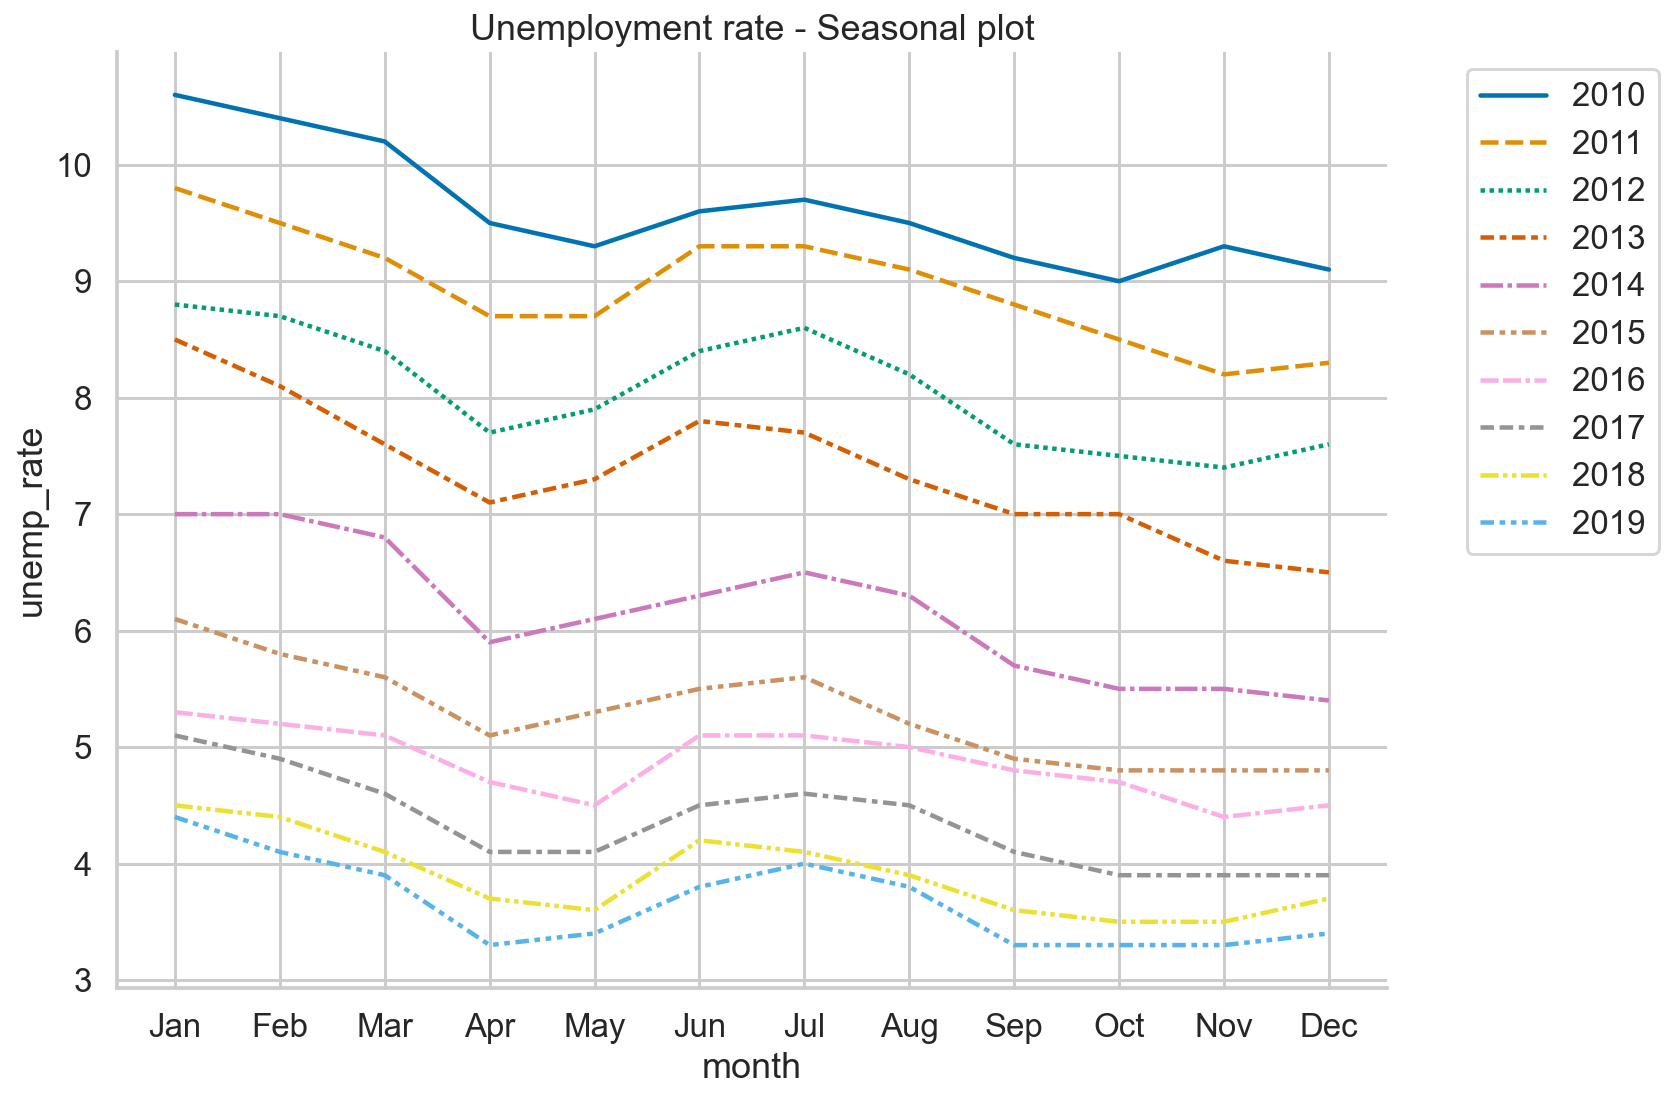

In [5]:
# a quick look at the plot
temp_df = df.copy()

temp_df["year"] = temp_df.index.year
temp_df["month"] = temp_df.index.strftime("%b")

sns.lineplot(data=temp_df, 
             x="month", 
             y="unemp_rate", 
             hue="year",
             style="year", 
             legend="full",
             palette="colorblind")

plt.title("Unemployment rate - Seasonal plot")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_2", dpi=200)

3. Add rolling mean and standard deviation:

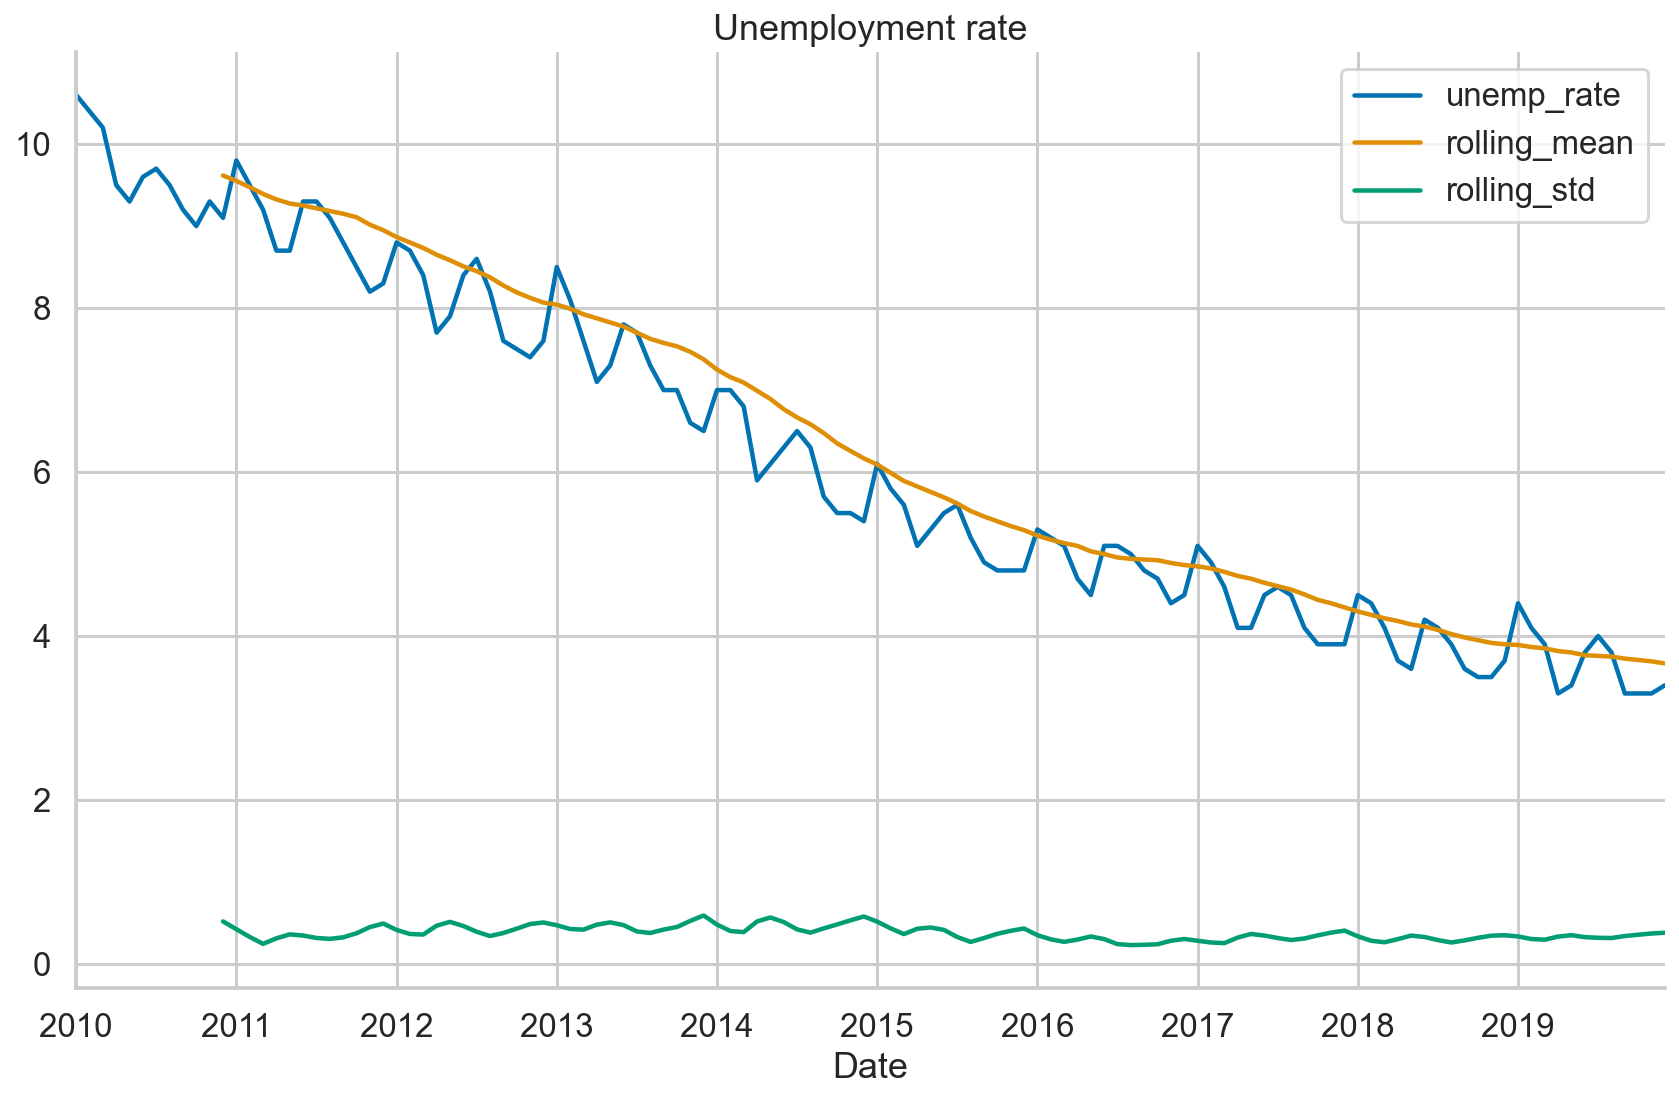

In [6]:
WINDOW_SIZE = 12
df["rolling_mean"] = df["unemp_rate"].rolling(window=WINDOW_SIZE).mean()
df["rolling_std"] = df["unemp_rate"].rolling(window=WINDOW_SIZE).std()
df.plot(title="Unemployment rate")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_3", dpi=200)

4. Carry out seasonal decomposition using the additive model:

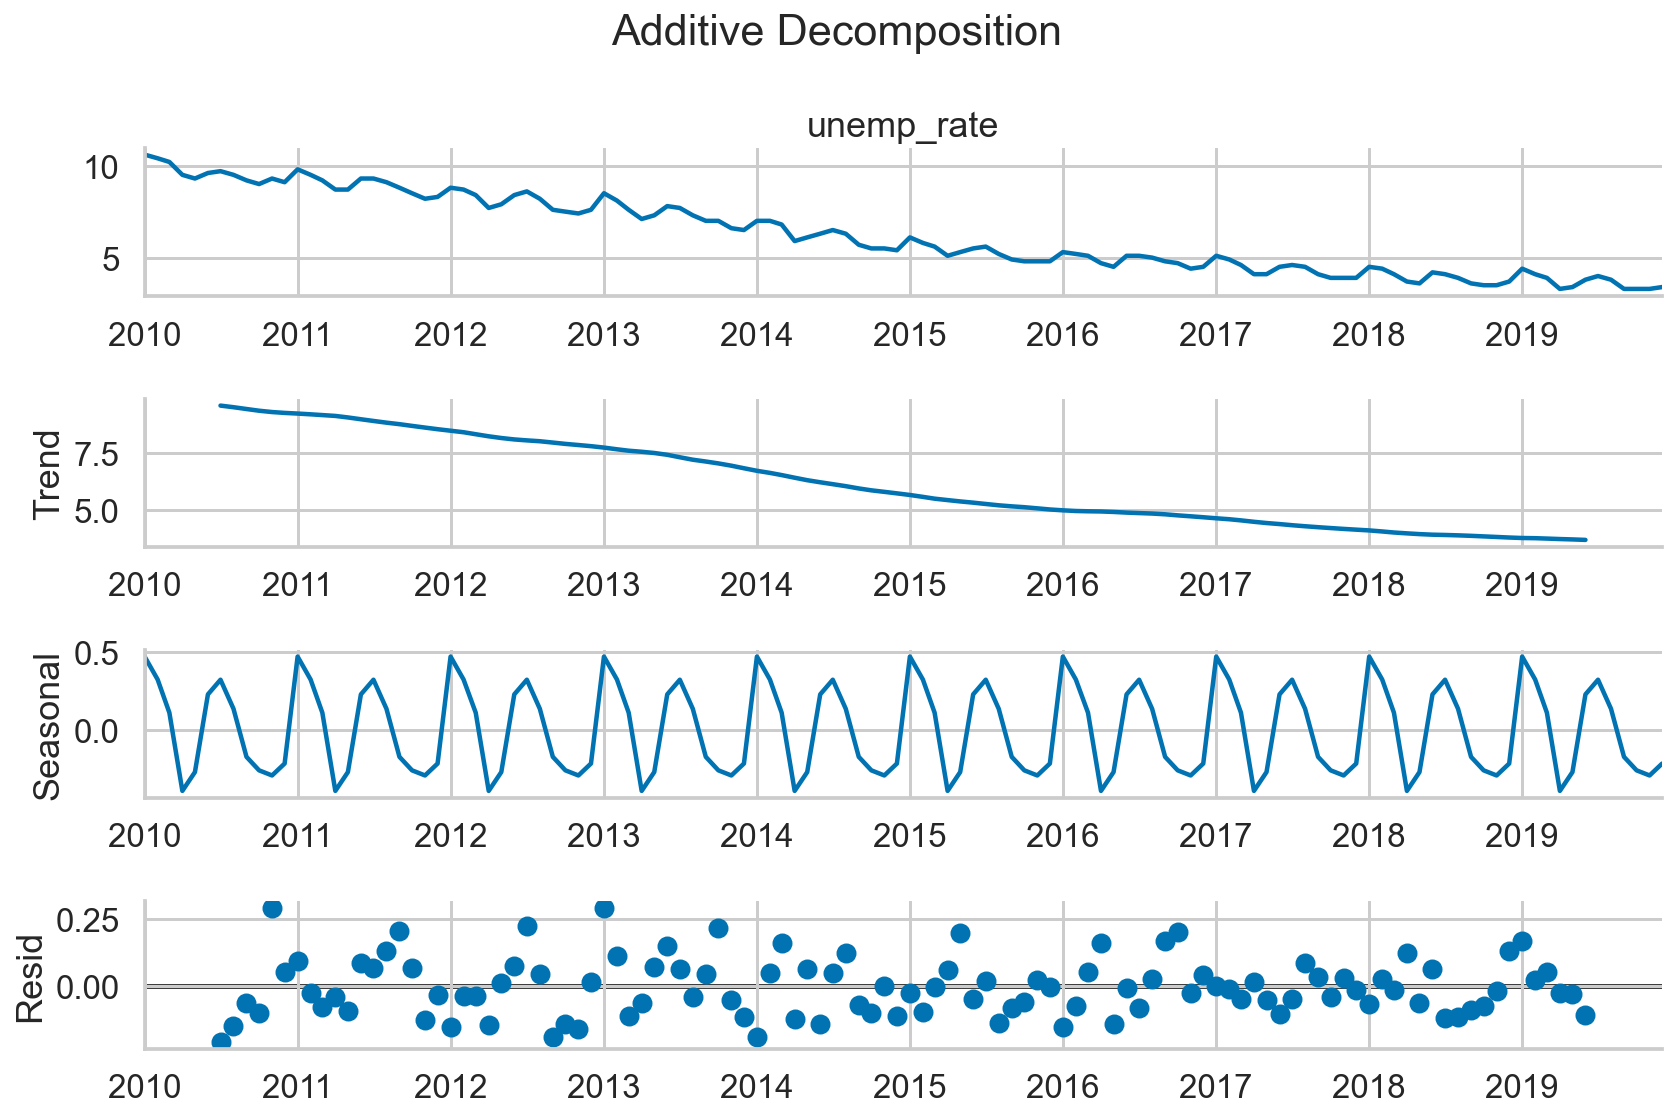

In [7]:
decomposition_results = seasonal_decompose(df["unemp_rate"], 
                                           model="additive")
(
    decomposition_results
    .plot()
    .suptitle("Additive Decomposition")
)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_4", dpi=200)

### There's more

Use the STL decomposition:

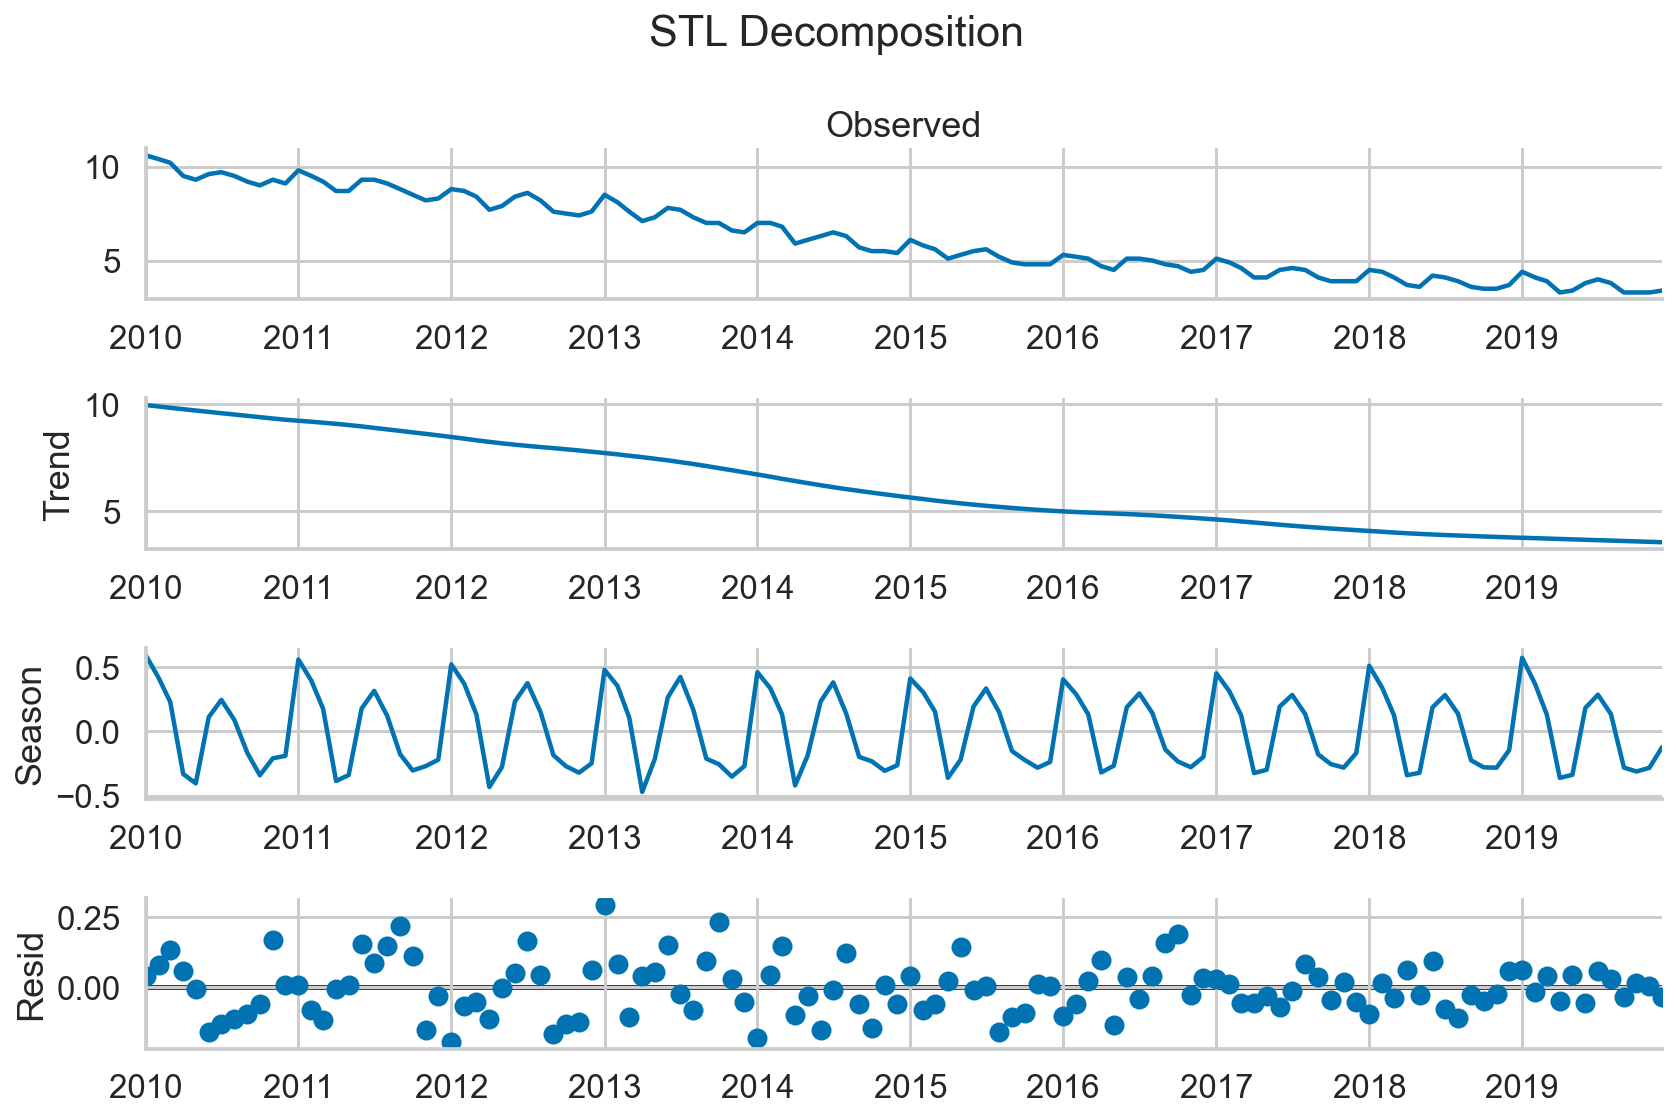

In [9]:
from statsmodels.tsa.seasonal import STL

stl_decomposition = STL(df[["unemp_rate"]]).fit()
stl_decomposition.plot() \
                 .suptitle("STL Decomposition")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_5", dpi=200)

Compare the decompositions with and without the robust setting:

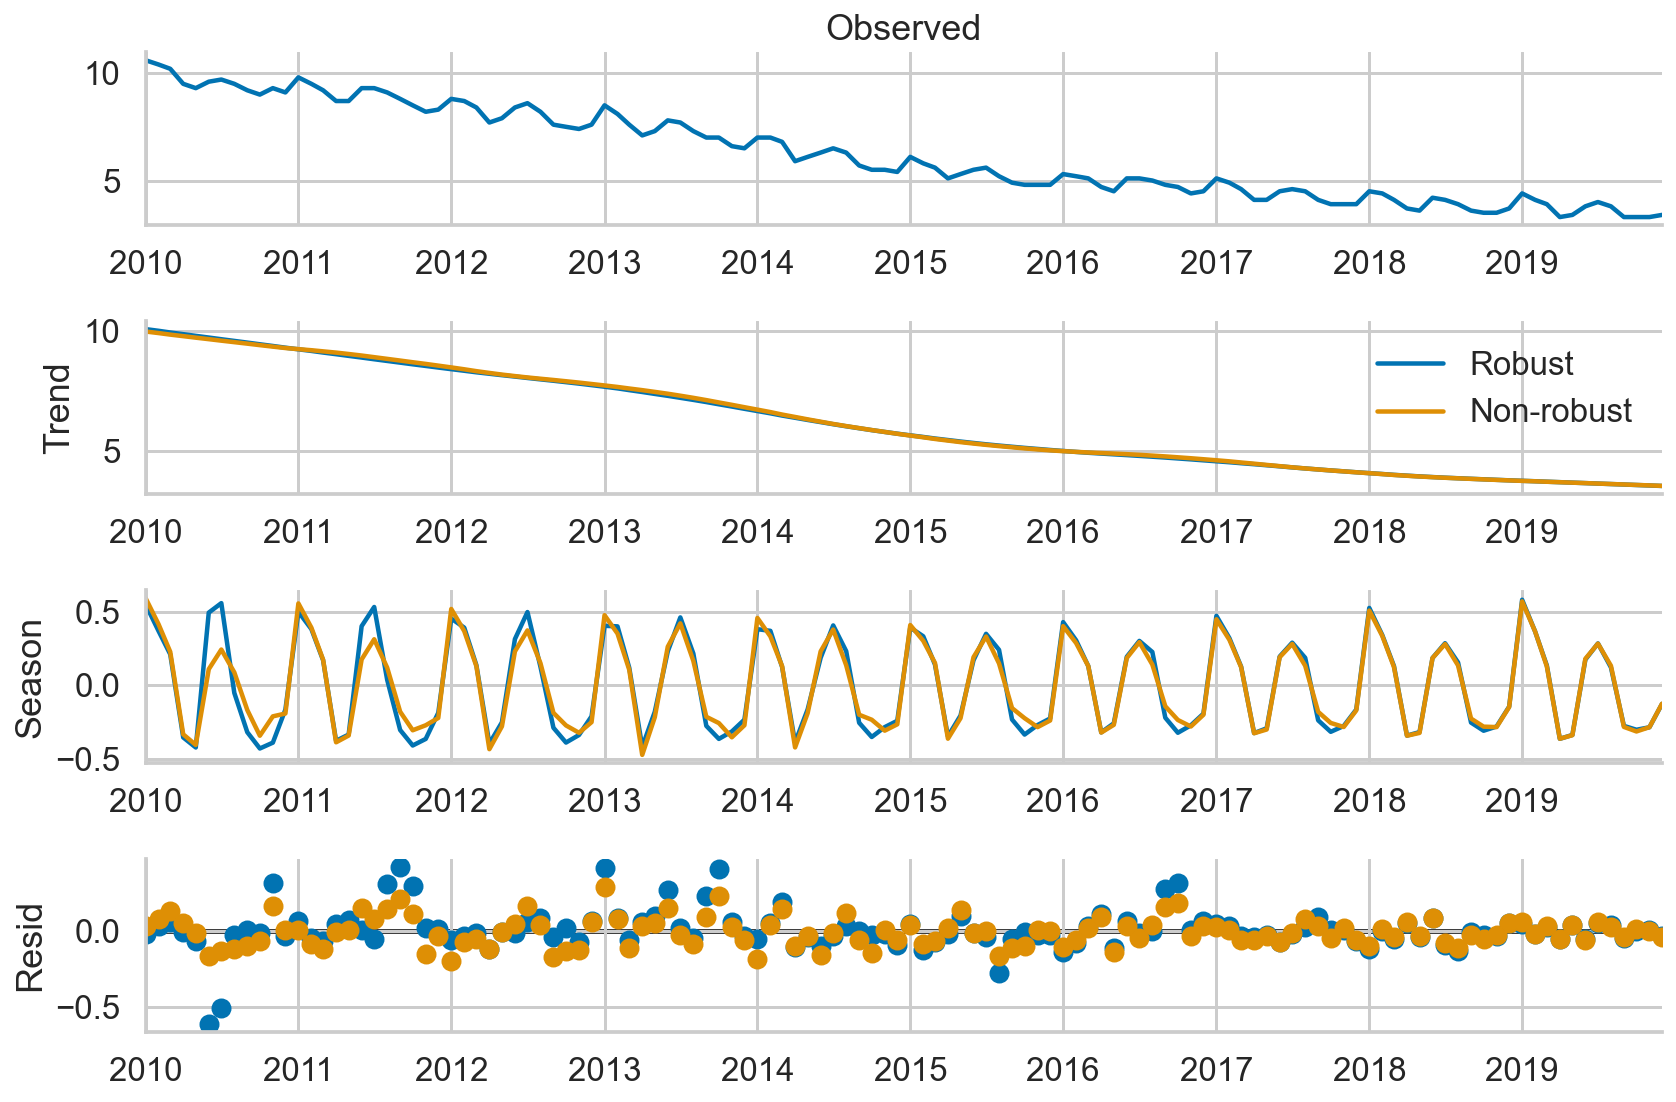

In [10]:
def add_second_stl_to_plot(fig, fitted_stl, labels):
    """
    A helper function adding the 3 components from the second STL fit to the 
    first STL plot
    """
    axs = fig.get_axes()
    comps = ["trend", "seasonal", "resid"]
    for ax, comp in zip(axs[1:], comps):
        series = getattr(fitted_stl, comp)
        if comp == "resid":
            ax.plot(series, marker="o", linestyle="none")
        else:
            ax.plot(series)
            if comp == "trend":
                ax.legend(labels, frameon=False)


stl_robust = STL(df[["unemp_rate"]], robust=True).fit()
stl_non_robust = STL(df[["unemp_rate"]], robust=False).fit()
fig = stl_robust.plot()
add_second_stl_to_plot(fig, stl_non_robust, ["Robust", "Non-robust"])

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_6", dpi=200)


Apply the Hodrick-Prescott filter to the unemployment time series:

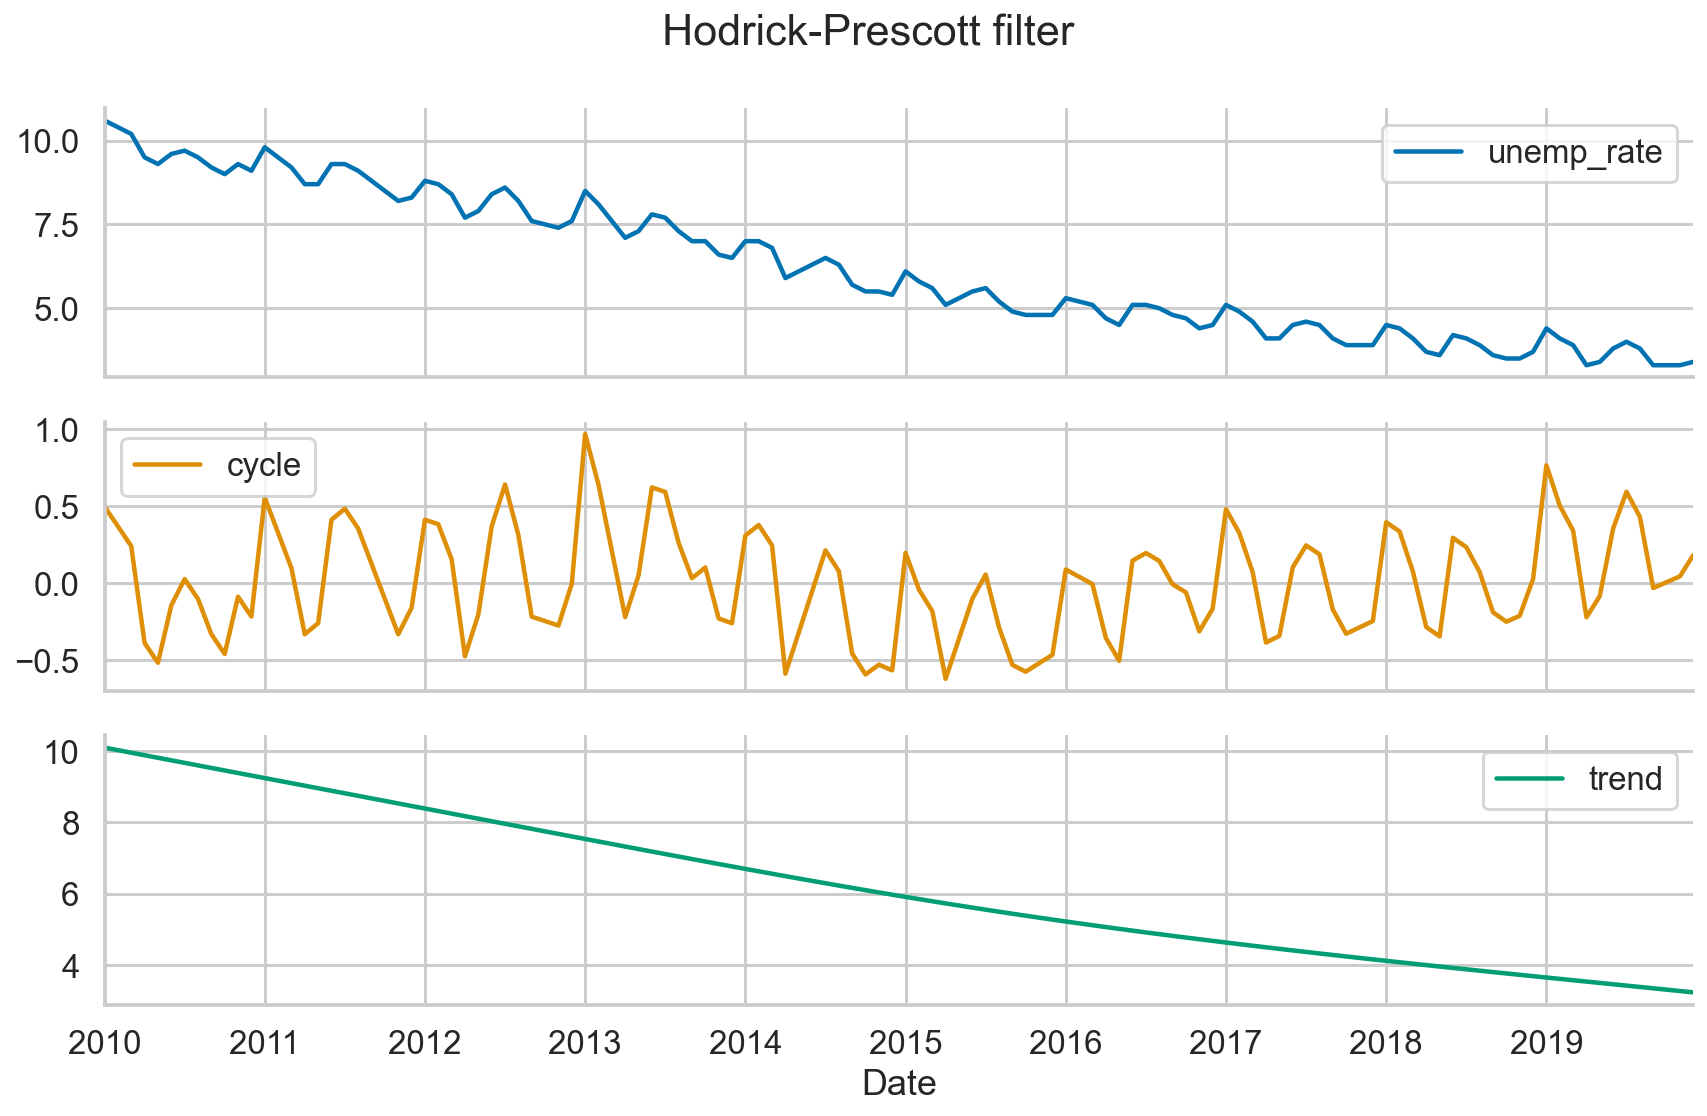

In [11]:
from statsmodels.tsa.filters.hp_filter import hpfilter

hp_df = df[["unemp_rate"]].copy()
hp_df["cycle"], hp_df["trend"] = hpfilter(hp_df["unemp_rate"], 129600)
hp_df.plot(subplots=True, title="Hodrick-Prescott filter")

sns.despine()
plt.tight_layout()

## 6.2 Testing for stationarity in time series

### Getting ready

1. Import the libraries and authenticate:

In [12]:
import pandas as pd
import nasdaqdatalink

nasdaqdatalink.ApiConfig.api_key = "YOUR_KEY_HERE"

2. Download the monthly US unemployment rate from years 2010-2019:

In [13]:
df = (
    nasdaqdatalink.get(dataset="FRED/UNRATENSA", 
                       start_date="2010-01-01", 
                       end_date="2019-12-31")
    .rename(columns={"Value": "unemp_rate"})
)
df.head()

unemp_rate
Date                  
2010-01-01        10.6
2010-02-01        10.4
2010-03-01        10.2
2010-04-01         9.5
2010-05-01         9.3

### How to do it...

1. Import the libraries:

In [14]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

2. Define a function for running the ADF test:

In [15]:
def adf_test(x):
    """
    Function for performing the Augmented Dickey-Fuller test for stationarity
    
    Null Hypothesis: time series is not stationary
    Alternate Hypothesis: time series is stationary

    Parameters
    ----------
    x : pd.Series / np.array
        The time series to be checked for stationarity
    
    Returns
    -------
    results: pd.DataFrame
        A DataFrame with the ADF test's results
    """
    
    indices = ["Test Statistic", "p-value",
               "# of Lags Used", "# of Observations Used"]
    
    adf_test = adfuller(x, autolag="AIC")
    results = pd.Series(adf_test[0:4], index=indices)
    
    for key, value in adf_test[4].items():
        results[f"Critical Value ({key})"] = value

    return results


In [16]:
adf_test(df["unemp_rate"])

Test Statistic             -2.053411
p-value                     0.263656
# of Lags Used             12.000000
# of Observations Used    107.000000
Critical Value (1%)        -3.492996
Critical Value (5%)        -2.888955
Critical Value (10%)       -2.581393
dtype: float64

3. Define a function for running the KPSS test:

In [17]:
def kpss_test(x, h0_type="c"):
    """
    Function for performing the Kwiatkowski-Phillips-Schmidt-Shin test for stationarity

    Null Hypothesis: time series is stationary
    Alternate Hypothesis: time series is not stationary

    Parameters
    ----------
    x: pd.Series / np.array
        The time series to be checked for stationarity
    h0_type: str{"c", "ct"}
        Indicates the null hypothesis of the KPSS test:
            * "c": The data is stationary around a constant(default)
            * "ct": The data is stationary around a trend
    
    Returns
    -------
    results: pd.DataFrame
        A DataFrame with the KPSS test's results
    """
    
    indices = ["Test Statistic", "p-value", "# of Lags"]

    kpss_test = kpss(x, regression=h0_type)
    results = pd.Series(kpss_test[0:3], index=indices)
    
    for key, value in kpss_test[3].items():
        results[f"Critical Value ({key})"] = value

    return results

In [18]:
kpss_test(df["unemp_rate"])

/opt/homebrew/Caskroom/miniforge/base/envs/pff2/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Test Statistic           1.799224
p-value                  0.010000
# of Lags                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

4. Generate the ACF/PACF plots:

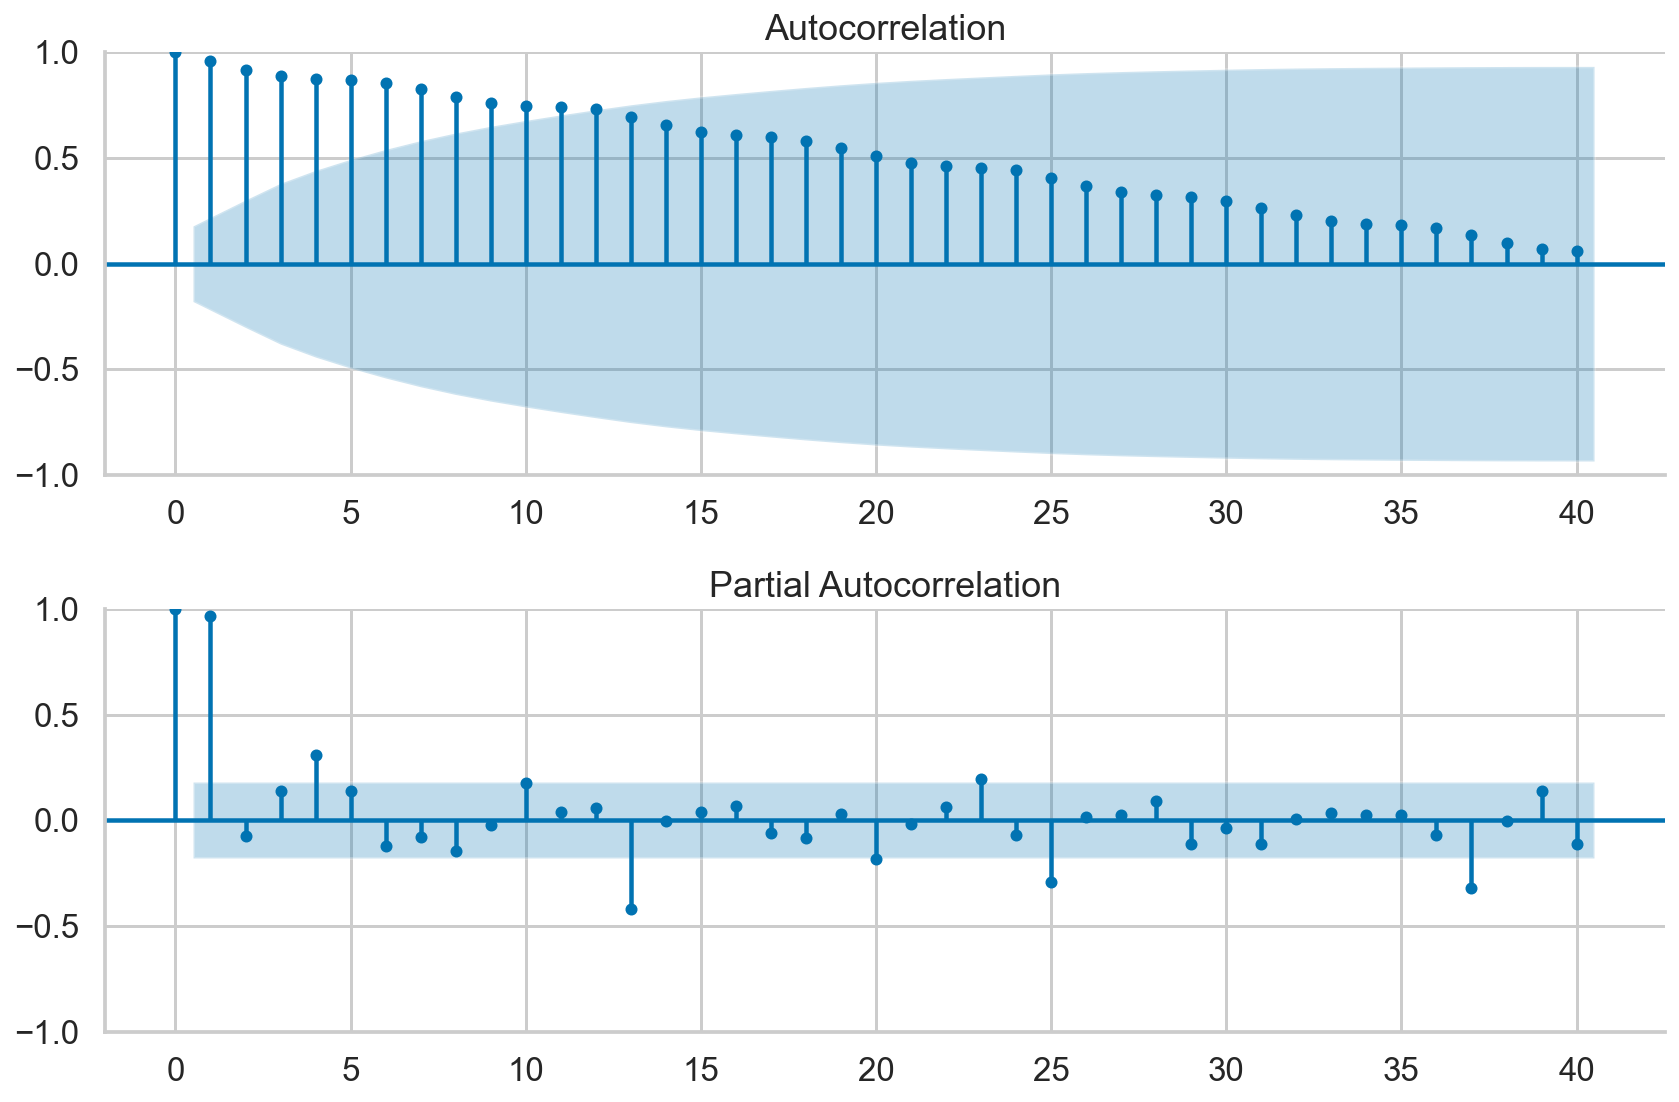

In [19]:
N_LAGS = 40
SIGNIFICANCE_LEVEL = 0.05

fig, ax = plt.subplots(2, 1)
plot_acf(df["unemp_rate"], ax=ax[0], lags=N_LAGS, 
         alpha=SIGNIFICANCE_LEVEL)
plot_pacf(df["unemp_rate"], ax=ax[1], lags=N_LAGS, 
          alpha=SIGNIFICANCE_LEVEL)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_7", dpi=200)

### There's more

1. Carry out the ADF test using the `arch` library:

In [19]:
from arch.unitroot import ADF
adf = ADF(df["unemp_rate"])
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.053
P-value                         0.264
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.49 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


2. Carry out the Zivot-Andrews test using the `arch` library:

In [20]:
from arch.unitroot import ZivotAndrews
za = ZivotAndrews(df["unemp_rate"])
print(za.summary().as_text())

        Zivot-Andrews Results        
Test Statistic                 -2.551
P-value                         0.982
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary.


## 6.3 Correcting for stationarity in time series

### How to do it...

1. Import the libraries, authenticate and update the inflation data:

In [3]:
import pandas as pd
import numpy as np
import nasdaqdatalink
import cpi
from datetime import date
from chapter_6_utils import test_autocorrelation

nasdaqdatalink.ApiConfig.api_key = "YOUR_KEY_HERE"

# update the CPI data (if needed)
# cpi.update()

/opt/homebrew/Caskroom/miniforge/base/envs/pff2/lib/python3.9/site-packages/cpi/__init__.py:46: StaleDataWarning: CPI data is out of date. To accurately inflate to today's dollars, you must run `cpi.update()`.
  warnings.warn(StaleDataWarning())


2. Download the prices of gold for 2000-2010 and resample to monthly values:

In [4]:
df = (
    nasdaqdatalink.get(dataset="WGC/GOLD_MONAVG_USD", 
                       start_date="2000-01-01", 
                       end_date="2010-12-31")
    .rename(columns={"Value": "price"})
    .resample("M")
    .last()
)

df.head()

price
Date              
2000-01-31  284.31
2000-02-29  299.86
2000-03-31  286.39
2000-04-30  279.69
2000-05-31  275.19

As a confirmation, we can check if the series is stationary -> it is not.

ADF test statistic: 2.41 (p-val: 1.00)
KPSS test statistic: 1.84 (p-val: 0.01)


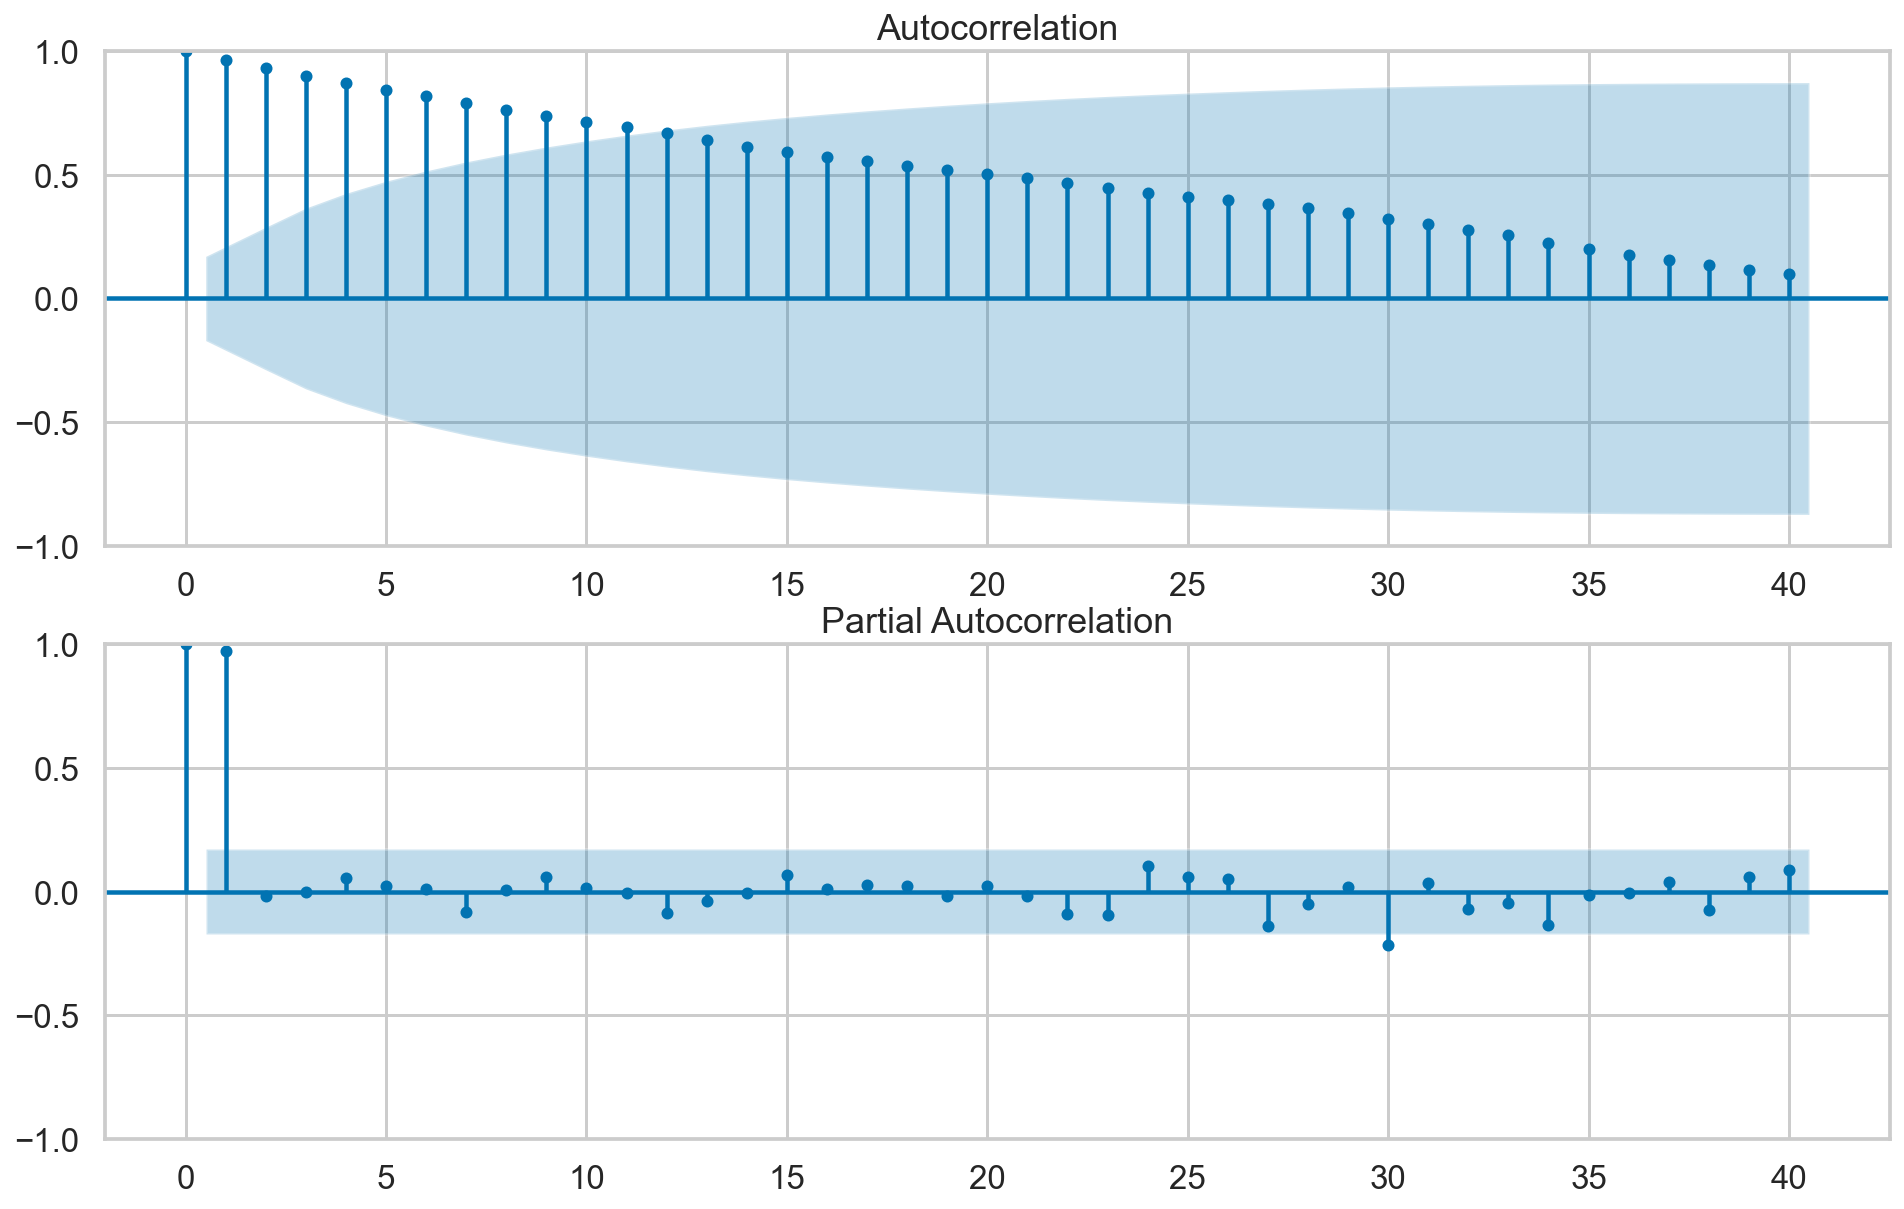

In [5]:
fig = test_autocorrelation(df["price"])

3. Deflate the gold prices (to 2010-12-31 USD values) and plot the results:

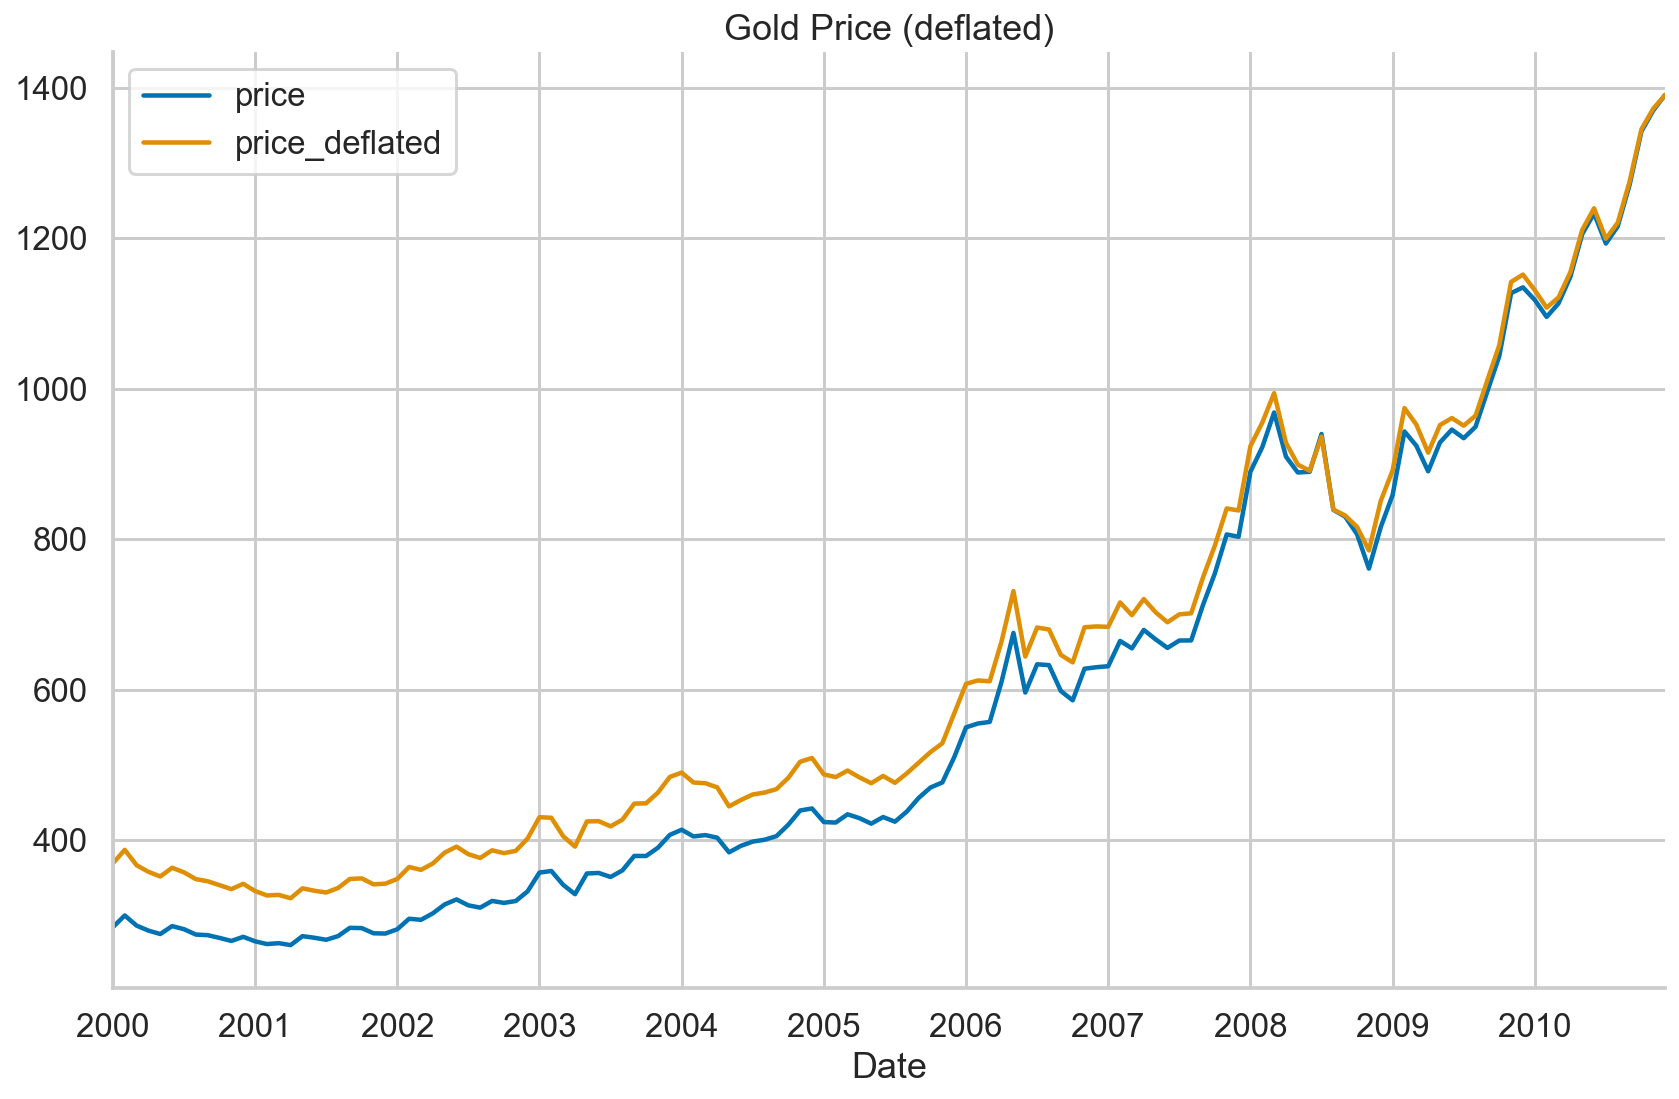

In [6]:
DEFL_DATE = date(2010, 12, 31)

df["dt_index"] = pd.to_datetime(df.index)
df["price_deflated"] = df.apply(
    lambda x: cpi.inflate(x["price"], x["dt_index"], DEFL_DATE), 
    axis=1
)

(
    df.loc[:, ["price", "price_deflated"]]
    .plot(title="Gold Price (deflated)")
)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_8", dpi=200)

4. Apply the natural logarithm to the deflated series and plot it together with the rolling metrics:

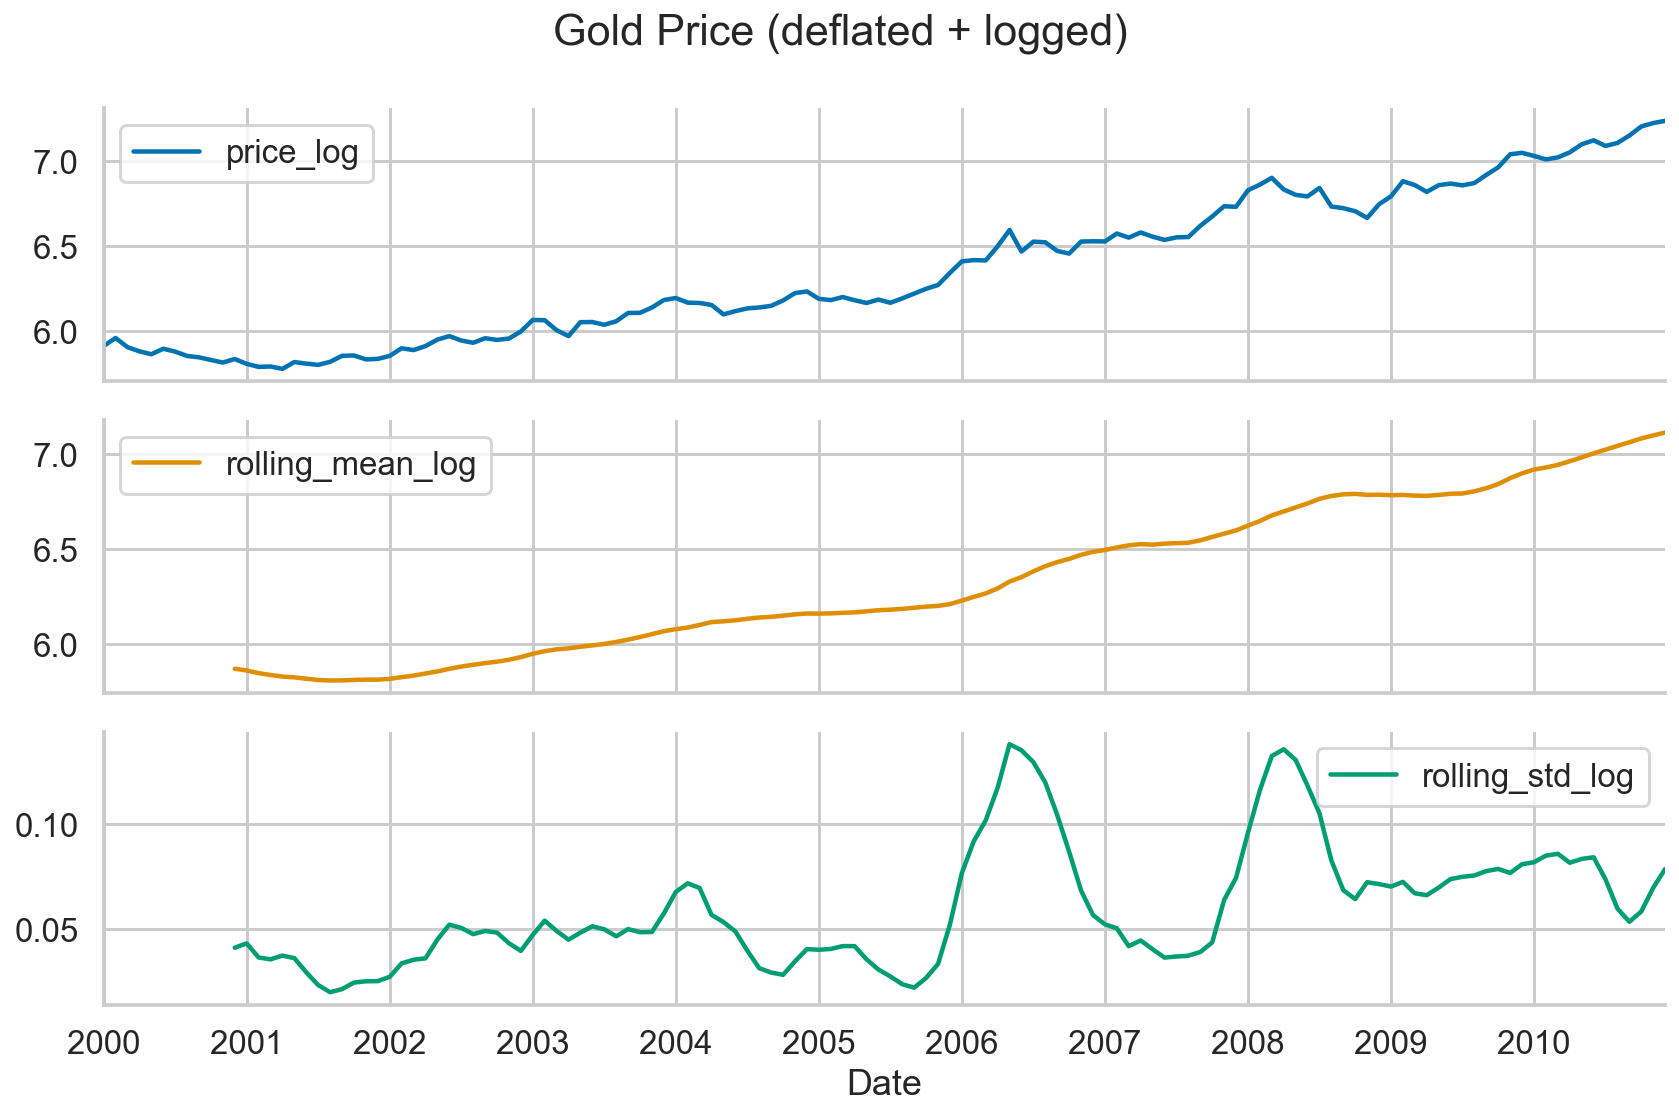

In [7]:
WINDOW = 12
selected_columns = ["price_log", "rolling_mean_log", 
                    "rolling_std_log"]

df["price_log"] = np.log(df.price_deflated)
df["rolling_mean_log"] = df.price_log.rolling(WINDOW) \
                           .mean()
df["rolling_std_log"] = df.price_log.rolling(WINDOW) \
                          .std()

(
    df[selected_columns]
    .plot(title="Gold Price (deflated + logged)", 
          subplots=True)
)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_9", dpi=200)

5. Use the `test_autocorrelation` (helper function for this chapter) to investigate if the series became stationary:

ADF test statistic: 1.04 (p-val: 0.99)
KPSS test statistic: 1.93 (p-val: 0.01)


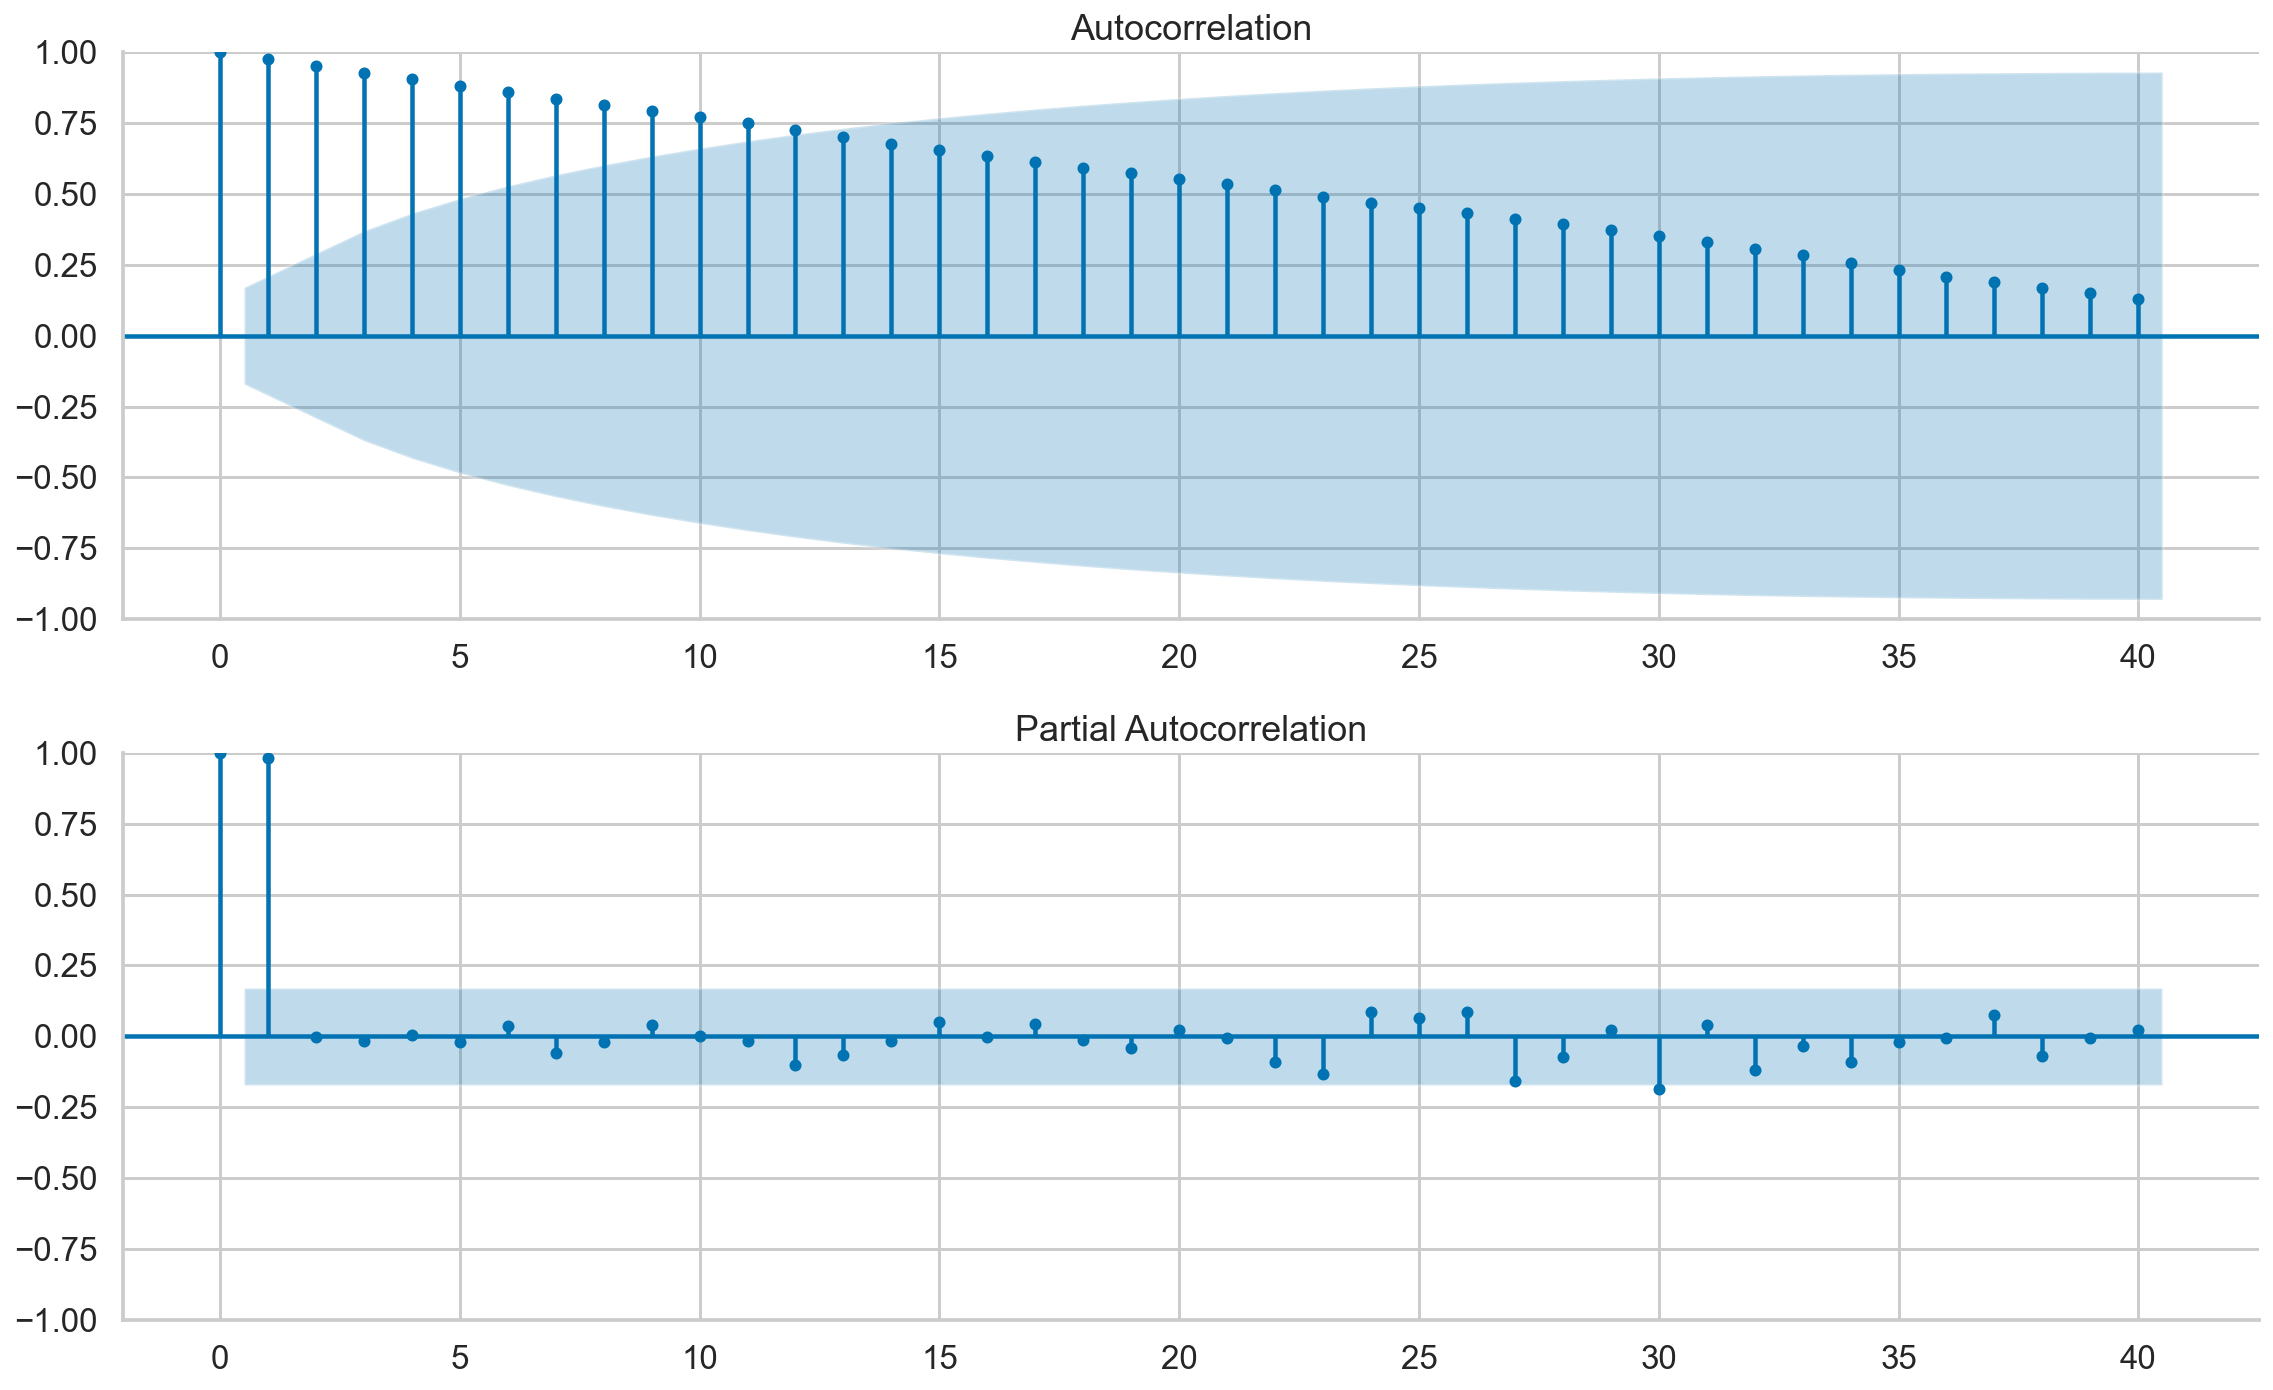

In [8]:
fig = test_autocorrelation(df["price_log"])

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_10", dpi=200)

6. Apply differencing to the series and plot the results:

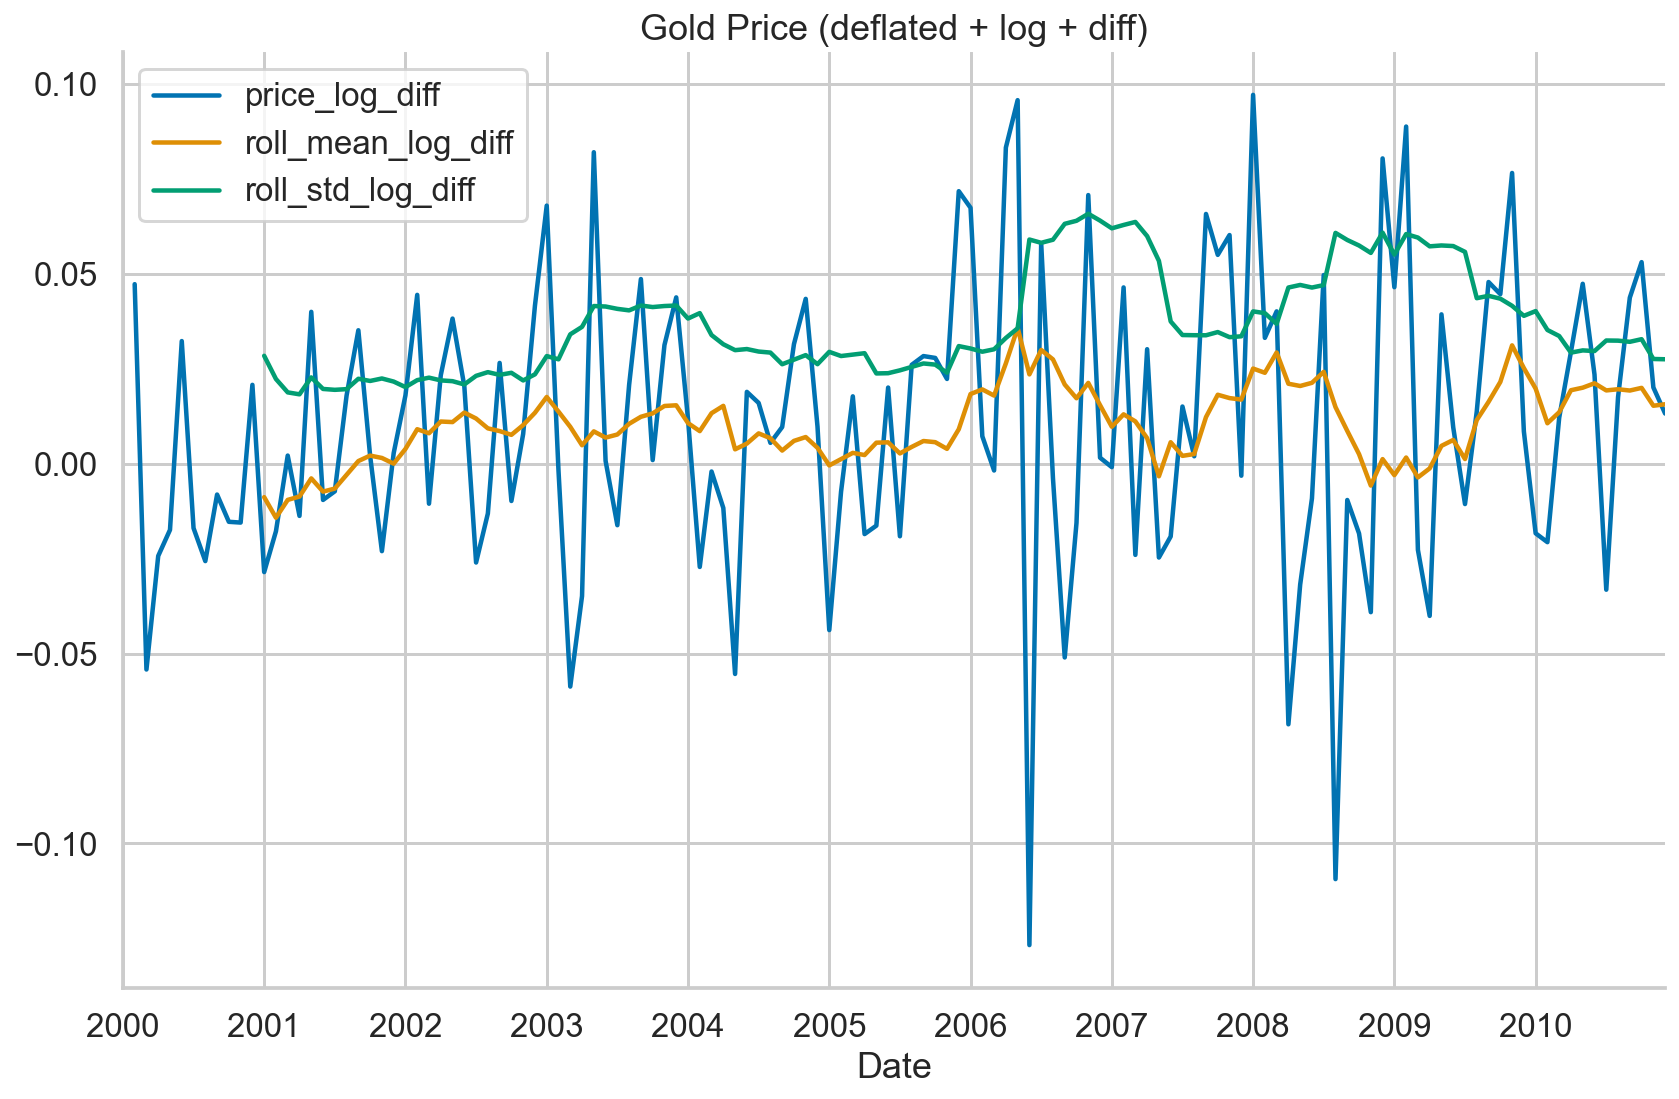

In [26]:
selected_columns = ["price_log_diff", "roll_mean_log_diff", 
                    "roll_std_log_diff"]

df["price_log_diff"] = df.price_log.diff(1)
df["roll_mean_log_diff"] = df.price_log_diff.rolling(WINDOW) \
                             .mean()
df["roll_std_log_diff"] = df.price_log_diff.rolling(WINDOW) \
                            .std()
df[selected_columns].plot(title="Gold Price (deflated + log + diff)")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_11", dpi=200)

7. Test if the series became stationary:

ADF test statistic: -10.87 (p-val: 0.00)
KPSS test statistic: 0.30 (p-val: 0.10)


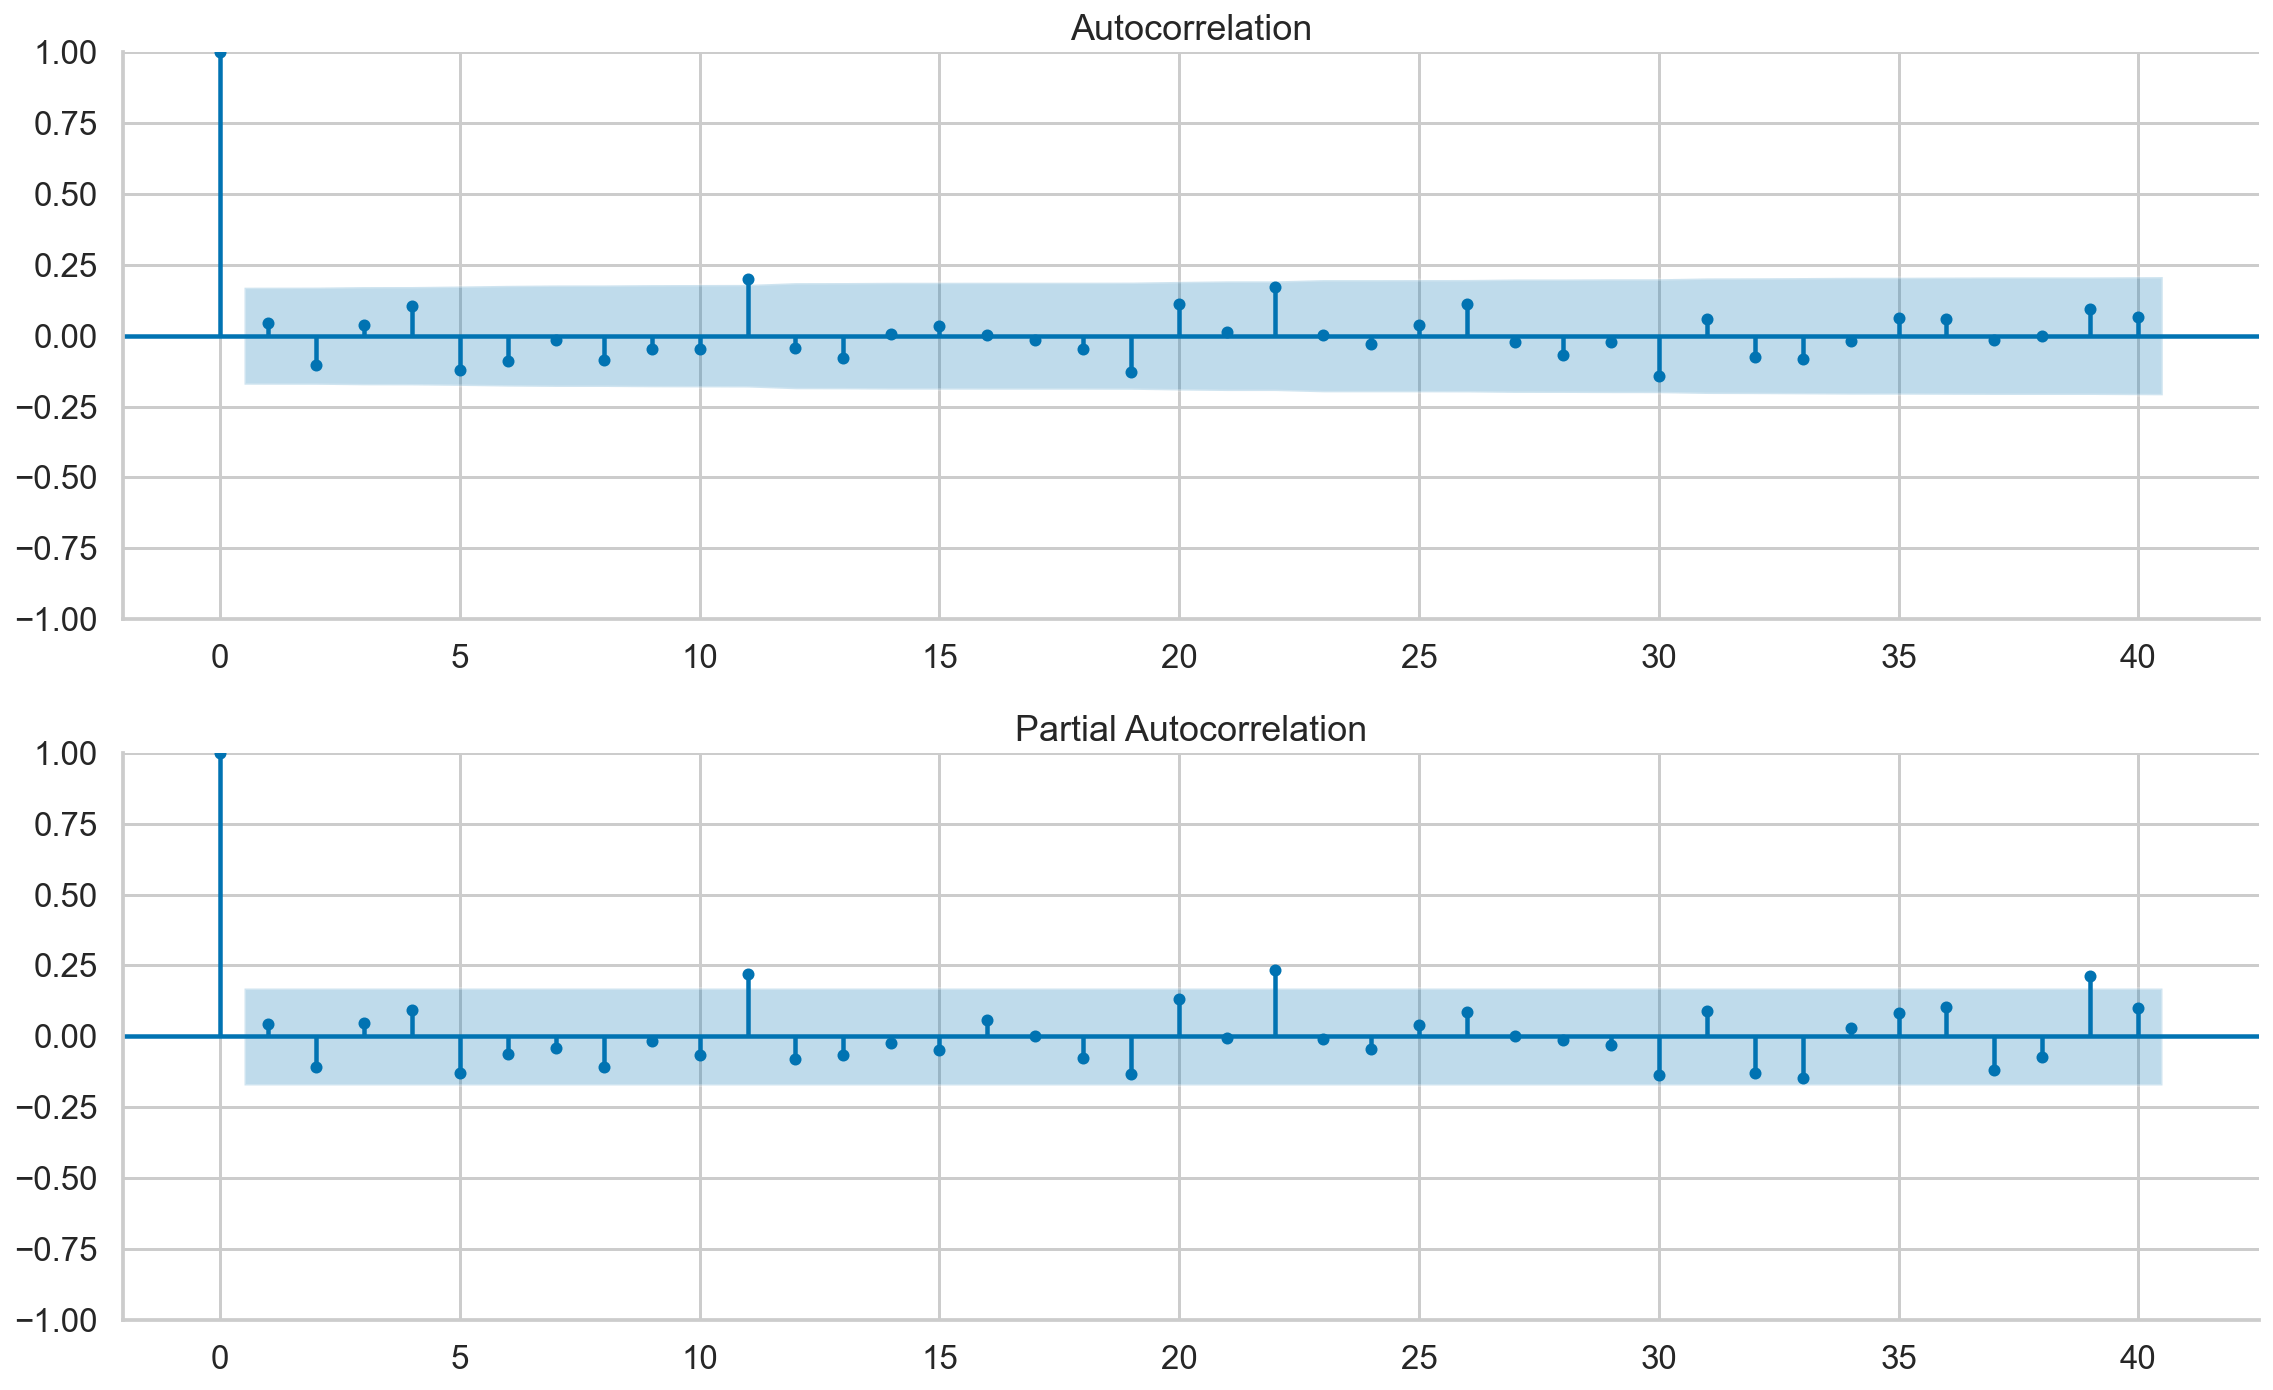

In [27]:
fig = test_autocorrelation(df["price_log_diff"].dropna())

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_12", dpi=200)

### There's more

In [29]:
from pmdarima.arima import ndiffs, nsdiffs

In [30]:
print(f"Suggested # of differences (ADF): {ndiffs(df['price'], test='adf')}")
print(f"Suggested # of differences (KPSS): {ndiffs(df['price'], test='kpss')}")
print(f"Suggested # of differences (PP): {ndiffs(df['price'], test='pp')}")

Suggested # of differences (ADF): 1
Suggested # of differences (KPSS): 2
Suggested # of differences (PP): 1


In [31]:
print(f"Suggested # of differences (OSCB): {nsdiffs(df['price'], m=12, test='ocsb')}")
print(f"Suggested # of differences (CH): {nsdiffs(df['price'], m=12, test='ch')}")

Suggested # of differences (OSCB): 0
Suggested # of differences (CH): 0


## 6.4 Modeling time series with exponential smoothing methods

### Getting ready

1. Import the libraries and authenticate:

In [3]:
import pandas as pd
import nasdaqdatalink

nasdaqdatalink.ApiConfig.api_key = "YOUR_KEY_HERE"

2. Download the monthly US unemployment rate from years 2010-2019:

In [4]:
df = (
    nasdaqdatalink.get(dataset="FRED/UNRATENSA", 
                       start_date="2010-01-01", 
                       end_date="2019-12-31")
    .rename(columns={"Value": "unemp_rate"})
)
df.head()

unemp_rate
Date                  
2010-01-01        10.6
2010-02-01        10.4
2010-03-01        10.2
2010-04-01         9.5
2010-05-01         9.3

### How to do it...

1. Import the libraries:

In [5]:
import pandas as pd
from datetime import date
from statsmodels.tsa.holtwinters import (ExponentialSmoothing, 
                                         SimpleExpSmoothing, 
                                         Holt)

2. Create the train/test split:

In [6]:
TEST_LENGTH = 12

df.index.freq = "MS"

df_train = df.iloc[:-TEST_LENGTH]
df_test = df.iloc[-TEST_LENGTH:]

3. Fit 2 Simple Exponential Smoothing models and create forecasts:

In [7]:
ses_1 = SimpleExpSmoothing(df_train).fit(smoothing_level=0.5)
ses_forecast_1 = ses_1.forecast(TEST_LENGTH)

ses_2 = SimpleExpSmoothing(df_train).fit()
ses_forecast_2 = ses_2.forecast(TEST_LENGTH)

ses_1.params_formatted

name      param  optimized
smoothing_level  alpha   0.500000      False
initial_level      l.0  10.358112       True

In [8]:
ses_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       SimpleExpSmoothing Model Results                       
==============================================================================
Dep. Variable:             unemp_rate   No. Observations:                  108
Model:             SimpleExpSmoothing   SSE                             15.032
Optimized:                       True   AIC                           -208.973
Trend:                           None   BIC                           -203.609
Seasonal:                        None   AICC                          -208.584
Seasonal Periods:                None   Date:                 Tue, 20 Sep 2022
Box-Cox:                        False   Time:                         20:25:10
Box-Cox Coeff.:                  None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.5000000                alpha                False
initial_level              10.358112                  l.0                 True
------------------------------------------------------------------------------
"""

4. Combine the forecasts with the fitted values and plot them:

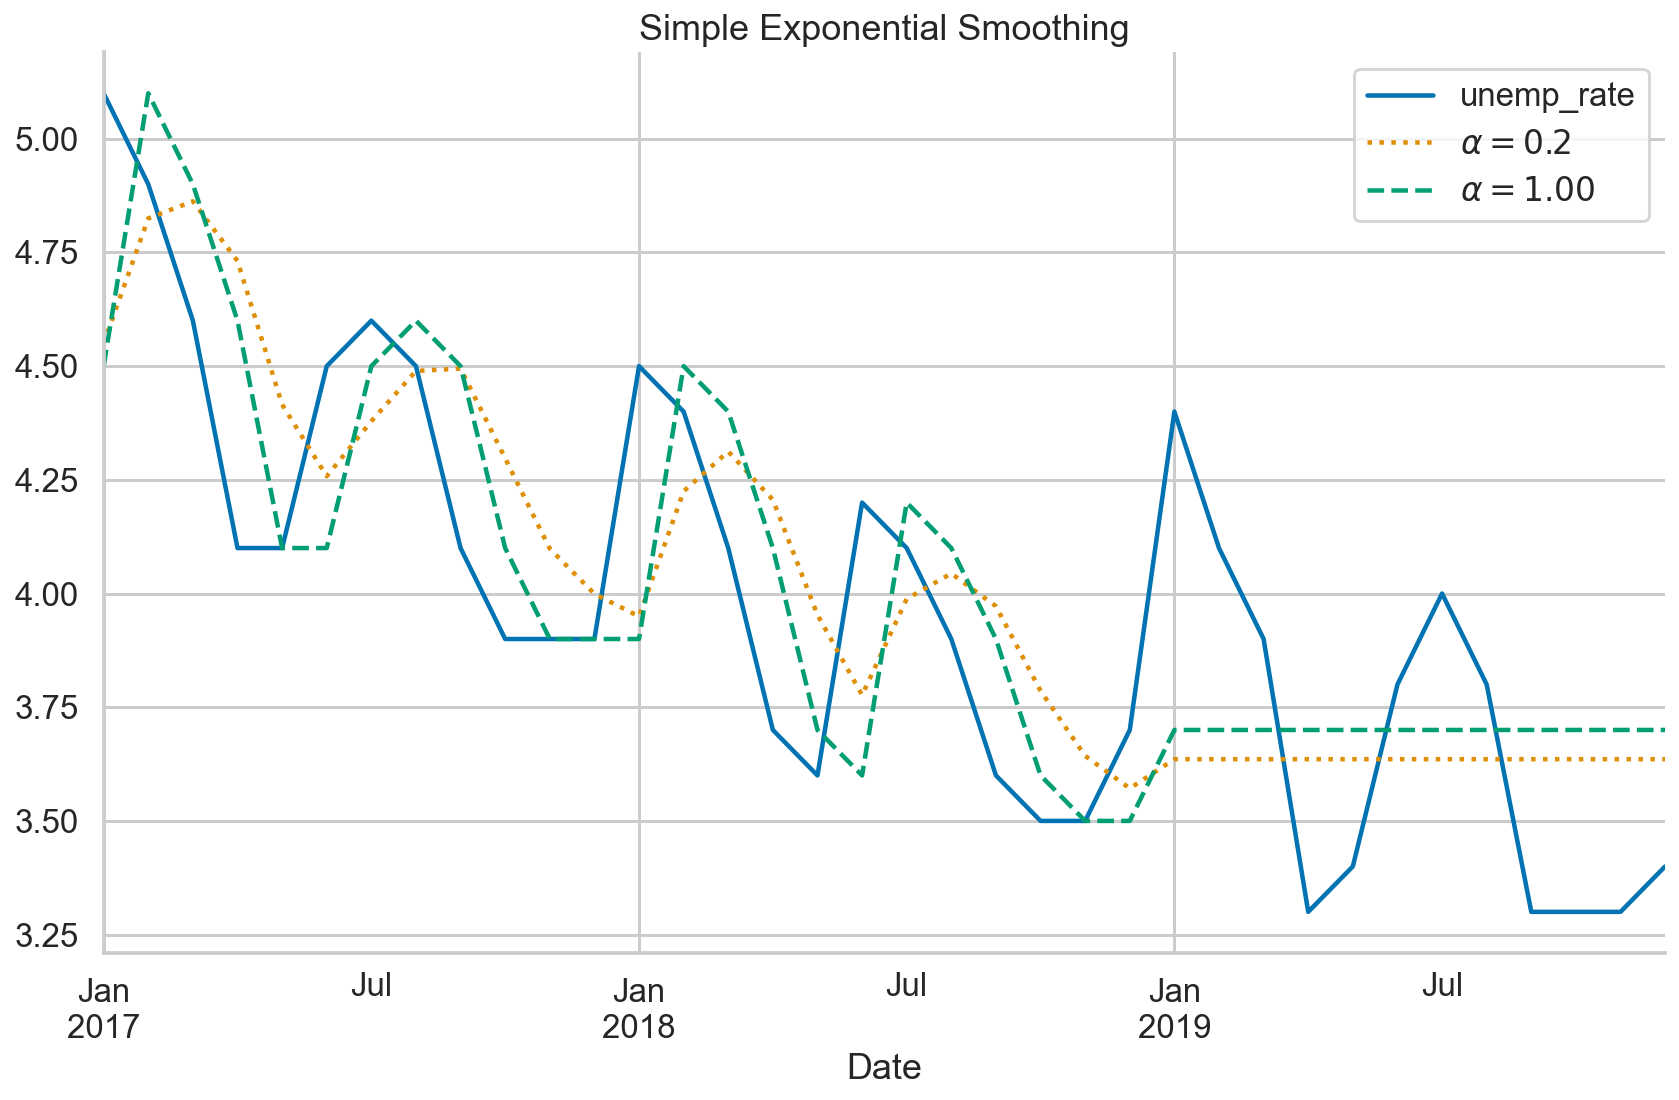

In [9]:
ses_df = df.copy()
ses_df["ses_1"] = ses_1.fittedvalues.append(ses_forecast_1)
ses_df["ses_2"] = ses_2.fittedvalues.append(ses_forecast_2)

opt_alpha = ses_2.model.params["smoothing_level"]

fig, ax = plt.subplots()
ses_df["2017":].plot(style=["-",":","--"], ax=ax,
                     title="Simple Exponential Smoothing")
labels = [
    "unemp_rate", 
    r"$\alpha=0.2$",
    r'$\alpha={0:.2f}$'.format(opt_alpha), 
]
ax.legend(labels)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_13", dpi=200)

5. Fit 3 variants of Holt's linear trend models and create forecasts:

In [10]:
# Holt's model with linear trend
hs_1 = Holt(df_train).fit()
hs_forecast_1 = hs_1.forecast(TEST_LENGTH)

# Holt's model with exponential trend
hs_2 = Holt(df_train, exponential=True).fit()
# equivalent to ExponentialSmoothing(df_train, trend="mul").fit()
hs_forecast_2 = hs_2.forecast(TEST_LENGTH)

# Holt's model with exponential trend and damping
hs_3 = Holt(df_train, exponential=False, 
            damped_trend=True).fit()
hs_forecast_3 = hs_3.forecast(TEST_LENGTH)

In [11]:
hs_3.params_formatted

name         param  optimized
smoothing_level  alpha  1.000000e+00       True
smoothing_trend   beta  2.128715e-15       True
initial_level      l.0  1.070994e+01       True
initial_trend      b.0 -1.102250e-01       True
damping_trend      phi  9.890185e-01       True

6. Plot the original series together with the models' forecasts:

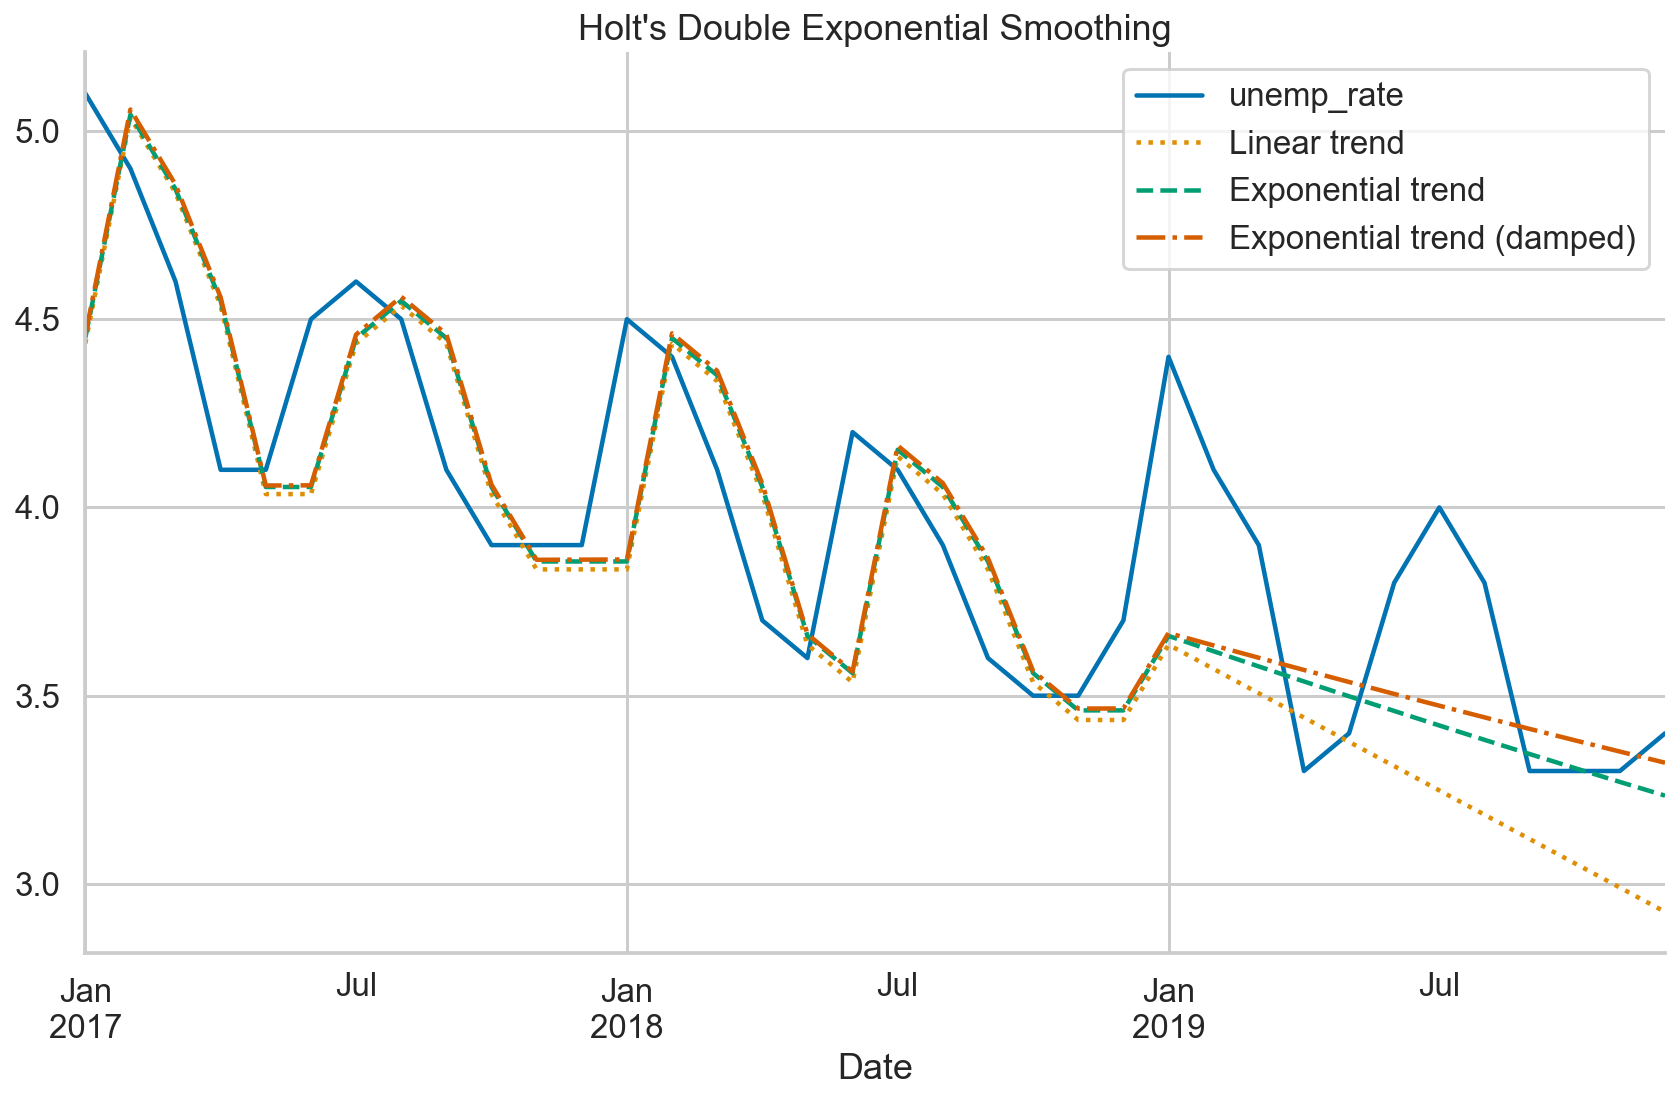

In [12]:
hs_df = df.copy()
hs_df["hs_1"] = hs_1.fittedvalues.append(hs_forecast_1)
hs_df["hs_2"] = hs_2.fittedvalues.append(hs_forecast_2)
hs_df["hs_3"] = hs_3.fittedvalues.append(hs_forecast_3)

fig, ax = plt.subplots()
hs_df["2017":].plot(style=["-",":","--", "-."], ax=ax,
                    title="Holt's Double Exponential Smoothing")
labels = [
    "unemp_rate", 
    "Linear trend",
    "Exponential trend",
    "Exponential trend (damped)",
]
ax.legend(labels)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_14", dpi=200)

7. Fit 2 variants of Holt-Winter's Triple Exponential Smoothing models and create forecasts:

In [13]:
SEASONAL_PERIODS = 12

# Holt-Winters' model with exponential trend
hw_1 = ExponentialSmoothing(df_train, 
                            trend="mul", 
                            seasonal="add", 
                            seasonal_periods=SEASONAL_PERIODS).fit()
hw_forecast_1 = hw_1.forecast(TEST_LENGTH)

# Holt-Winters' model with exponential trend and damping
hw_2 = ExponentialSmoothing(df_train, 
                            trend="mul", 
                            seasonal="add", 
                            seasonal_periods=SEASONAL_PERIODS, 
                            damped_trend=True).fit()
hw_forecast_2 = hw_2.forecast(TEST_LENGTH)

In [14]:
hw_2.params_formatted

name     param  optimized
smoothing_level     alpha  0.632914       True
smoothing_trend      beta  0.000000       True
smoothing_seasonal  gamma  0.000000       True
initial_level         l.0  8.211104       True
initial_trend         b.0  1.009635       True
damping_trend         phi  0.972792       True
initial_seasons.0     s.0  2.528940       True
initial_seasons.1     s.1  2.399946       True
initial_seasons.2     s.2  2.192994       True
initial_seasons.3     s.3  1.685719       True
initial_seasons.4     s.4  1.778273       True
initial_seasons.5     s.5  2.270615       True
initial_seasons.6     s.6  2.384962       True
initial_seasons.7     s.7  2.198943       True
initial_seasons.8     s.8  1.890412       True
initial_seasons.9     s.9  1.803739       True
initial_seasons.10   s.10  1.772307       True
initial_seasons.11   s.11  1.851504       True

8. Plot the original series together with the models' results:

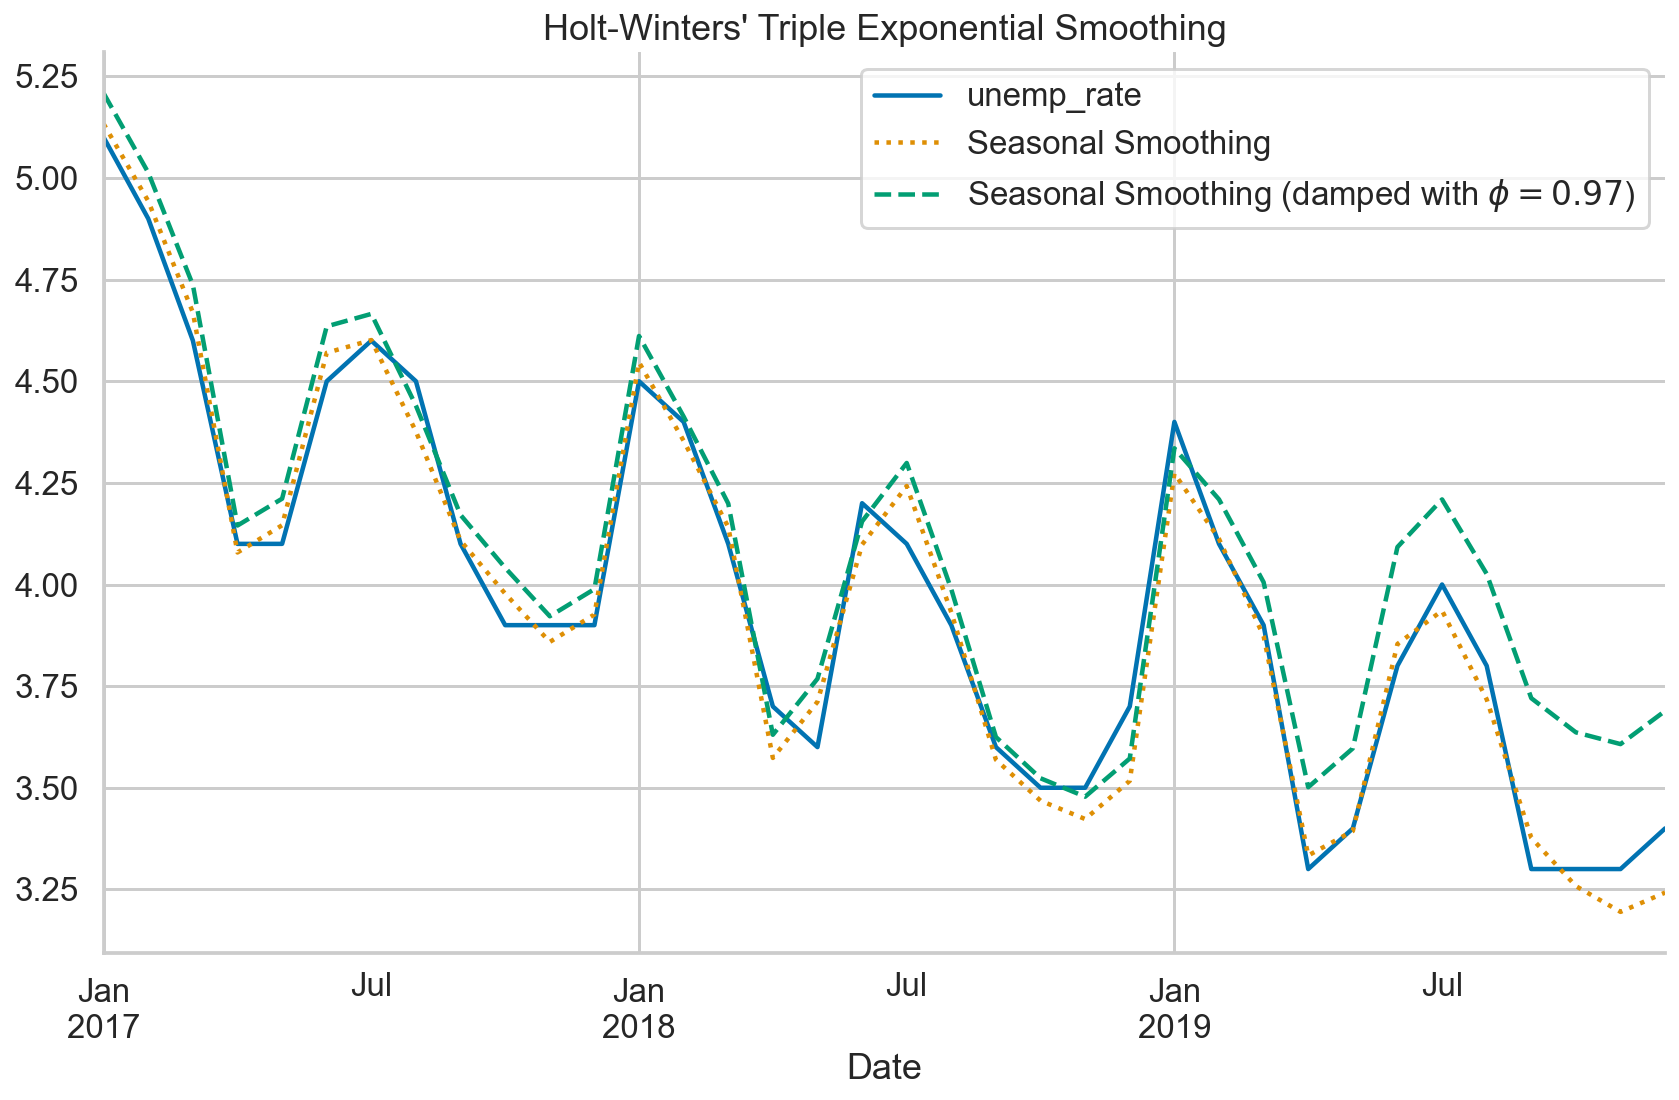

In [15]:
hw_df = df.copy()
hw_df["hw_1"] = hw_1.fittedvalues.append(hw_forecast_1)
hw_df["hw_2"] = hw_2.fittedvalues.append(hw_forecast_2)

fig, ax = plt.subplots()
hw_df["2017":].plot(
    style=["-",":","--"], ax=ax,
    title="Holt-Winters' Triple Exponential Smoothing"
)
phi = hw_2.model.params["damping_trend"]

labels = [
    "unemp_rate", 
    "Seasonal Smoothing",
    f"Seasonal Smoothing (damped with $\phi={phi:.2f}$)"
]
ax.legend(labels)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_15", dpi=200)

### There's more

1. Import the libraries:

In [16]:
from sktime.forecasting.ets import AutoETS
from sklearn.metrics import mean_absolute_percentage_error

2. Fit the `AutoETS` model:

In [17]:
auto_ets = AutoETS(auto=True, n_jobs=-1, sp=12)
auto_ets.fit(df_train.to_period())
auto_ets_fcst = auto_ets.predict(fh=list(range(1, 13)))


In [18]:
auto_ets.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:                      ETS(MAdA)   Log Likelihood                  67.065
Date:                Tue, 20 Sep 2022   AIC                            -96.130
Time:                        20:25:25   BIC                            -45.169
Sample:                    01-31-2010   HQIC                           -75.467
                         - 12-31-2018   Scale                            0.000
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.6208      0.094      6.611      0.000       0.437       0.805
smoothing_trend         0.0204        nan        nan        nan         nan         nan
smoothing_seasonal   3.792e-05        nan        nan        nan         nan         nan
damping_trend           0.9800        nan        nan        nan         nan         nan
initial_level          10.7176   1040.117      0.010      0.992   -2027.875    2049.310
initial_trend          -0.1119      0.043     -2.577      0.010      -0.197      -0.027
initial_seasonal.0     -0.6403   1040.117     -0.001      1.000   -2039.233    2037.952
initial_seasonal.1     -0.7357   1040.117     -0.001      0.999   -2039.328    2037.857
initial_seasonal.2     -0.7085   1040.117     -0.001      0.999   -2039.301    2037.884
initial_seasonal.3     -0.6170   1040.117     -0.001      1.000   -2039.209    2037.976
initial_seasonal.4     -0.3149   1040.117     -0.000      1.000   -2038.907    2038.278
initial_seasonal.5     -0.1465   1040.117     -0.000      1.000   -2038.739    2038.446
initial_seasonal.6     -0.2301   1040.117     -0.000      1.000   -2038.823    2038.362
initial_seasonal.7     -0.7316   1040.117     -0.001      0.999   -2039.324    2037.861
initial_seasonal.8     -0.7838   1040.117     -0.001      0.999   -2039.376    2037.809
initial_seasonal.9     -0.3214   1040.117     -0.000      1.000   -2038.914    2038.271
initial_seasonal.10    -0.1175   1040.117     -0.000      1.000   -2038.710    2038.475
initial_seasonal.11          0   1040.117          0      1.000   -2038.592    2038.592
===================================================================================
Ljung-Box (Q):                       28.47   Jarque-Bera (JB):                 0.18
Prob(Q):                              0.13   Prob(JB):                         0.92
Heteroskedasticity (H):               1.69   Skew:                            -0.04
Prob(H) (two-sided):                  0.12   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

3. Add the model's forecast to the plot of the Holt-Winters' forecasts:

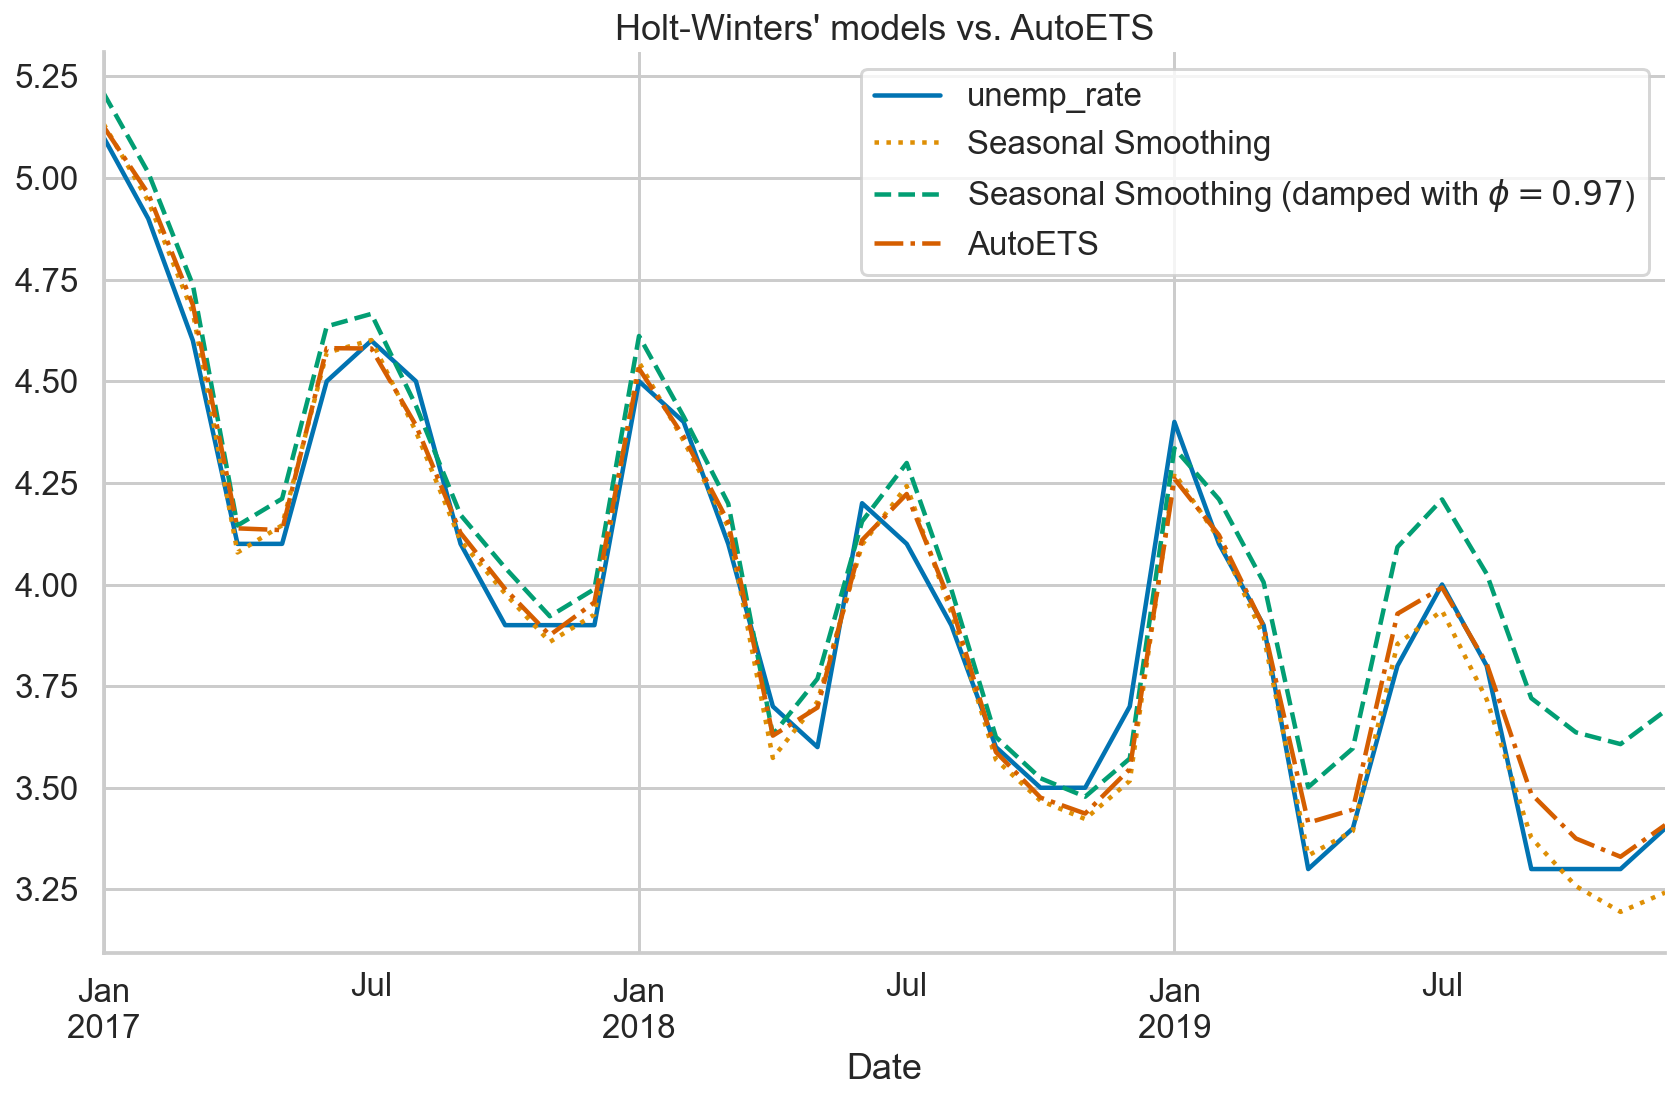

In [21]:
auto_ets_df = hw_df.to_period().copy()
auto_ets_df["auto_ets"] = (
    auto_ets.
    _fitted_forecaster
    .fittedvalues
    .append(auto_ets_fcst["unemp_rate"])
)

fig, ax = plt.subplots()
auto_ets_df["2017":].plot(
    style=["-",":","--","-."], ax=ax,
    title="Holt-Winters' models vs. AutoETS"
)
labels = [
    "unemp_rate", 
    "Seasonal Smoothing",
    f"Seasonal Smoothing (damped with $\phi={phi:.2f}$)",
    "AutoETS",
]
ax.legend(labels)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_16", dpi=200)

4. Calculate the MAPEs of the Holt-Winters' forecasts and the ones from AutoETS:

In [20]:
fcst_dict = {
    "Seasonal Smoothing": hw_forecast_1,
    "Seasonal Smoothing (damped)": hw_forecast_2,
    "AutoETS": auto_ets_fcst,
}

print("MAPEs ----")
for key, value in fcst_dict.items():
    mape = mean_absolute_percentage_error(df_test, value)
    print(f"{key}: {100 * mape:.2f}%")

MAPEs ----
Seasonal Smoothing: 1.81%
Seasonal Smoothing (damped): 6.53%
AutoETS: 1.78%


## 6.5 Modeling time series with ARIMA class models

### Getting ready

1. Import the libraries and authenticate:

In [3]:
import pandas as pd
import nasdaqdatalink

nasdaqdatalink.ApiConfig.api_key = "YOUR_KEY_HERE"

2. Download the monthly US unemployment rate from years 2010-2019:

In [4]:
df = (
    nasdaqdatalink.get(dataset="FRED/UNRATENSA", 
                       start_date="2010-01-01", 
                       end_date="2019-12-31")
    .rename(columns={"Value": "unemp_rate"})
)

# to hide the warnings of `statsmodels`
df.index.freq = "MS"

df.head()

unemp_rate
Date                  
2010-01-01        10.6
2010-02-01        10.4
2010-03-01        10.2
2010-04-01         9.5
2010-05-01         9.3

### How to do it...

1. Import the libraries:

In [5]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from chapter_6_utils import test_autocorrelation
from sklearn.metrics import mean_absolute_percentage_error

2. Create the train/test split:

In [6]:
TEST_LENGTH = 12
df_train = df.iloc[:-TEST_LENGTH]
df_test = df.iloc[-TEST_LENGTH:]

3. Apply the log transformation and calculate the first differences:

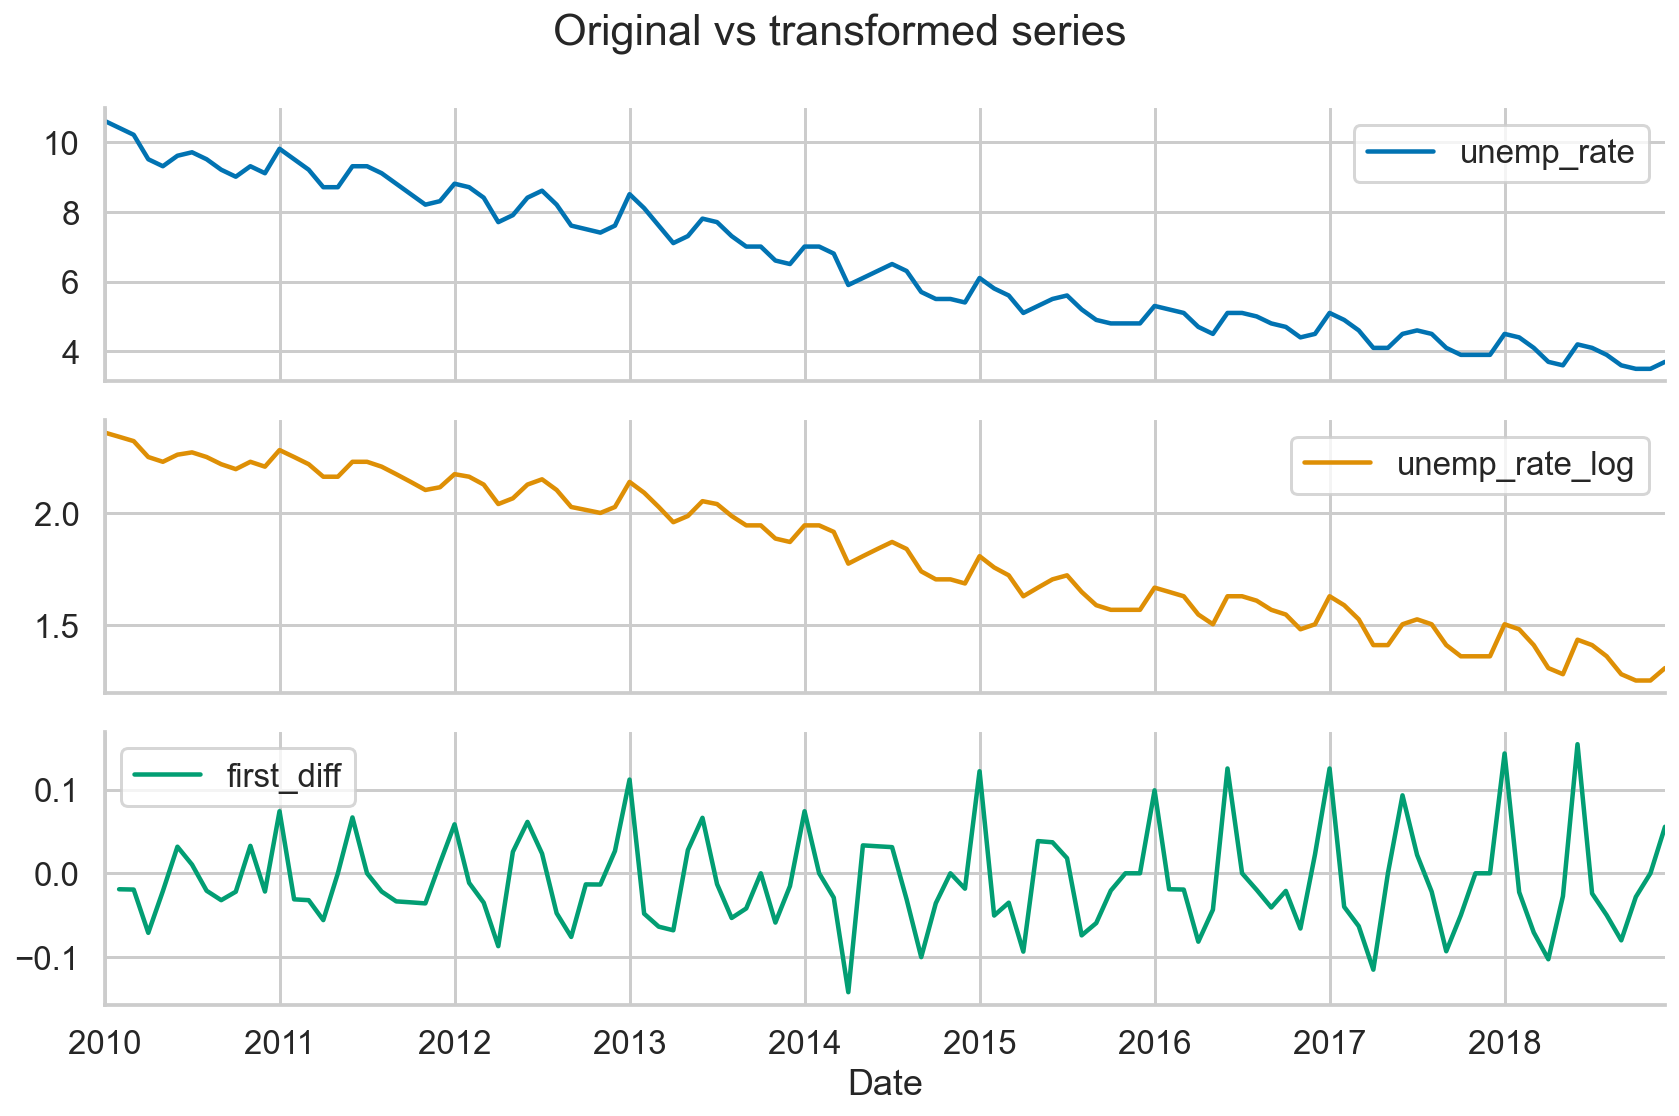

In [7]:
df_train["unemp_rate_log"] = np.log(df_train["unemp_rate"])
df_train["first_diff"] = df_train["unemp_rate_log"].diff()

df_train.plot(subplots=True, 
              title="Original vs transformed series")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_17", dpi=200)

4. Test the stationarity of the differenced series:

ADF test statistic: -2.97 (p-val: 0.04)
KPSS test statistic: 0.04 (p-val: 0.10)


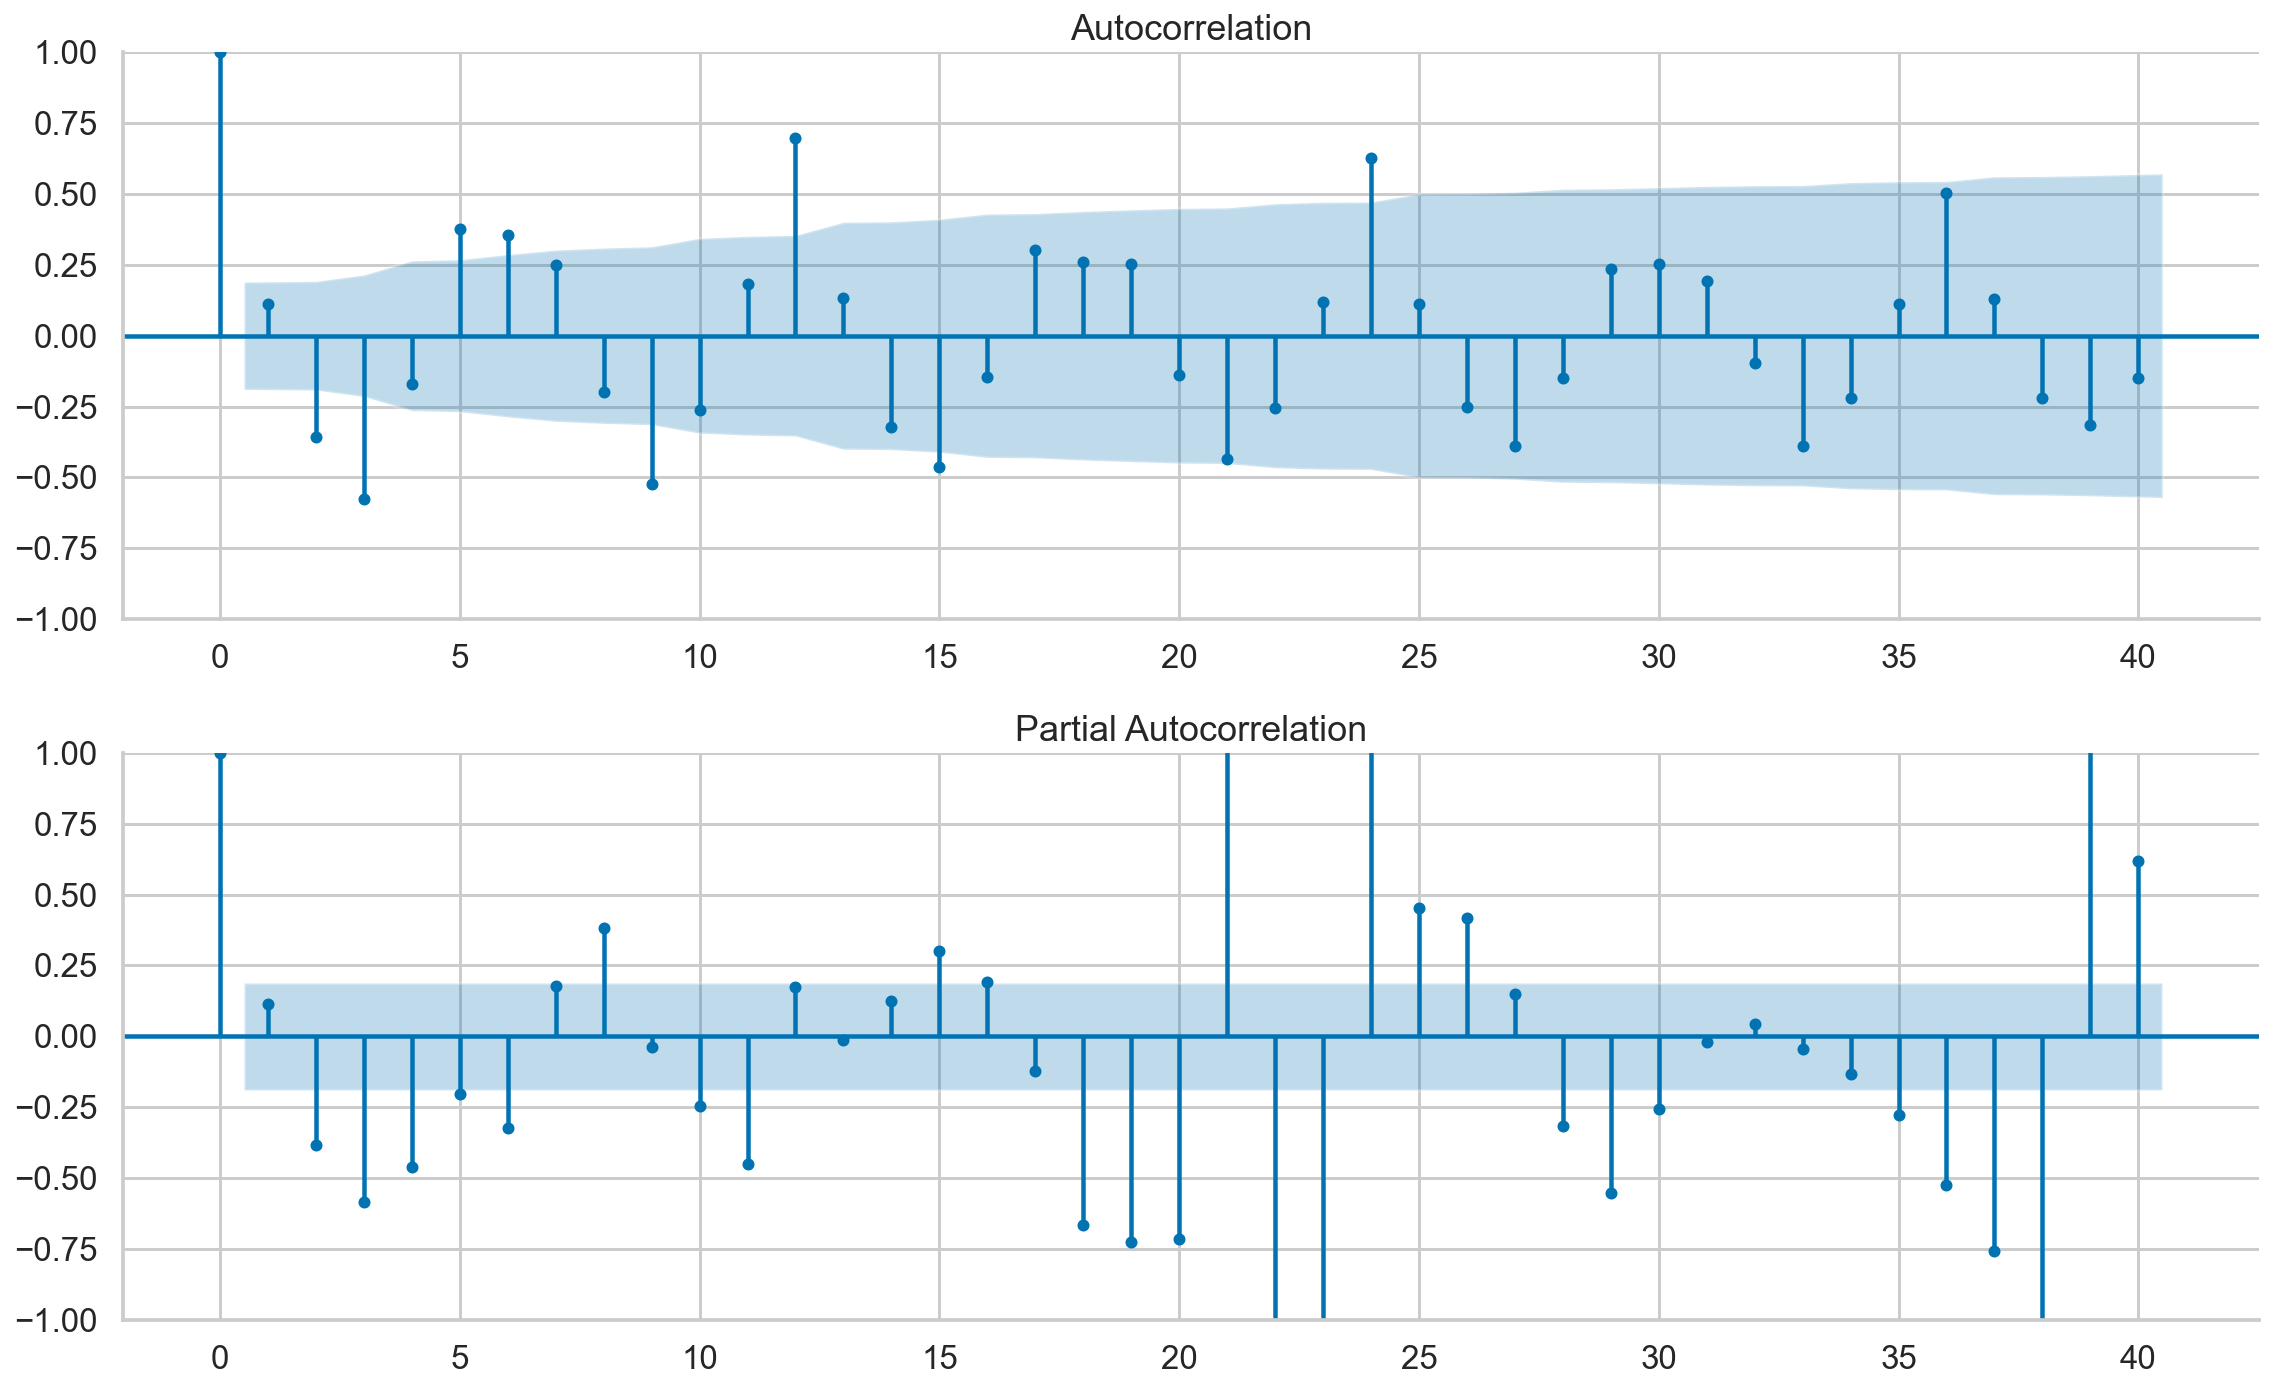

In [8]:
fig = test_autocorrelation(df_train["first_diff"].dropna())

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_18", dpi=200)

5. Fit two different ARIMA models and print their summaries:

In [9]:
arima_111 = ARIMA(
    df_train["unemp_rate_log"], order=(1, 1, 1)
).fit()
arima_111.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         unemp_rate_log   No. Observations:                  108
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 157.020
Date:                Tue, 20 Sep 2022   AIC                           -308.040
Time:                        20:57:48   BIC                           -300.021
Sample:                    01-01-2010   HQIC                          -304.789
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5541      0.401      1.381      0.167      -0.232       1.340
ma.L1         -0.7314      0.306     -2.391      0.017      -1.331      -0.132
sigma2         0.0031      0.000      6.823      0.000       0.002       0.004
===================================================================================
Ljung-Box (L1) (Q):                   2.55   Jarque-Bera (JB):                 9.59
Prob(Q):                              0.11   Prob(JB):                         0.01
Heteroskedasticity (H):               2.33   Skew:                             0.64
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
arima_212 = ARIMA(
    df_train["unemp_rate_log"], order=(2, 1, 2)
).fit()
arima_212.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         unemp_rate_log   No. Observations:                  108
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 196.744
Date:                Tue, 20 Sep 2022   AIC                           -383.488
Time:                        20:57:49   BIC                           -370.124
Sample:                    01-01-2010   HQIC                          -378.070
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9952      0.014     69.577      0.000       0.967       1.023
ar.L2         -0.9893      0.014    -69.952      0.000      -1.017      -0.962
ma.L1         -1.1437     38.973     -0.029      0.977     -77.530      75.243
ma.L2          1.0000     68.159      0.015      0.988    -132.589     134.589
sigma2         0.0014      0.093      0.015      0.988      -0.181       0.184
===================================================================================
Ljung-Box (L1) (Q):                  11.30   Jarque-Bera (JB):                 3.25
Prob(Q):                              0.00   Prob(JB):                         0.20
Heteroskedasticity (H):               1.99   Skew:                             0.40
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

6. Combine the fitted values with the predictions:

In [11]:
df["pred_111_log"] = (
    arima_111
    .fittedvalues
    .append(arima_111.forecast(TEST_LENGTH))
)
df["pred_111"] = np.exp(df["pred_111_log"])

df["pred_212_log"] = (
    arima_212
    .fittedvalues
    .append(arima_212.forecast(TEST_LENGTH))
)
df["pred_212"] = np.exp(df["pred_212_log"])
df

unemp_rate  pred_111_log   pred_111  pred_212_log   pred_212
Date                                                                    
2010-01-01        10.6      0.000000   1.000000      0.000000   1.000000
2010-02-01        10.4      2.360854  10.600000      2.360854  10.600000
2010-03-01        10.2      2.344579  10.428881      2.337674  10.357115
2010-04-01         9.5      2.327491  10.252189      2.324158  10.218076
2010-05-01         9.3      2.266964   9.650060      2.256346   9.548141
...                ...           ...        ...           ...        ...
2019-08-01         3.8      1.308394   3.700225      1.340842   3.822261
2019-09-01         3.3      1.308394   3.700226      1.272401   3.569413
2019-10-01         3.3      1.308394   3.700227      1.222022   3.394045
2019-11-01         3.3      1.308394   3.700227      1.239597   3.454222
2019-12-01         3.4      1.308394   3.700227      1.306928   3.694807

[120 rows x 5 columns]

In [12]:
#  The number of initial periods during which the loglikelihood is not recorded. Default is 0.
arima_111.loglikelihood_burn

1

In [13]:
arima_111.nobs_diffuse

0

7. Plot the forecasts and calculate the MAPEs:

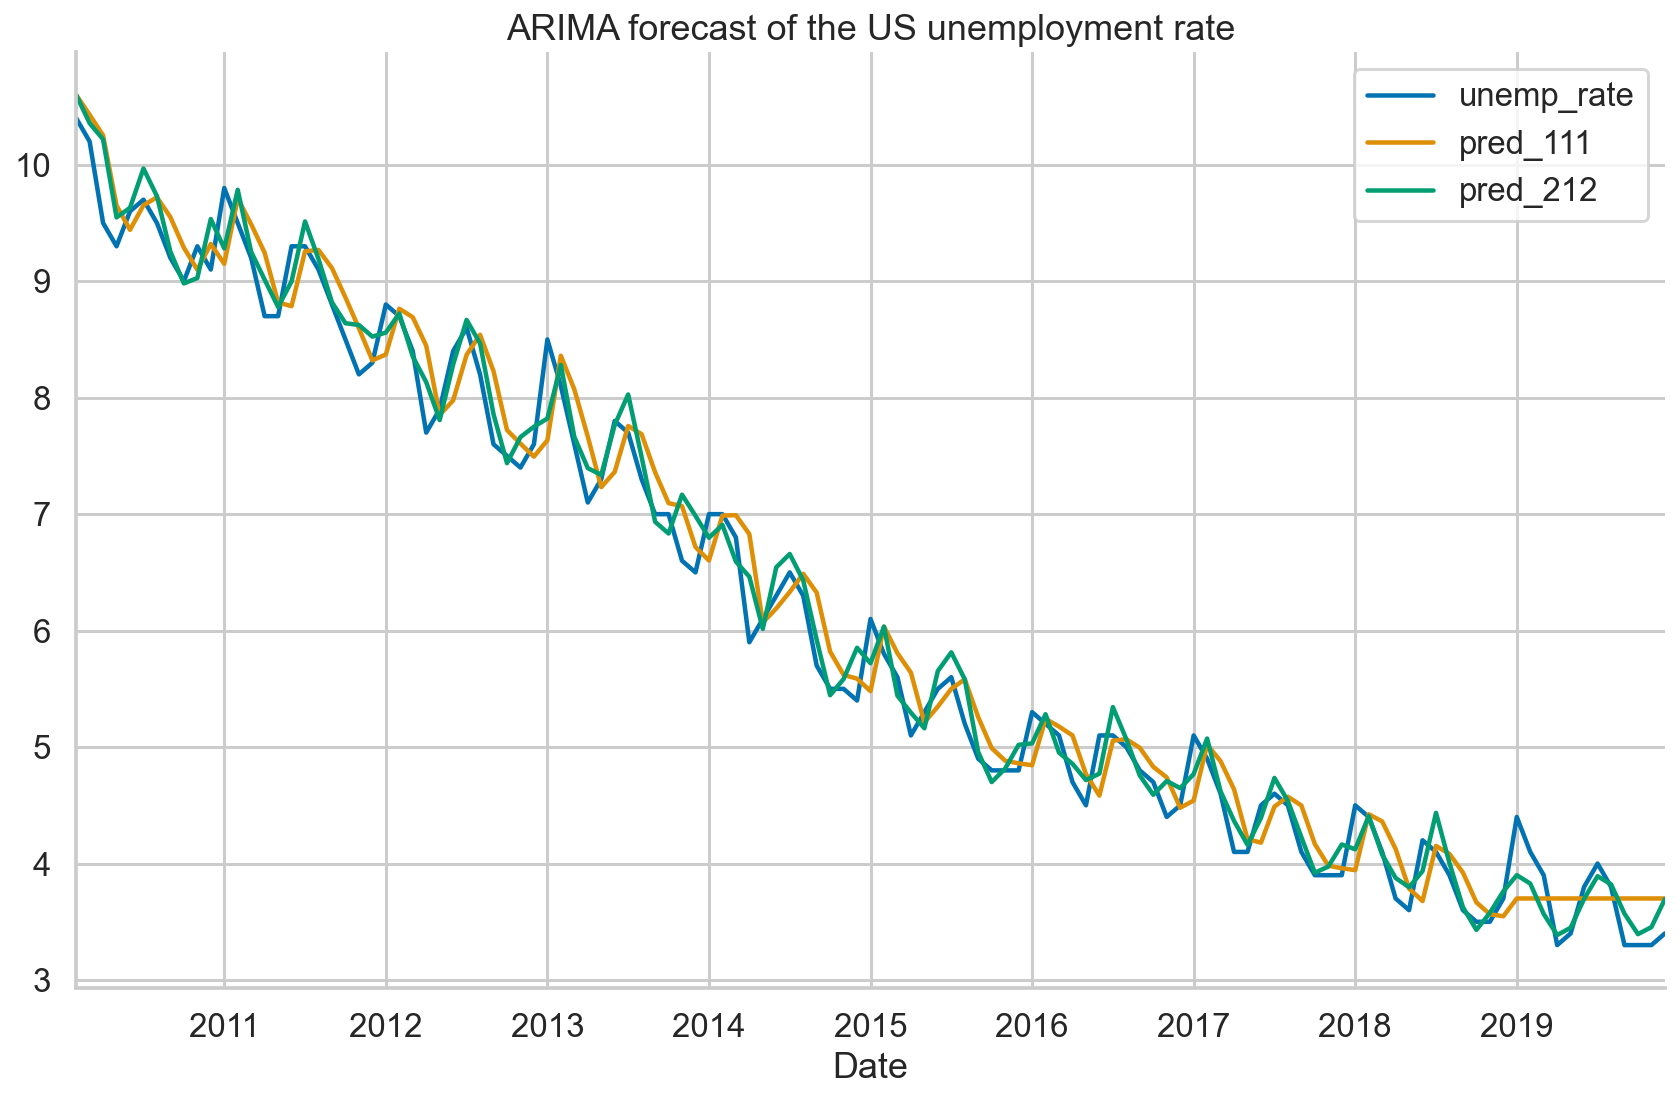

In [14]:
(
    df[["unemp_rate", "pred_111", "pred_212"]]
    .iloc[1:]
    .plot(title="ARIMA forecast of the US unemployment rate")
);

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_21", dpi=200)

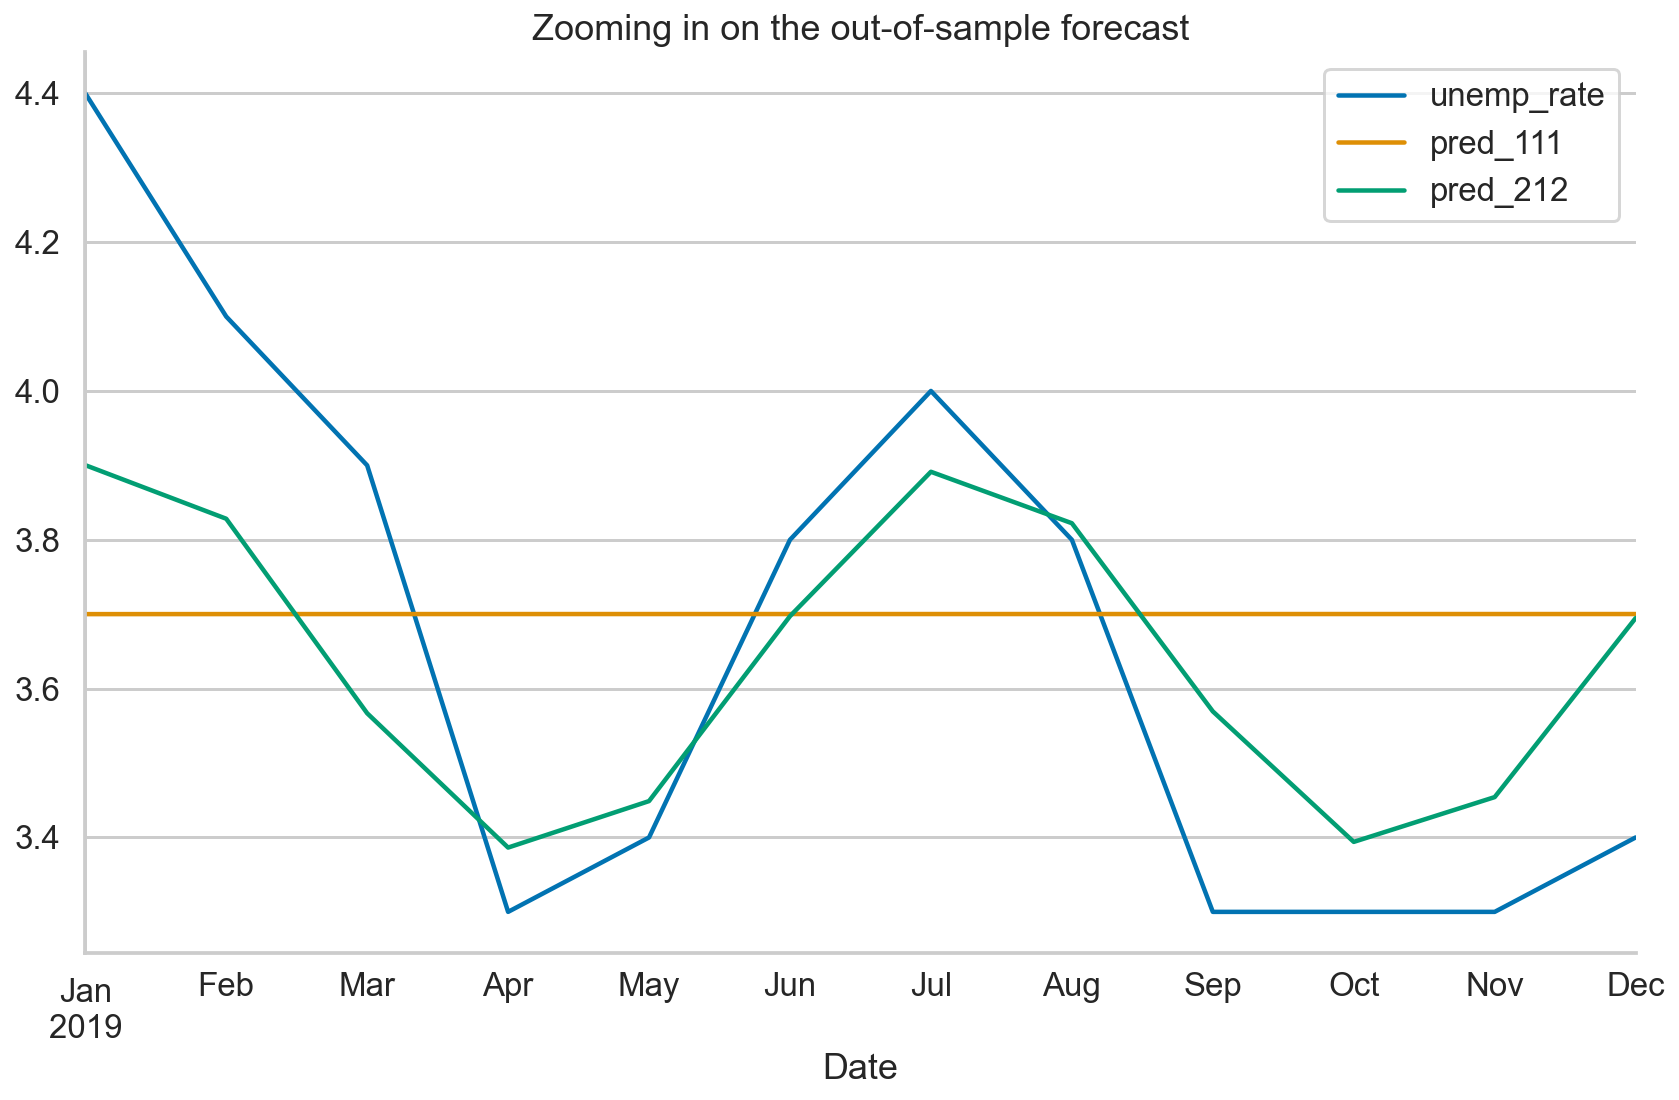

In [36]:
(
    df[["unemp_rate", "pred_111", "pred_212"]]
    .iloc[-TEST_LENGTH:]
    .plot(title="Zooming in on the out-of-sample forecast")
);

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_22", dpi=200)

In [37]:
mape_111 = mean_absolute_percentage_error(
    df["unemp_rate"].iloc[-TEST_LENGTH:], 
    df["pred_111"].iloc[-TEST_LENGTH:]
)

mape_212 = mean_absolute_percentage_error(
    df["unemp_rate"].iloc[-TEST_LENGTH:], 
    df["pred_212"].iloc[-TEST_LENGTH:]
)

print(f"MAPE of ARIMA(1,1,1): {100 * mape_111:.2f}%")
print(f"MAPE of ARIMA(2,1,2): {100 * mape_212:.2f}%")

MAPE of ARIMA(1,1,1): 9.14%
MAPE of ARIMA(2,1,2): 5.08%


8. Extract the forecast with the corresponding confidence intervals and plot them all together:

In [38]:
preds_df = arima_212.get_forecast(TEST_LENGTH).summary_frame()
preds_df.columns = ["fcst", "fcst_se", "ci_lower", "ci_upper"]
plot_df = df_test[["unemp_rate"]].join(np.exp(preds_df))
plot_df.head()

unemp_rate      fcst   fcst_se  ci_lower  ci_upper
Date                                                          
2019-01-01         4.4  3.900320  1.038006  3.625341  4.196157
2019-02-01         4.1  3.828279  1.050473  3.476079  4.216165
2019-03-01         3.9  3.566907  1.057629  3.195945  3.980929
2019-04-01         3.3  3.386399  1.063922  2.999135  3.823670
2019-05-01         3.4  3.448873  1.071992  3.009560  3.952314

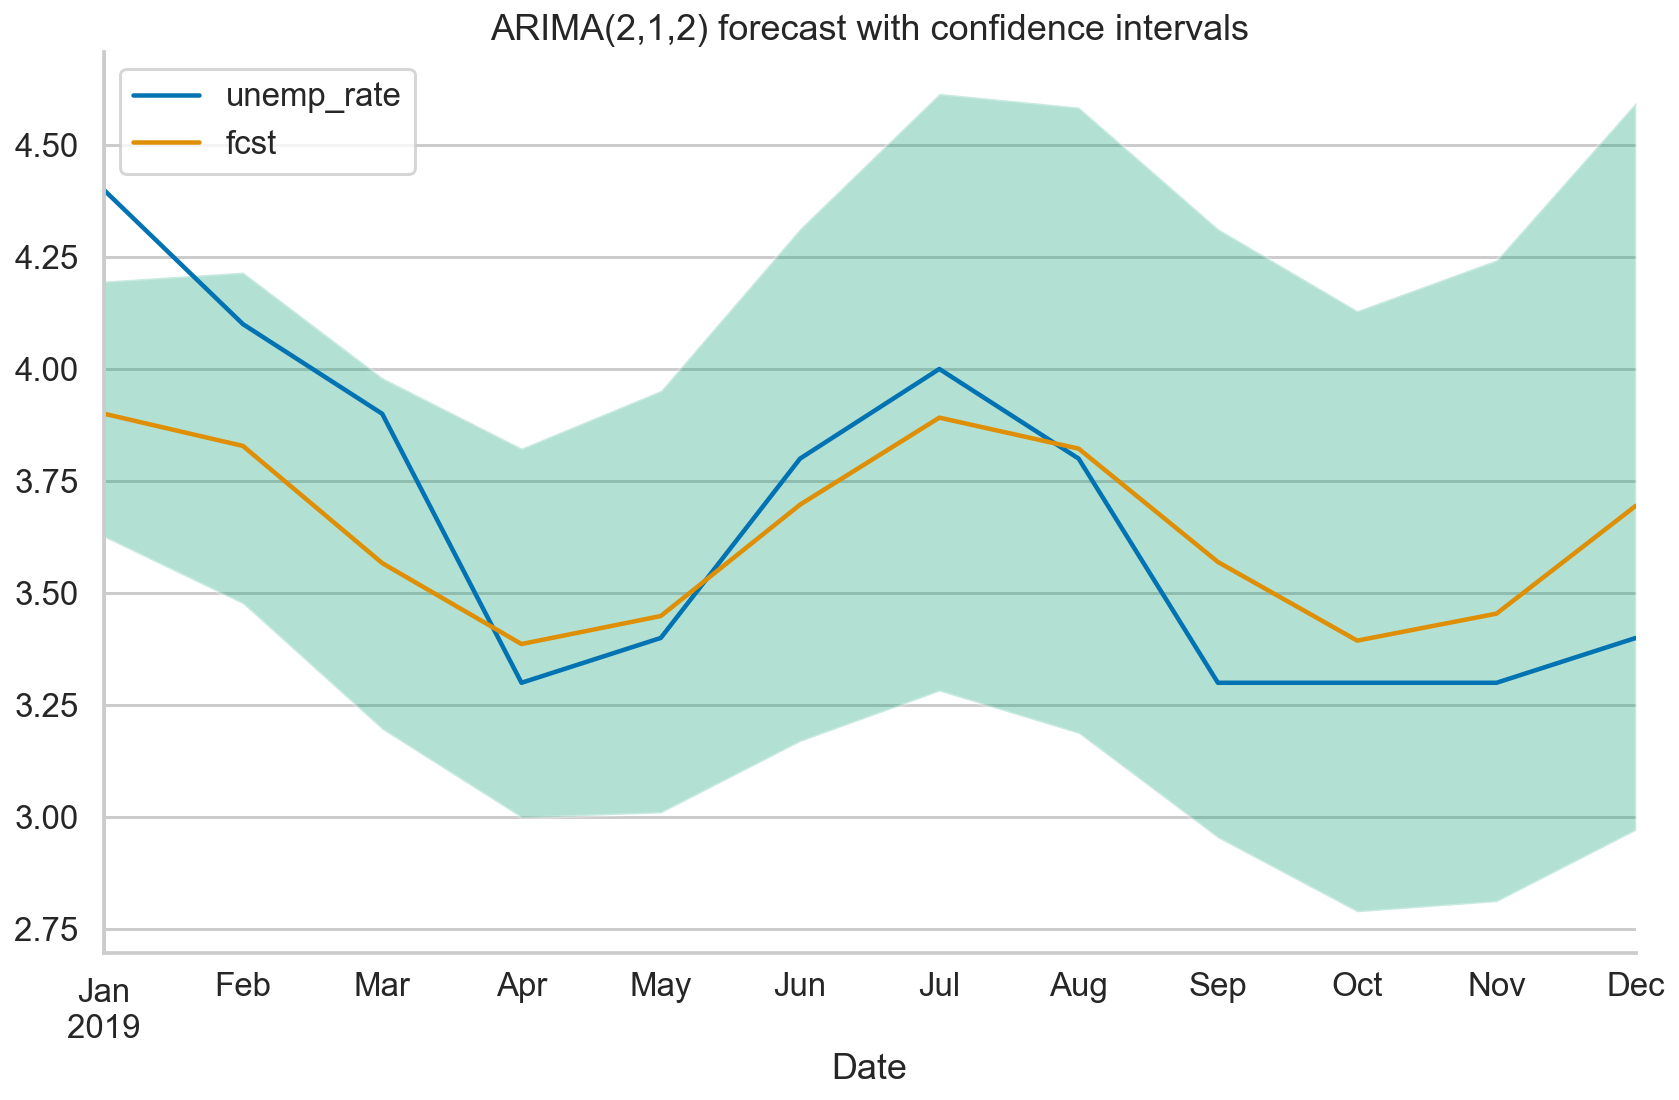

In [39]:
fig, ax = plt.subplots()

(
    plot_df[["unemp_rate", "fcst"]]
    .plot(ax=ax,
          title="ARIMA(2,1,2) forecast with confidence intervals")
)

ax.fill_between(plot_df.index,
                plot_df["ci_lower"],
                plot_df["ci_upper"],
                alpha=0.3, 
                facecolor="g")

ax.legend(loc="upper left");

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_23", dpi=200)

### There's more

1. Plot diagnostic plots for the residuals of the fitted ARIMA(2,1,2) model:

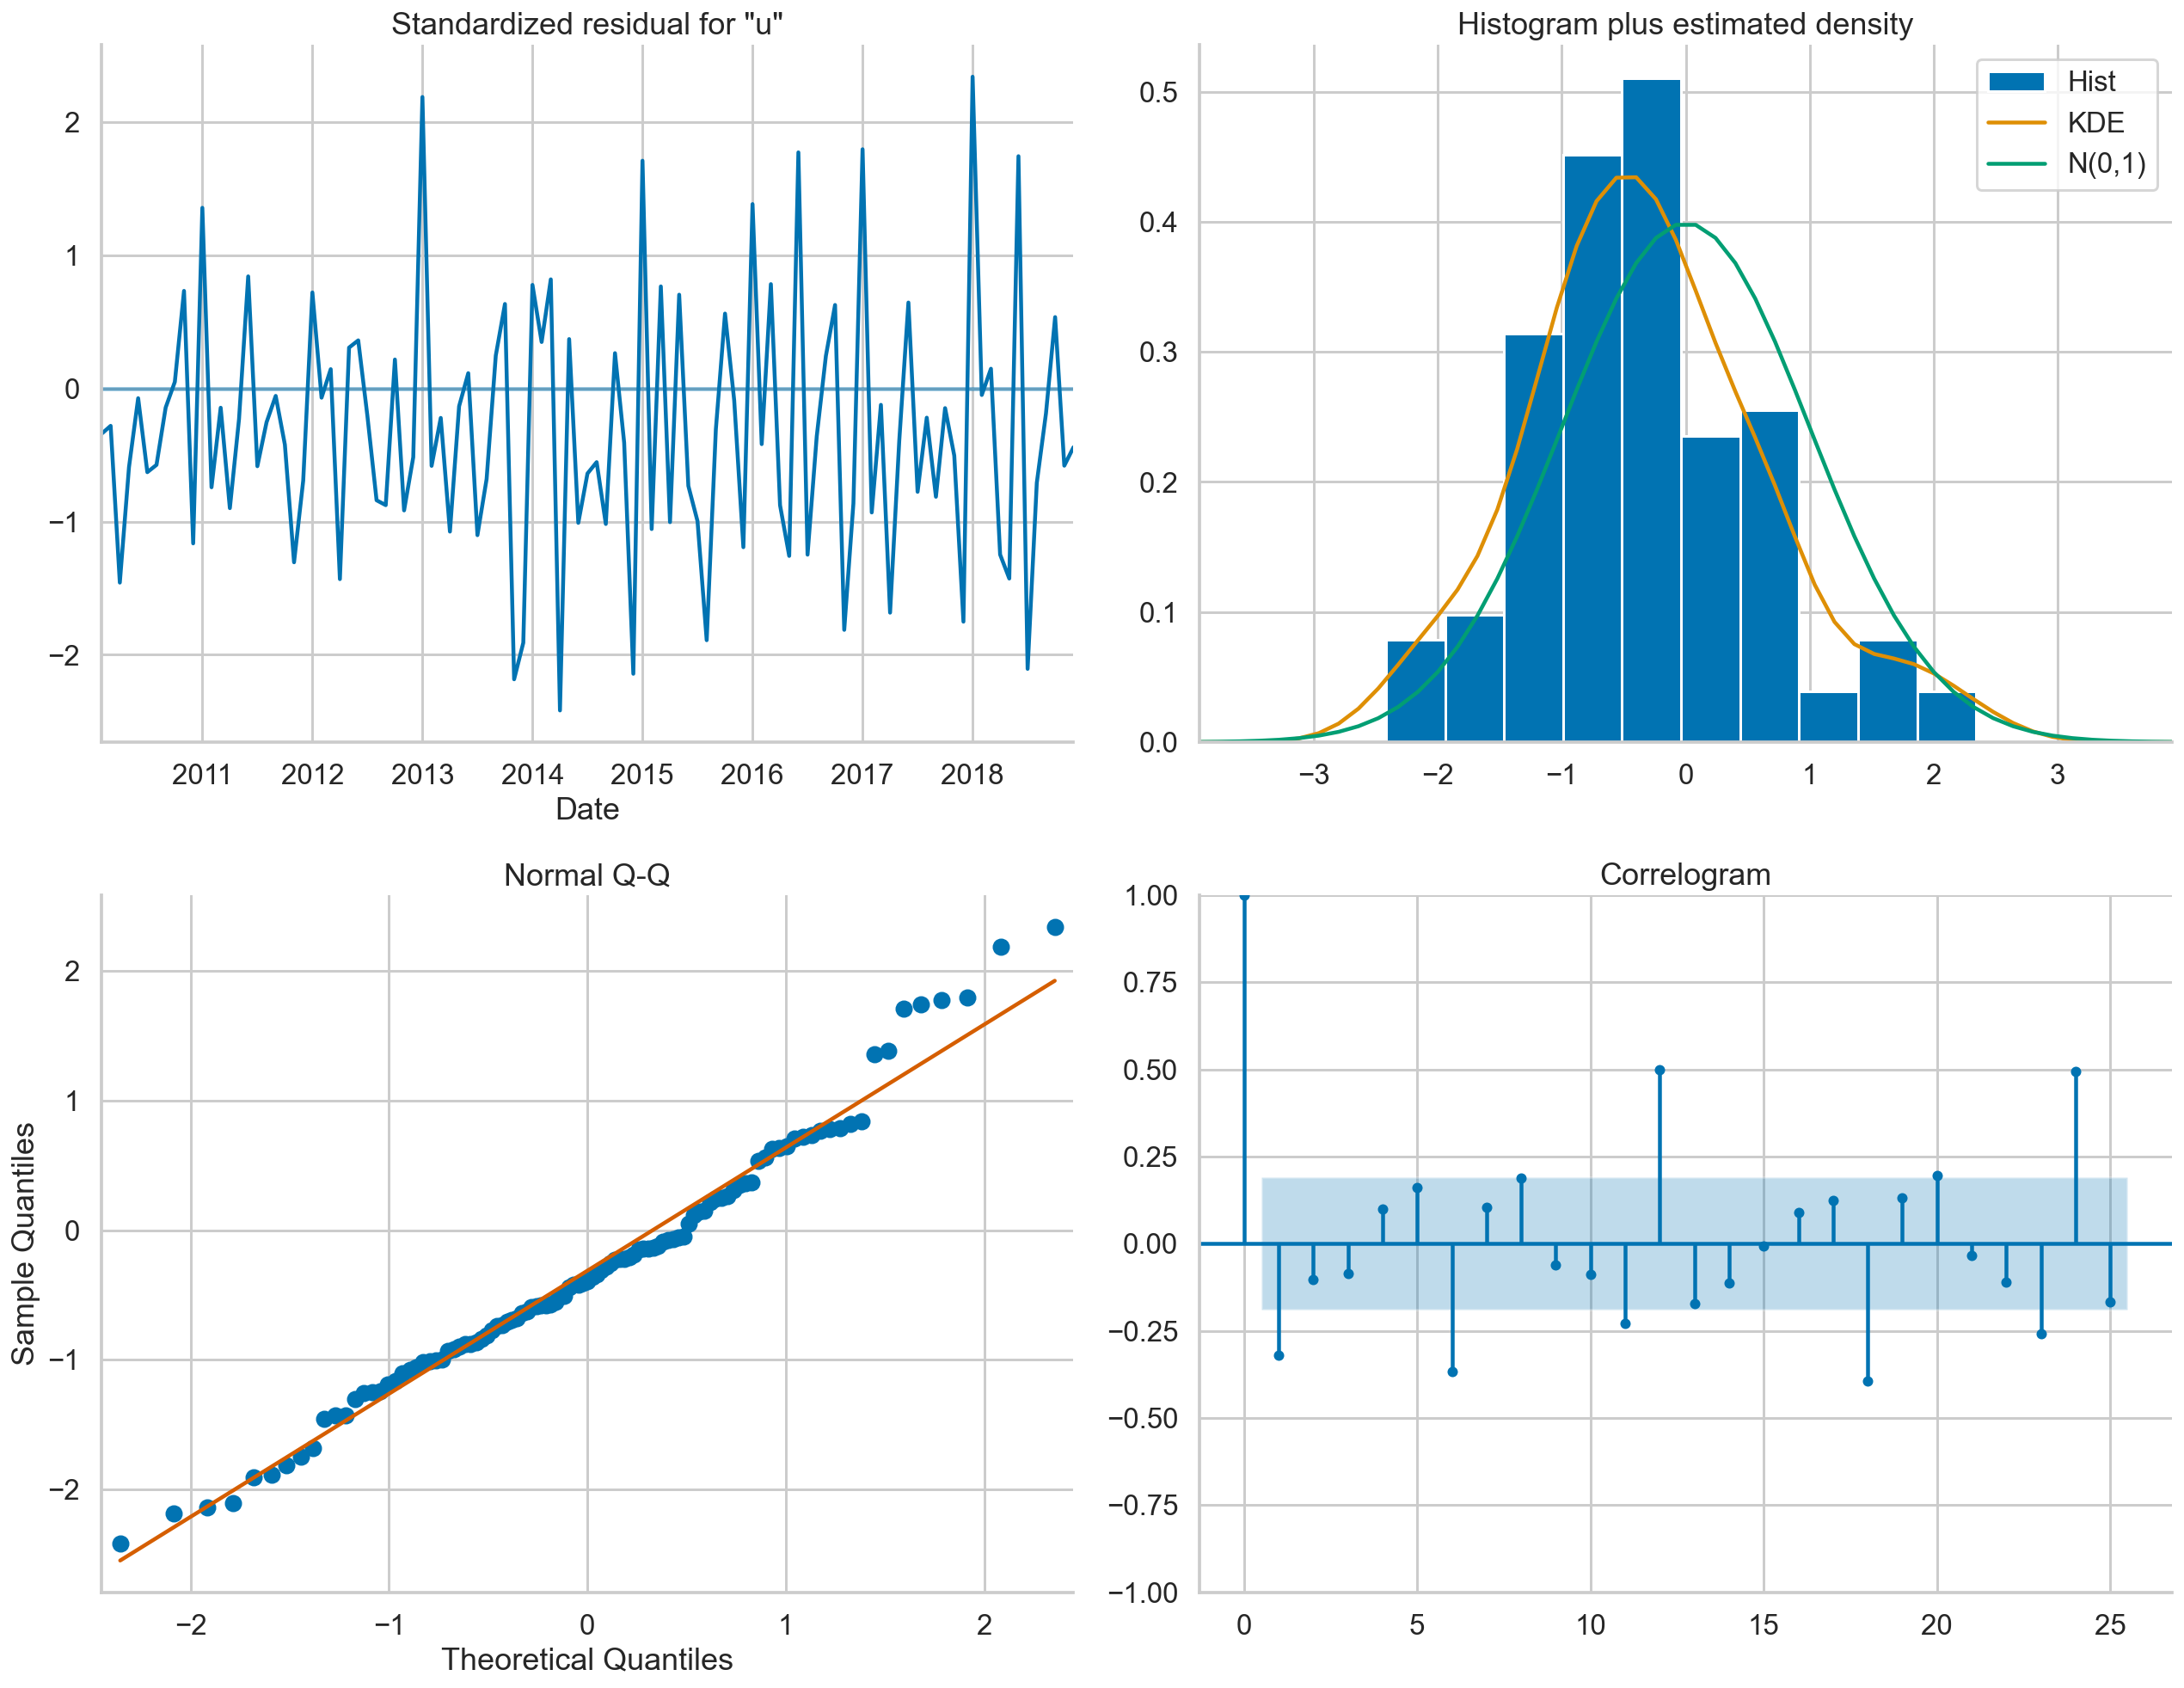

In [40]:
arima_212.plot_diagnostics(figsize=(18, 14), lags=25)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_24", dpi=200)

2. Apply the Ljung-Box's test for no autocorrelation in the residuals and plot the results:

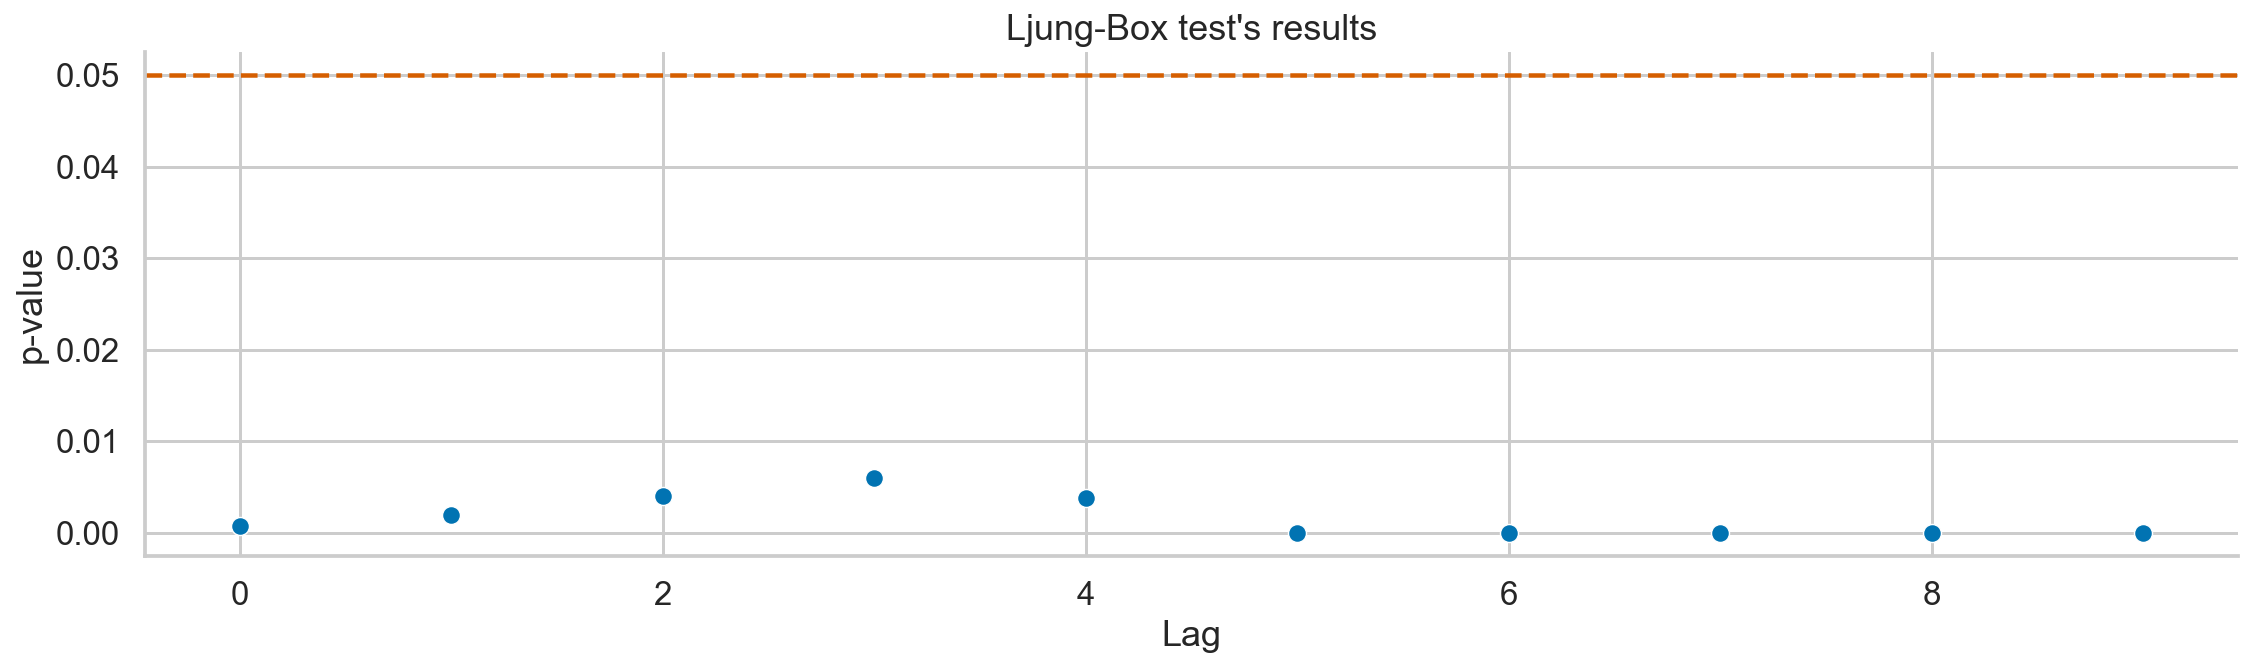

In [41]:
ljung_box_results = arima_212.test_serial_correlation(method="ljungbox")
ljung_box_pvals = ljung_box_results[0][1]

fig, ax = plt.subplots(1, figsize=[16, 5])
sns.scatterplot(x=range(len(ljung_box_pvals)), 
                y=ljung_box_pvals, 
                ax=ax)
ax.axhline(0.05, ls="--", c="r")
ax.set(title="Ljung-Box test's results",
       xlabel="Lag",
       ylabel="p-value")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_25", dpi=200)

In [68]:
# alternative way to get the same test results
from statsmodels.stats.diagnostic import acorr_ljungbox
ljung_box_results_df = acorr_ljungbox(arima_212.resid[1:])
ljung_box_results_df

lb_stat  lb_pvalue
1   10.667744   0.001090
2   11.712679   0.002862
3   12.501398   0.005849
4   13.634946   0.008556
5   16.460317   0.005646
6   31.788389   0.000018
7   32.914965   0.000027
8   36.966628   0.000012
9   37.534102   0.000021
10  38.435532   0.000032

The first residual of the fitted ARIMA/ARMA model is equal to the first observation of the time series. For more information, please see the following:
* https://stats.stackexchange.com/questions/202903/start-up-values-for-the-kalman-filter/221723#221723

In [69]:
df_train

unemp_rate  unemp_rate_log  first_diff
Date                                              
2010-01-01        10.6        2.360854         NaN
2010-02-01        10.4        2.341806   -0.019048
2010-03-01        10.2        2.322388   -0.019418
2010-04-01         9.5        2.251292   -0.071096
2010-05-01         9.3        2.230014   -0.021277
...                ...             ...         ...
2018-08-01         3.9        1.360977   -0.050010
2018-09-01         3.6        1.280934   -0.080043
2018-10-01         3.5        1.252763   -0.028171
2018-11-01         3.5        1.252763    0.000000
2018-12-01         3.7        1.308333    0.055570

[108 rows x 3 columns]

In [70]:
arima_212.resid

Date
2010-01-01    2.360854
2010-02-01   -0.019048
2010-03-01   -0.015286
2010-04-01   -0.072866
2010-05-01   -0.026332
                ...   
2018-08-01   -0.026436
2018-09-01   -0.006979
2018-10-01    0.020038
2018-11-01   -0.021603
2018-12-01   -0.016442
Freq: MS, Length: 108, dtype: float64

Other available tests:

In [71]:
arima_212.test_normality(method="jarquebera")

array([[3.24598335, 0.19730753, 0.40379383, 3.27545093]])

In [72]:
arima_212.test_heteroskedasticity(method="breakvar")

array([[1.99119542, 0.04212399]])

## 6.6 Finding the best-fitting ARIMA model with auto-ARIMA

### Getting ready

1. Import the libraries and authenticate:

In [3]:
import pandas as pd
import nasdaqdatalink

nasdaqdatalink.ApiConfig.api_key = "YOUR_KEY_HERE"

2. Download the monthly US unemployment rate from years 2010-2019:

In [4]:
df = (
    nasdaqdatalink.get(dataset="FRED/UNRATENSA", 
                       start_date="2010-01-01", 
                       end_date="2019-12-31")
    .rename(columns={"Value": "unemp_rate"})
)

# to hide the warnings of `statsmodels`
df.index.freq = "MS"

df.head()

unemp_rate
Date                  
2010-01-01        10.6
2010-02-01        10.4
2010-03-01        10.2
2010-04-01         9.5
2010-05-01         9.3

### How to do it...

1. Import the libraries:

In [5]:
import pandas as pd
import pmdarima as pm
from sklearn.metrics import mean_absolute_percentage_error

2. Create the train/test split:

In [6]:
TEST_LENGTH = 12
df_train = df.iloc[:-TEST_LENGTH]
df_test = df.iloc[-TEST_LENGTH:]

3. Find the best hyperparameters of the ARIMA model using the auto-ARIMA procedure:

In [7]:
auto_arima = pm.auto_arima(df_train,
                           test="adf",
                           seasonal=False,
                           with_intercept=False,
                           stepwise=True,
                           suppress_warnings=True,
                           trace=True)
                            
auto_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=7.411, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=77.864, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=77.461, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=75.688, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=68.551, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=54.321, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=7.458, Time=0.07 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=78.507, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=60.069, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=41.703, Time=0.03 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=10.527, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 0.894 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:               SARIMAX(2, 1, 2)   Log Likelihood                   1.294
Date:                Fri, 29 Jul 2022   AIC                              7.411
Time:                        23:59:36   BIC                             20.775
Sample:                             0   HQIC                            12.829
                                - 108                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9882      0.028     34.788      0.000       0.933       1.044
ar.L2         -0.9630      0.023    -41.667      0.000      -1.008      -0.918
ma.L1         -1.1926      0.057    -21.093      0.000      -1.303      -1.082
ma.L2          0.9241      0.063     14.580      0.000       0.800       1.048
sigma2         0.0550      0.009      6.065      0.000       0.037       0.073
===================================================================================
Ljung-Box (L1) (Q):                   5.22   Jarque-Bera (JB):                 4.47
Prob(Q):                              0.02   Prob(JB):                         0.11
Heteroskedasticity (H):               0.52   Skew:                             0.44
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

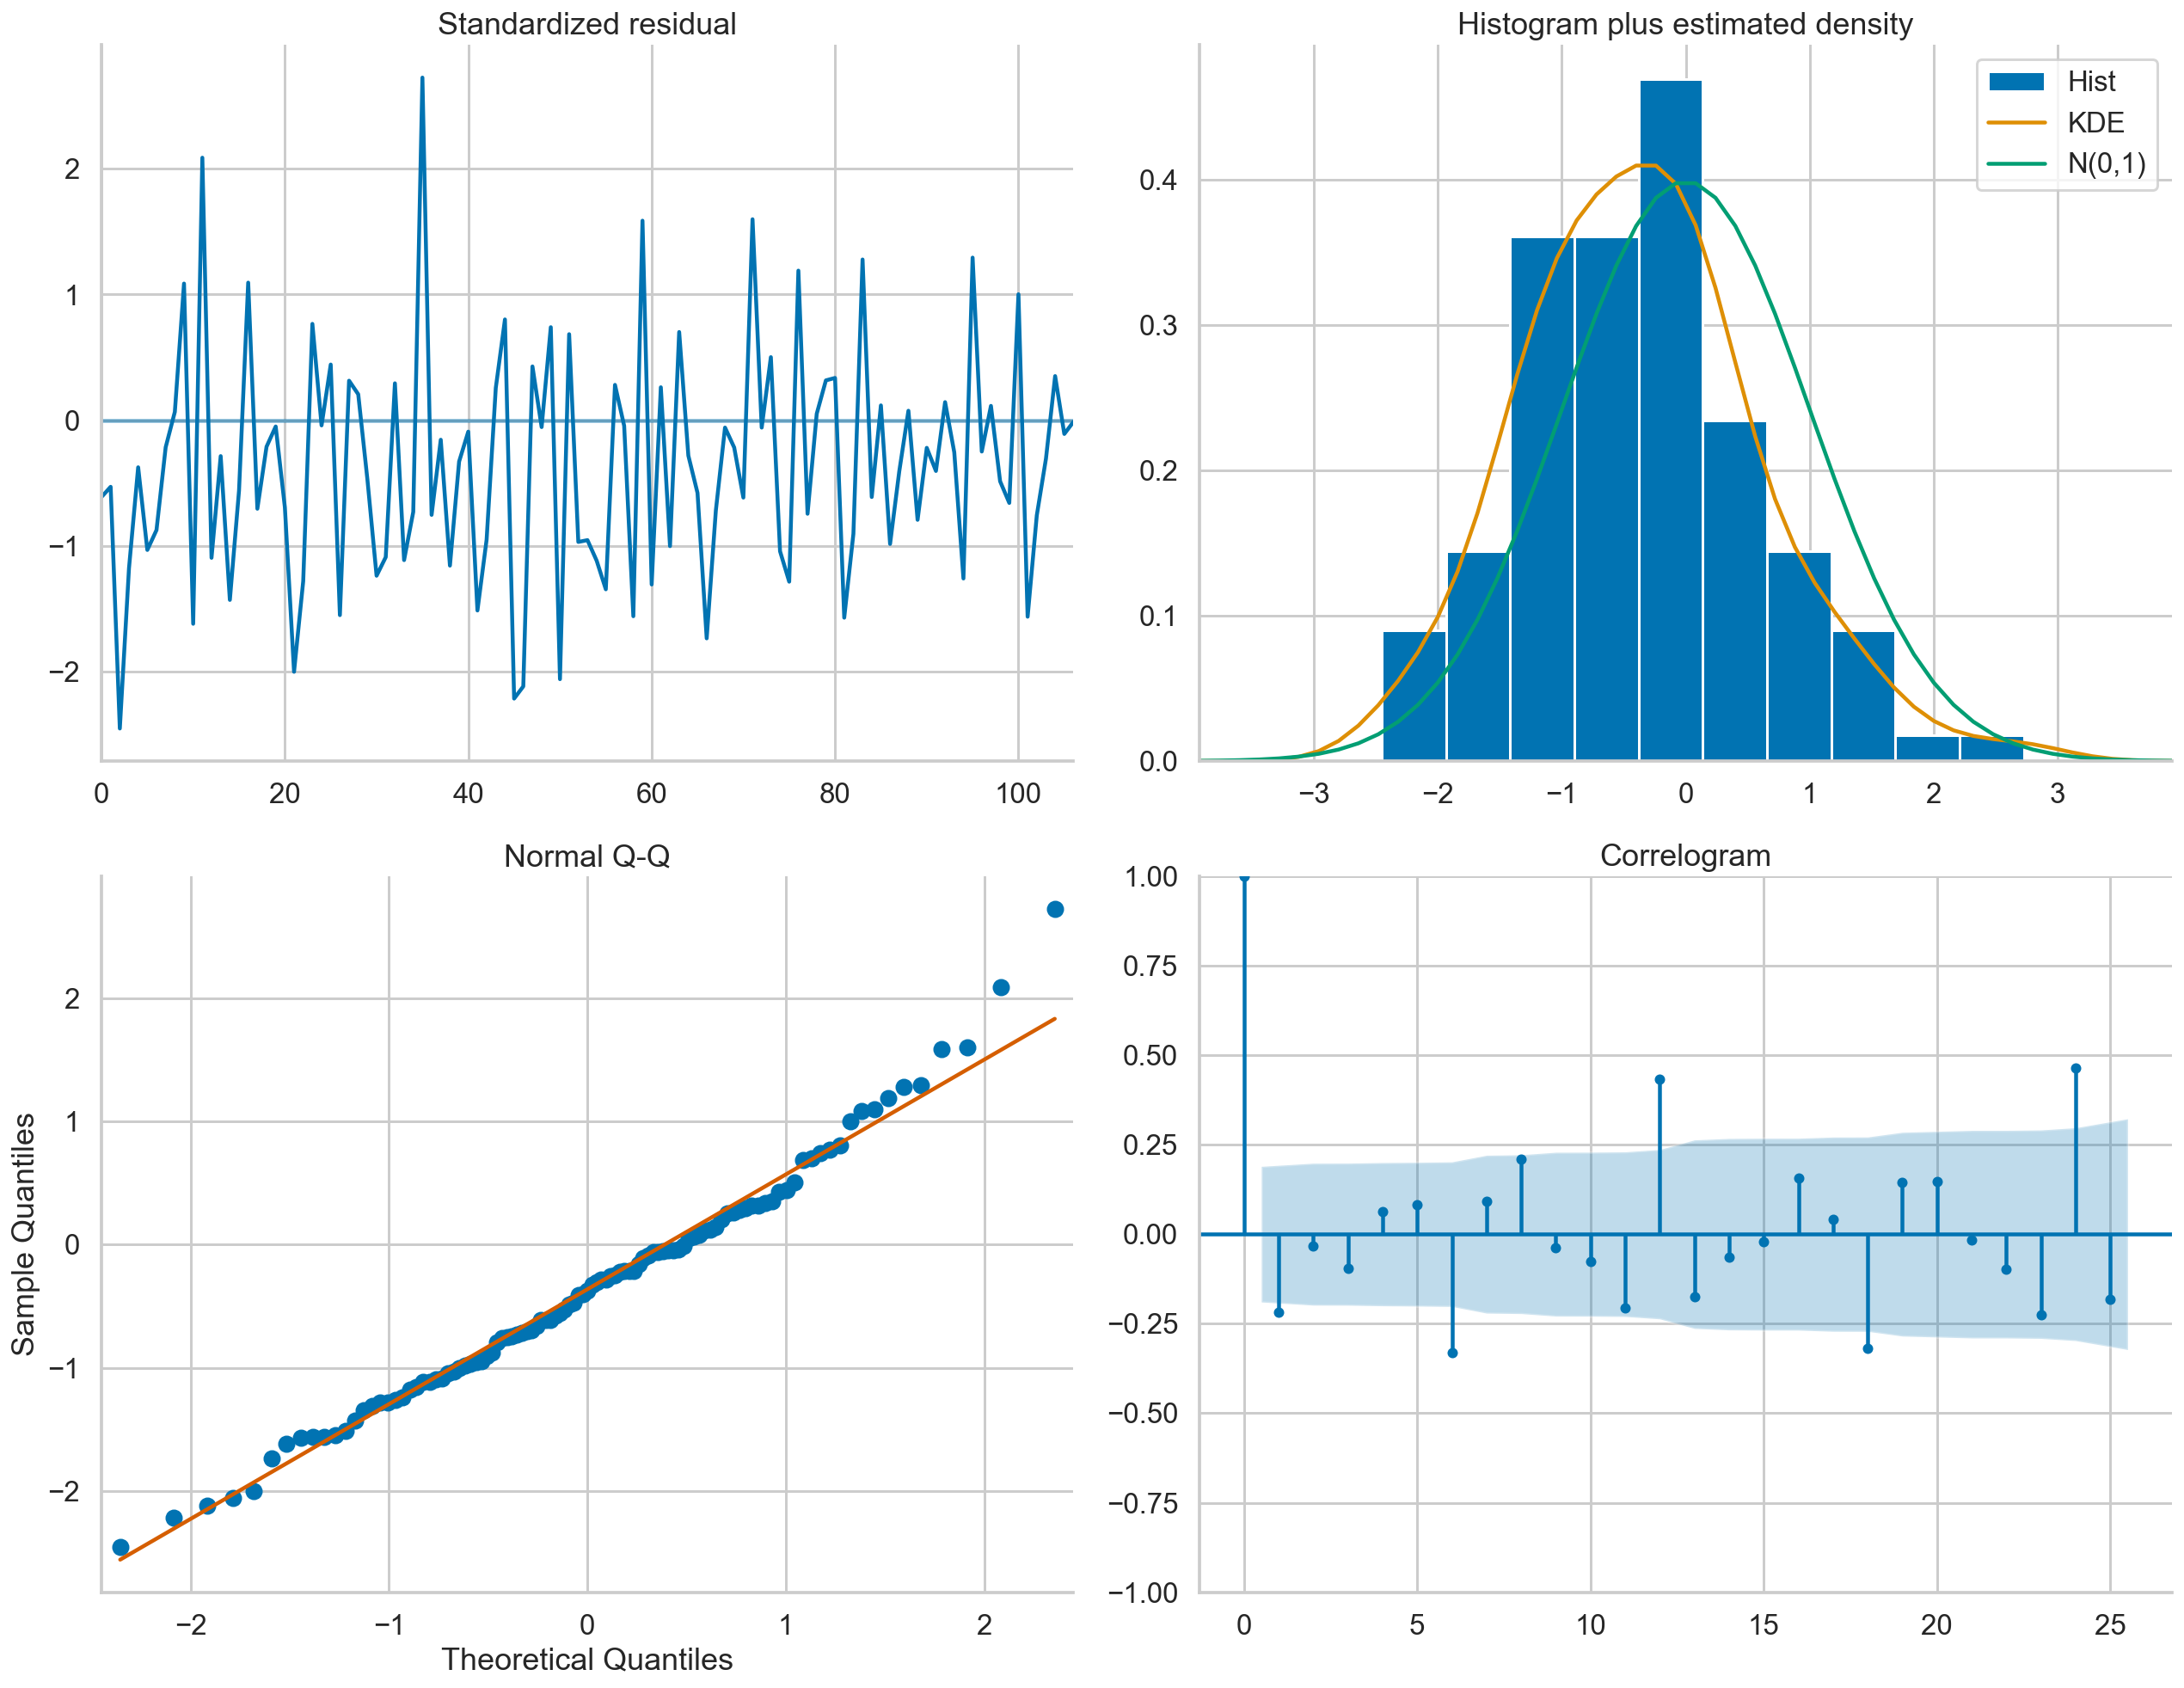

In [14]:
auto_arima.plot_diagnostics(figsize=(18, 14), lags=25)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_27", dpi=200)

4. Find the best hyperparameters of a SARIMA model using the auto-ARIMA procedure:

In [9]:
auto_sarima = pm.auto_arima(df_train,
                            test="adf",
                            seasonal=True,
                            m=12,
                            with_intercept=False,
                            stepwise=True,
                            suppress_warnings=True,
                            trace=True)
auto_sarima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12]             : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=77.864, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-19.349, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[12]             : AIC=39.115, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=77.461, Time=0.01 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=39.307, Time=0.03 sec
 ARIMA(1,1,0)(2,0,1)[12]             : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-19.382, Time=0.01 sec
 ARIMA(0,1,0)(2,0,0)[12]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(1,0,1)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,1)[12]             : AIC=37.495, Time=0.02 sec
 ARIMA(0,1,0)(2,0,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=-22.056, Time=0.04 sec


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  108
Model:             SARIMAX(0, 1, 5)x(2, 0, [1], 12)   Log Likelihood                  41.060
Date:                              Sat, 30 Jul 2022   AIC                            -64.120
Time:                                      00:00:04   BIC                            -40.065
Sample:                                           0   HQIC                           -54.368
                                              - 108                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2808      0.115     -2.449      0.014      -0.506      -0.056
ma.L2         -0.1211      0.112     -1.078      0.281      -0.341       0.099
ma.L3         -0.2031      0.129     -1.575      0.115      -0.456       0.050
ma.L4          0.0749      0.122      0.616      0.538      -0.164       0.313
ma.L5          0.2473      0.105      2.363      0.018       0.042       0.452
ar.S.L12       0.8702      0.160      5.455      0.000       0.558       1.183
ar.S.L24       0.1275      0.152      0.838      0.402      -0.171       0.426
ma.S.L12      -0.8719      0.344     -2.536      0.011      -1.546      -0.198
sigma2         0.0200      0.006      3.589      0.000       0.009       0.031
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 1.98
Prob(Q):                              0.67   Prob(JB):                         0.37
Heteroskedasticity (H):               0.60   Skew:                            -0.29
Prob(H) (two-sided):                  0.13   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Please refer to the following SO question to see why the procedure returns `AIC=inf` for some model specifications:
* https://stats.stackexchange.com/questions/160612/auto-arima-doesnt-calculate-aic-values-for-the-majority-of-models

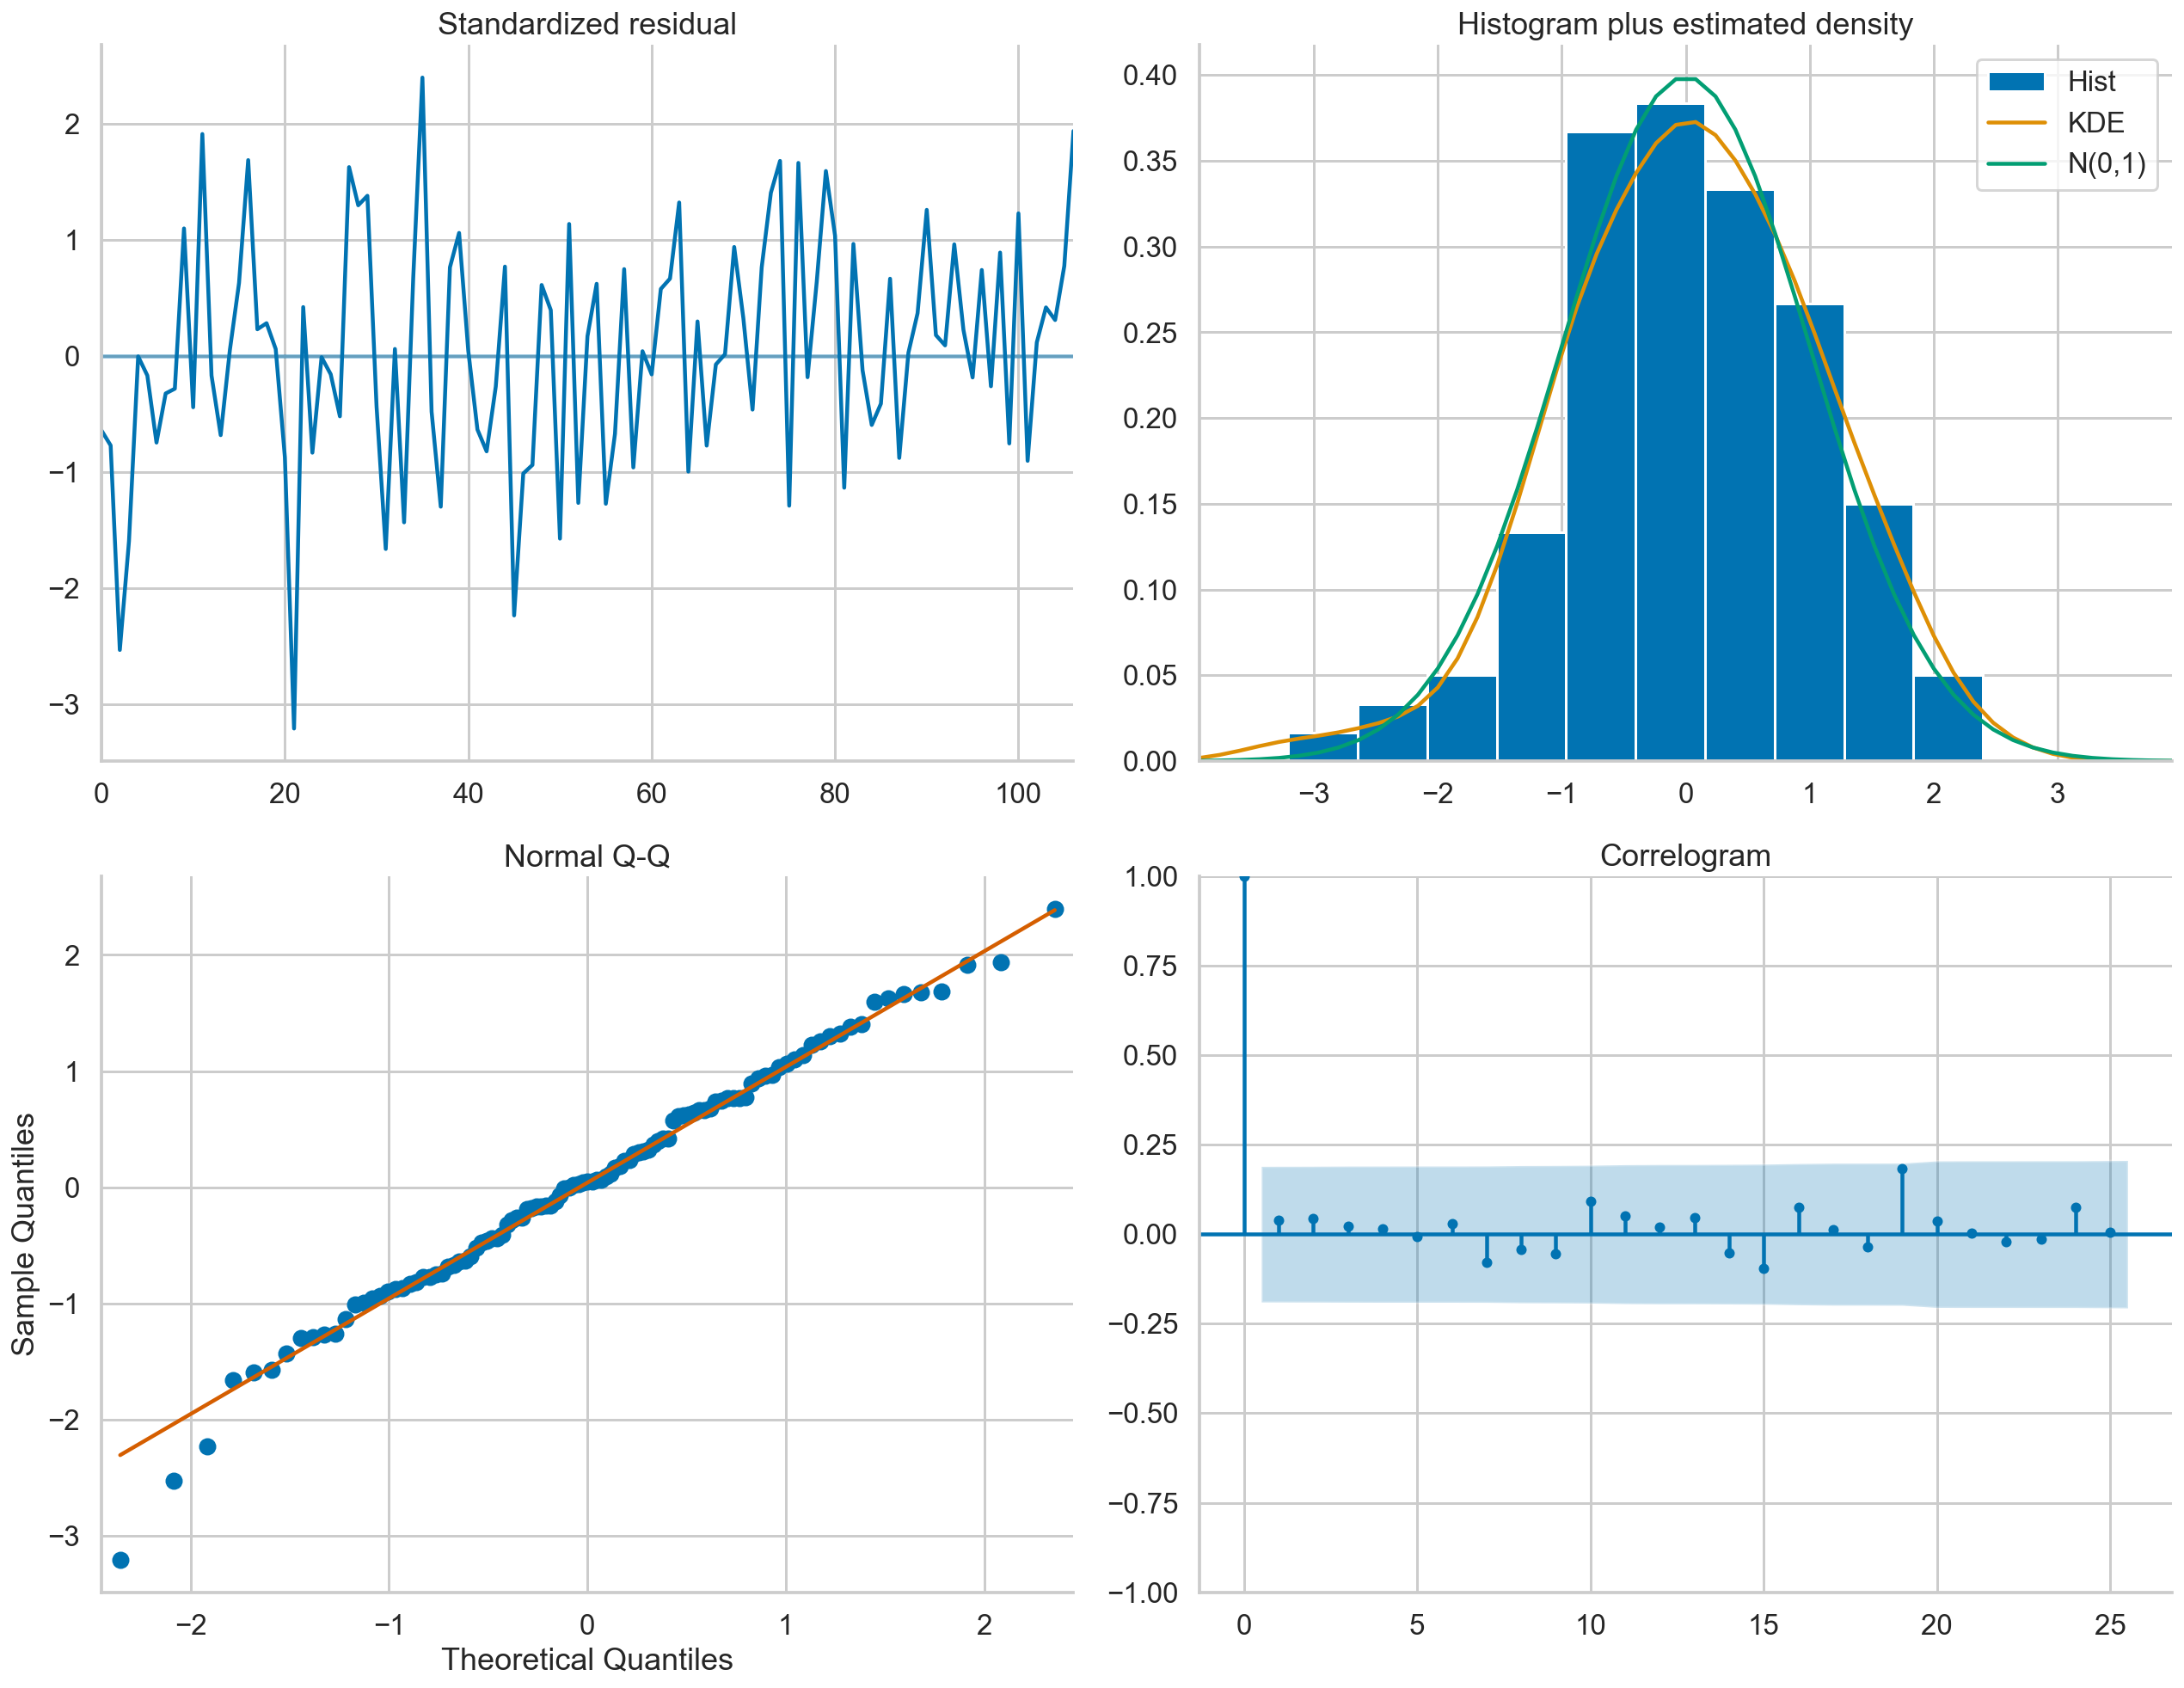

In [13]:
auto_sarima.plot_diagnostics(figsize=(18, 14), lags=25);

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_29", dpi=200)

5. Calculate the forecasts from the two models and plot them:

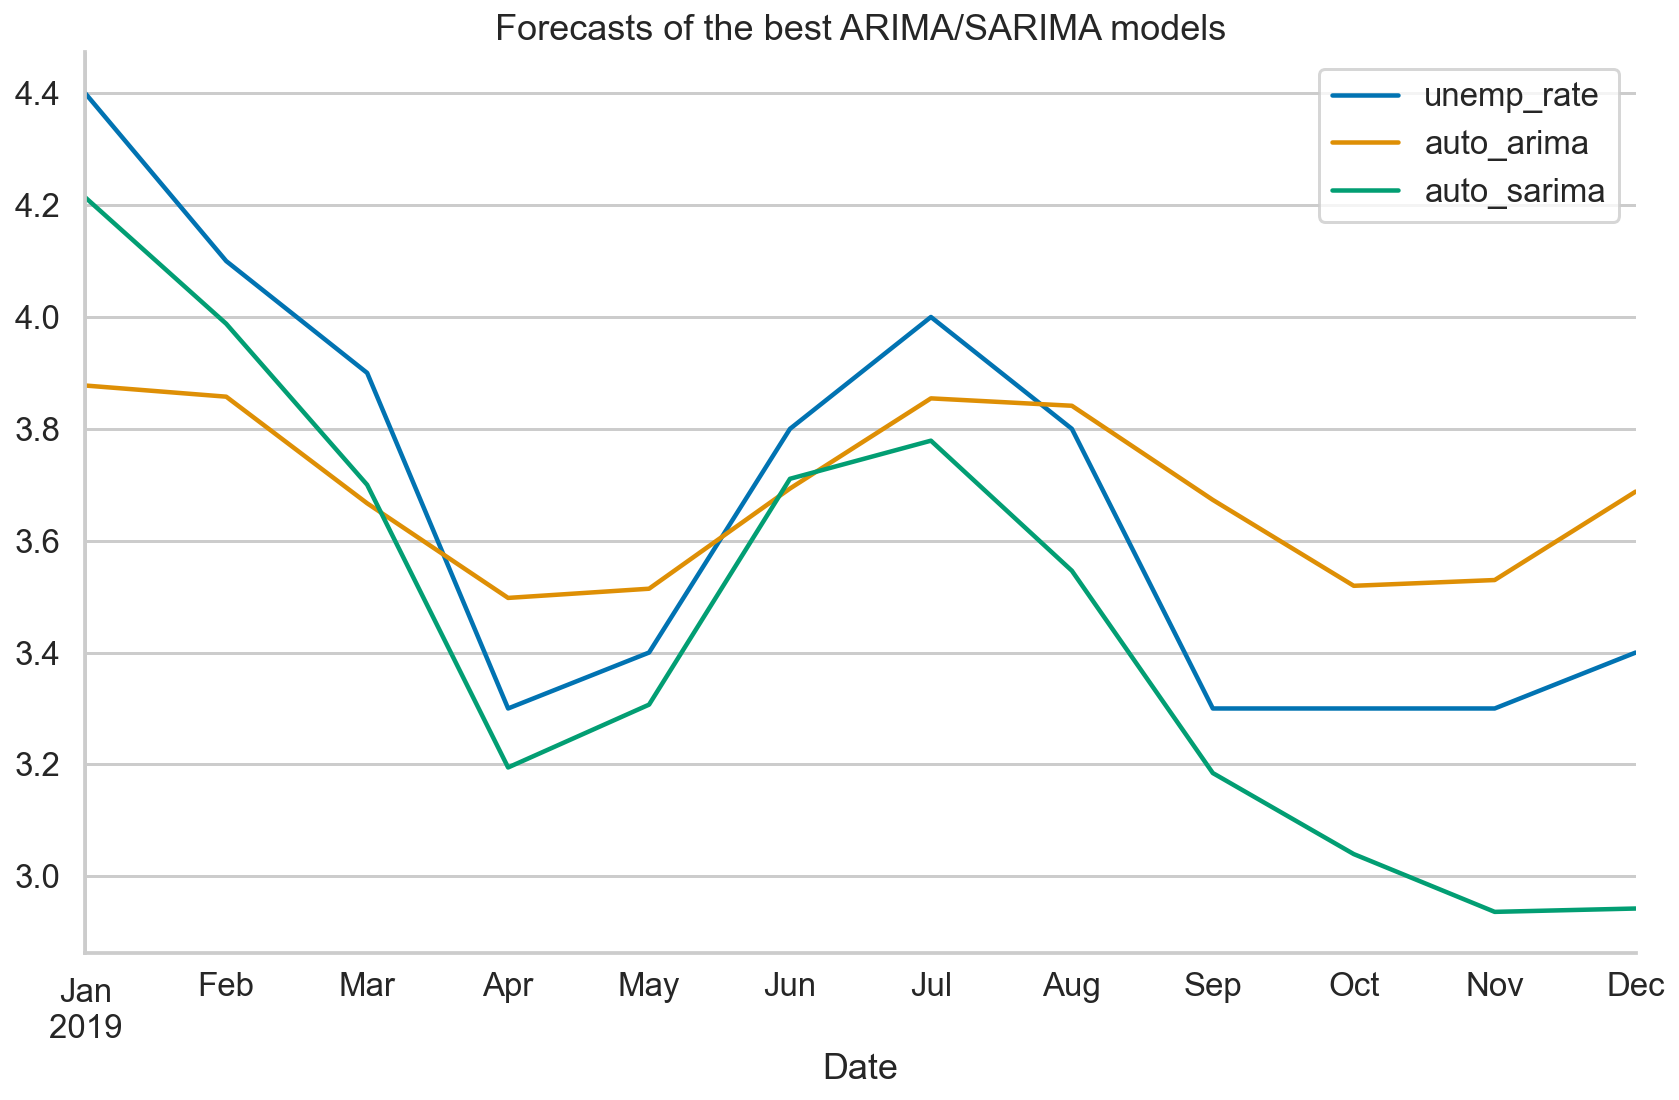

In [11]:
df_test["auto_arima"] = auto_arima.predict(TEST_LENGTH)
df_test["auto_sarima"] = auto_sarima.predict(TEST_LENGTH)
df_test.plot(title="Forecasts of the best ARIMA/SARIMA models");

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_30", dpi=200)

In [12]:
mape_auto_arima = mean_absolute_percentage_error(
    df_test["unemp_rate"], 
    df_test["auto_arima"]
)

mape_auto_sarima = mean_absolute_percentage_error(
    df_test["unemp_rate"], 
    df_test["auto_sarima"]
)

print(f"MAPE of auto-ARIMA: {100*mape_auto_arima:.2f}%")
print(f"MAPE of auto-SARIMA: {100*mape_auto_sarima:.2f}%")

MAPE of auto-ARIMA: 6.17%
MAPE of auto-SARIMA: 5.70%


### There's more

1. Import the libraries:

In [15]:
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import FourierFeaturizer
from pmdarima.preprocessing import LogEndogTransformer
from pmdarima import arima

2. Create new features (month dummies) and split them into the train/test sets:

In [16]:
month_dummies = pd.get_dummies(
    df.index.month, 
    prefix="month_", 
    drop_first=True
)
month_dummies.index = df.index
df = df.join(month_dummies)

df_train = df.iloc[:-TEST_LENGTH]
df_test = df.iloc[-TEST_LENGTH:]

3. Find the best hyperparameters of the ARIMAX model:

In [17]:
auto_arimax = pm.auto_arima(
    df_train[["unemp_rate"]],
    exogenous=df_train.drop(columns=["unemp_rate"]),
    test="adf",
    seasonal=False,
    with_intercept=False,
    stepwise=True,
    suppress_warnings=True,
    trace=True
)
                            
auto_arimax.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-89.405, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-79.748, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-77.784, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-77.777, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-89.522, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-76.711, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-89.045, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-72.910, Time=0.21 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-74.953, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-87.287, Time=0.19 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=-74.909, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-98.212, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-99.917, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-99.823, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-99.6

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:               SARIMAX(0, 1, 2)   Log Likelihood                  64.959
Date:                Sat, 30 Jul 2022   AIC                            -99.917
Time:                        00:02:14   BIC                            -59.825
Sample:                    01-01-2010   HQIC                           -83.664
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0590      0.009     -6.760      0.000      -0.076      -0.042
month__2      -0.1329      0.072     -1.856      0.063      -0.273       0.007
month__3      -0.3405      0.074     -4.593      0.000      -0.486      -0.195
month__4      -0.8482      0.066    -12.846      0.000      -0.978      -0.719
month__5      -0.7560      0.067    -11.337      0.000      -0.887      -0.625
month__6      -0.2637      0.066     -3.996      0.000      -0.393      -0.134
month__7      -0.1491      0.074     -2.016      0.044      -0.294      -0.004
month__8      -0.3345      0.070     -4.778      0.000      -0.472      -0.197
month__9      -0.6422      0.068     -9.434      0.000      -0.776      -0.509
month__10     -0.7278      0.067    -10.938      0.000      -0.858      -0.597
month__11     -0.7578      0.055    -13.712      0.000      -0.866      -0.649
month__12     -0.6761      0.045    -15.036      0.000      -0.764      -0.588
ma.L1         -0.2874      0.106     -2.711      0.007      -0.495      -0.080
ma.L2         -0.1234      0.105     -1.179      0.239      -0.329       0.082
sigma2         0.0174      0.003      6.427      0.000       0.012       0.023
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.05
Prob(Q):                              0.91   Prob(JB):                         0.98
Heteroskedasticity (H):               0.60   Skew:                            -0.03
Prob(H) (two-sided):                  0.13   Kurtosis:                         2.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

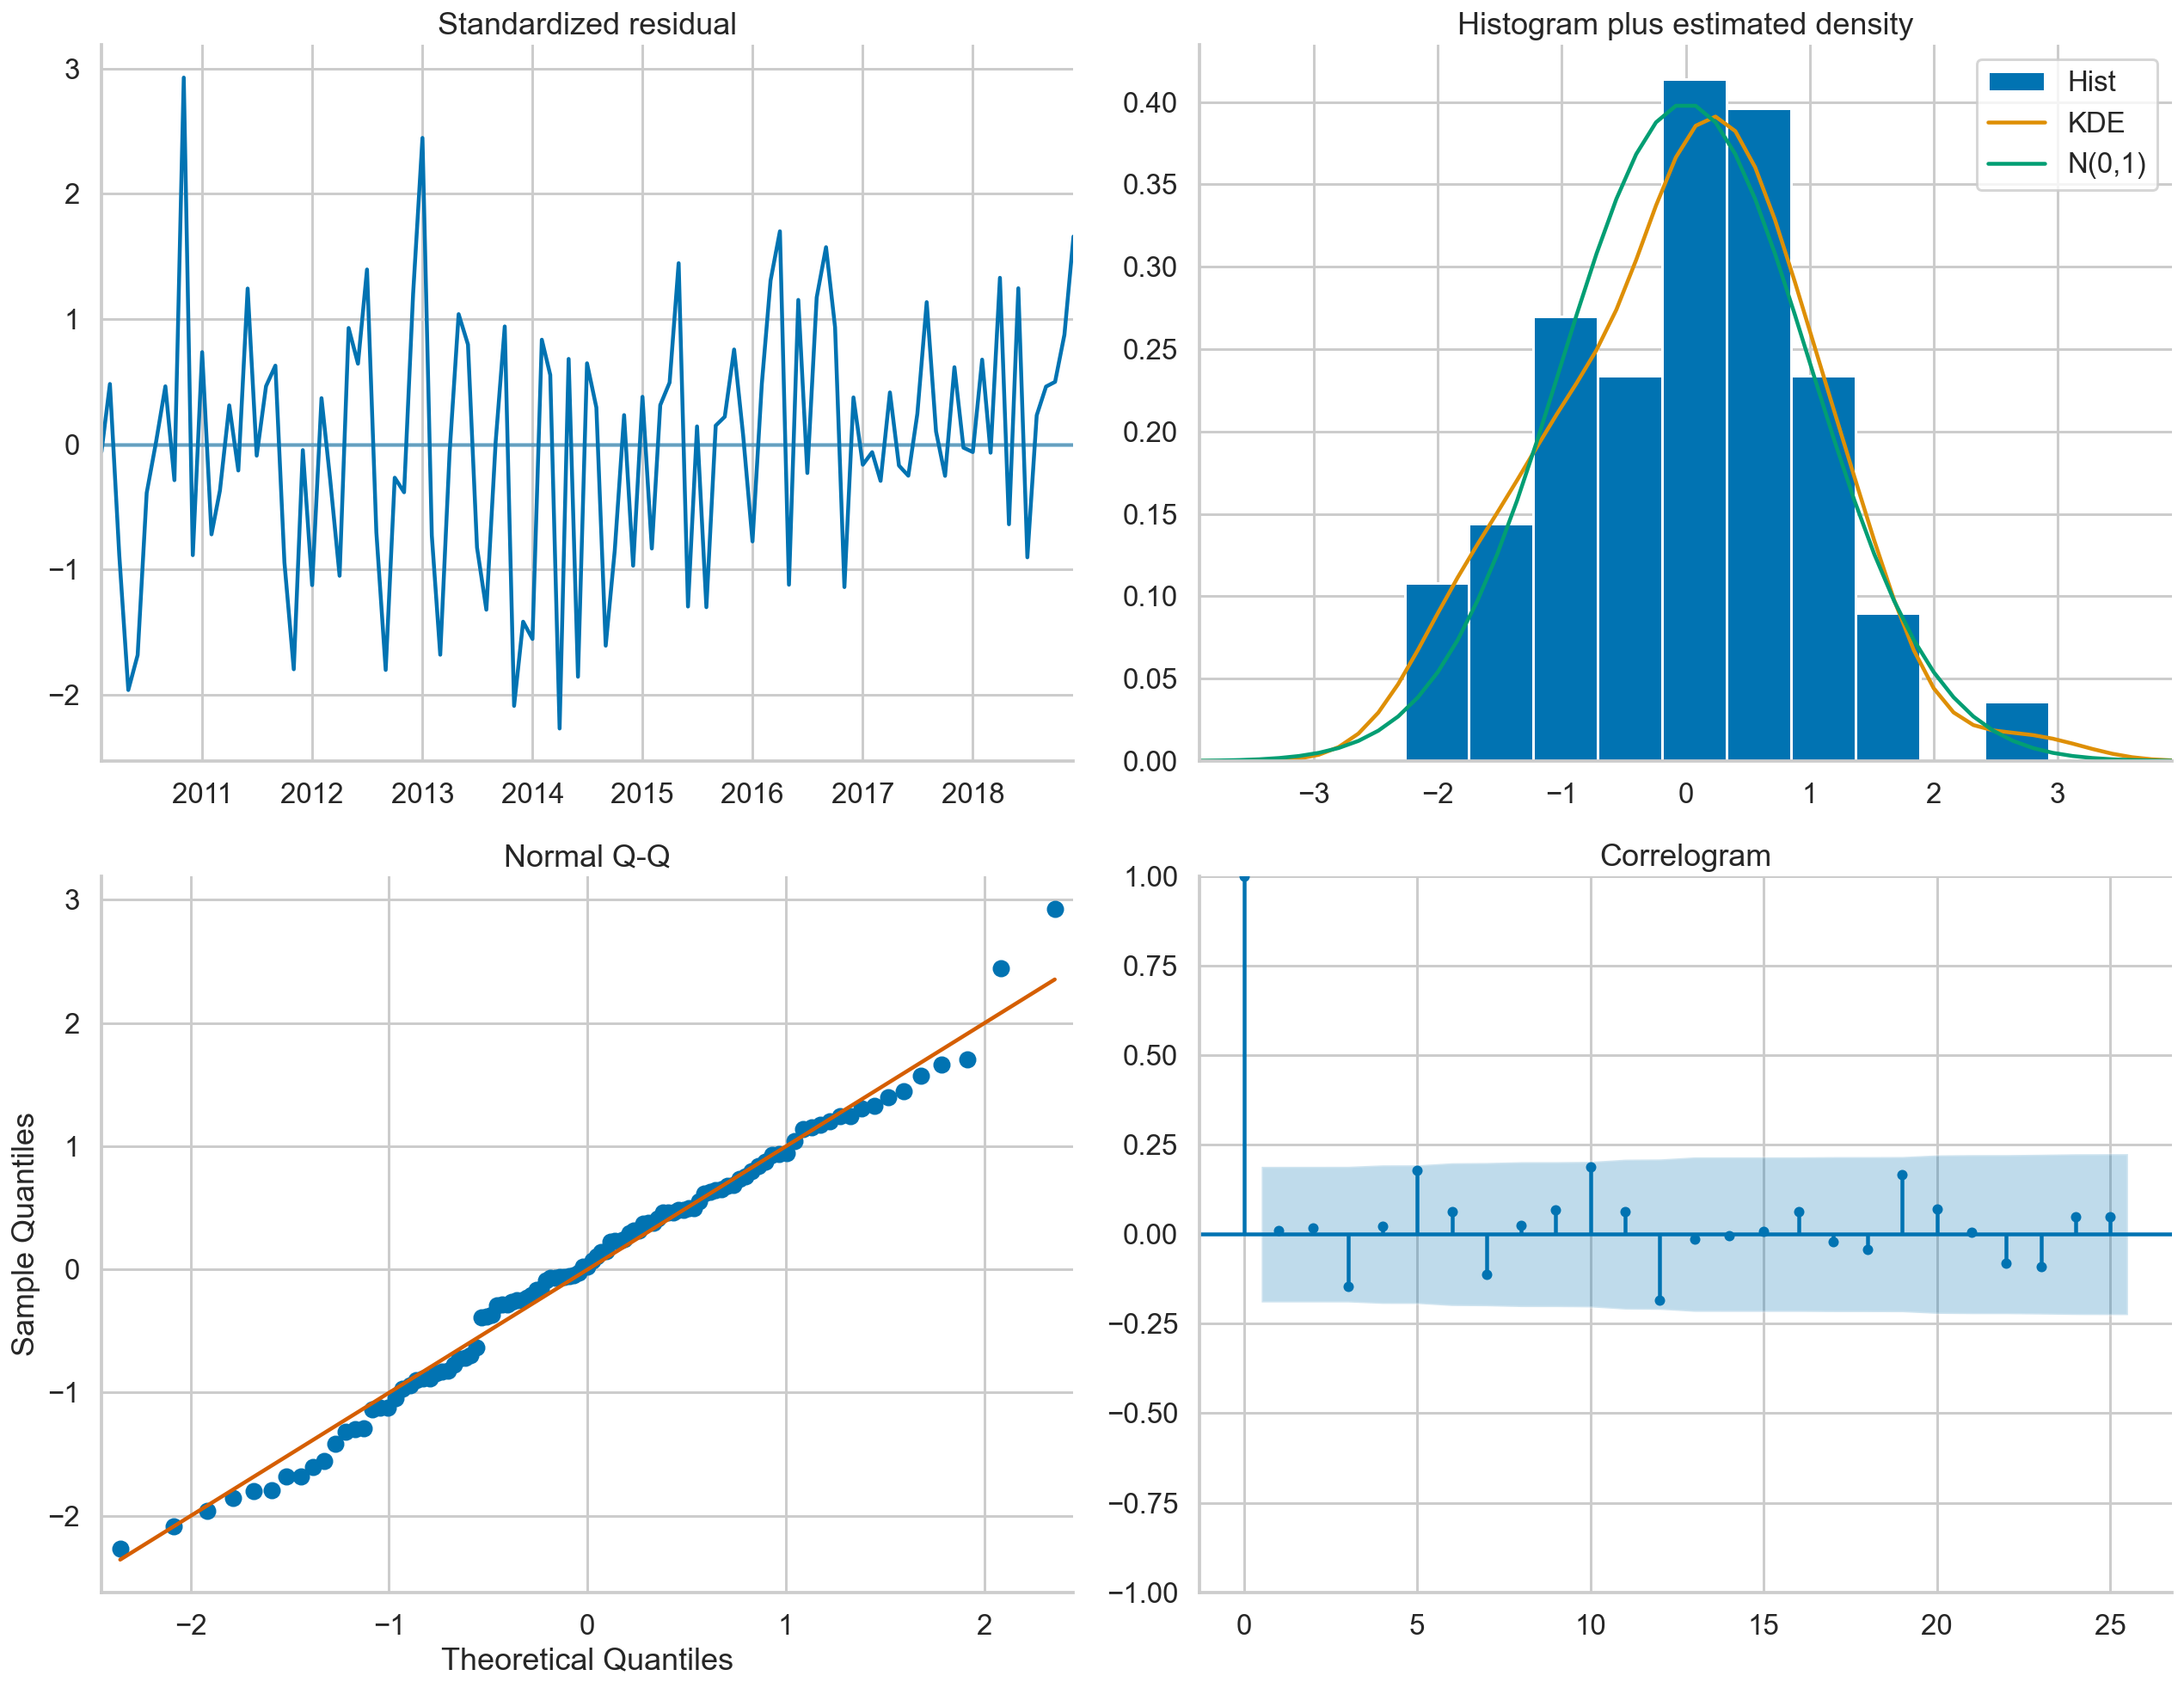

In [18]:
auto_arimax.plot_diagnostics(figsize=(18, 14), lags=25);

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_32", dpi=200)

4. Find the best hyperparameters of the ARIMA pipeline:

In [19]:
auto_arima_pipe = Pipeline([
    ("log_transform", LogEndogTransformer()),
    ("fourier", FourierFeaturizer(m=12)),
    ("arima", arima.AutoARIMA(stepwise=True, trace=1, 
                              error_action="warn",
                              test="adf", seasonal=False, 
                              with_intercept=False, 
                              suppress_warnings=True))
])

auto_arima_pipe.fit(df_train[["unemp_rate"]])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-443.949, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-451.806, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-449.936, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-449.932, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-447.934, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-462.898, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-464.399, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-465.503, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-475.671, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-483.865, Time=0.16 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-482.065, Time=0.17 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-481.317, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-478.961, Time=0.18 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-480.454, Time=0.29 sec
 ARIMA(4,1,0)(0,0,0)[0]          

Pipeline(steps=[('log_transform', LogEndogTransformer()),
                ('fourier', FourierFeaturizer(m=12)),
                ('arima',
                 AutoARIMA(error_action='warn', seasonal=False, test='adf',
                           trace=1, with_intercept=False))])

5. Calculate the forecasts and plot them:

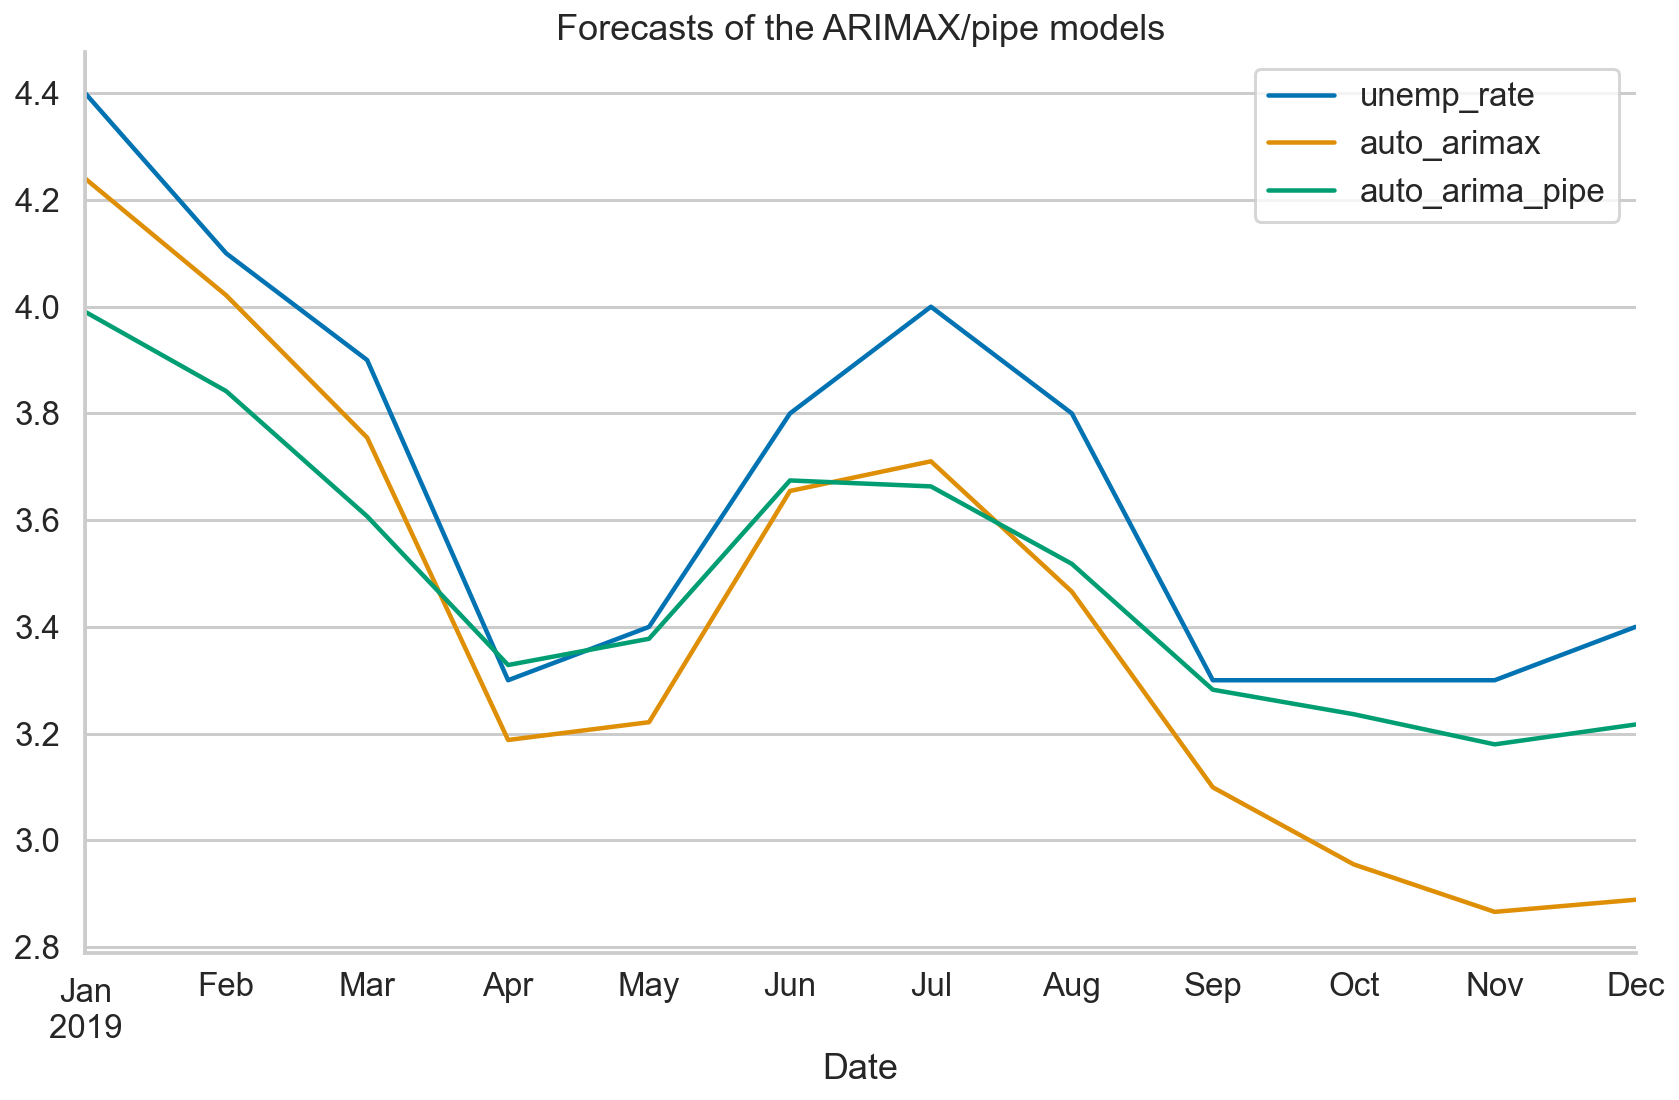

In [20]:
# specify return_conf_int when calling `predict` to get the confidence intervals
results_df = df_test[["unemp_rate"]].copy()
results_df["auto_arimax"] = auto_arimax.predict(
    TEST_LENGTH, 
    X=df_test.drop(columns=["unemp_rate"])
)
results_df["auto_arima_pipe"] = auto_arima_pipe.predict(TEST_LENGTH)
results_df.plot(title="Forecasts of the ARIMAX/pipe models");

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_33", dpi=200)

7. Calculate the MAPEs:

In [21]:
mape_auto_arimax = mean_absolute_percentage_error(results_df["unemp_rate"], 
                                                  results_df["auto_arimax"])

mape_auto_pipe = mean_absolute_percentage_error(results_df["unemp_rate"], 
                                                results_df["auto_arima_pipe"])

print(f"MAPE of auto-ARIMAX: {100*mape_auto_arimax:.2f}%")
print(f"MAPE of auto-pipe: {100*mape_auto_pipe:.2f}%")

MAPE of auto-ARIMAX: 6.88%
MAPE of auto-pipe: 4.61%
